In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, balanced_accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel
import shap 
import river 
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier, Pool
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## 1. Load, Combine and Transform Data

In [2]:
# Load the dataset files 
customer_df = pd.read_csv('customer.csv')
loan_df = pd.read_csv('loan.csv')
state_df = pd.read_csv('state_region.csv')
job_df = pd.read_excel('job_mapping.xlsx')

In [3]:
# Merge customer and loan data on 'customer_id'
try:
    merged_df = pd.merge(customer_df, loan_df, on='customer_id', how='left')
except KeyError as e:
    print(f"Error merging dataframes: {e}. Please check if 'customer_id' column exists in both dataframes or adjust the merge key.")
    exit()

In [4]:
# Merge merged_df and state_df on 'state'
try:
    merged_df = pd.merge(merged_df, state_df, on='state', how='left')
except KeyError as e:
    print(f"Error merging dataframes: {e}. Please check if 'customer_id' column exists in both dataframes or adjust the merge key.")
    exit()

The 'emp_title' column contains many unique and unstandardized values. Directly using it in the model could introduce noise or generate too many features. Therefore, this data has been cleaned by processing the text, converting it into embeddings using SentenceTransformer, clustering the embeddings using KMeans, and labeling the clusters to create a new column: 'profession'. In addition, based on this data, I also created the 'job_level' column to provide additional information about the customer's job level. Finally, the data was exported into an Excel file for use in the model. (See details in the file 'job_cluster_final.ipynb').

In [5]:
# Merge merged_df and job_df on 'emp_title'
try:
    merged_df = pd.merge(merged_df, job_df, on='emp_title', how='left')
except KeyError as e:
    print(f"Error merging dataframes: {e}. Please check if 'customer_id' column exists in both dataframes or adjust the merge key.")
    exit()

In this project, I only use data from 2012 to 2015.

In [6]:
merged_df = merged_df[merged_df['issue_year'] < 2016]

In [7]:
merged_df

customer_id  \
2       b'1\xe3uD\xe4\x13\x1f\x80\x1d\xb1\xa5\x14x\xac...   
10      b'\x920\x9e\xa6\xdf^&l\x0b\x96\xa7\xf1\xa1\x12...   
11      b"]\xb1en:''/\x1f(m\x04\x01\xc0\xa1hs\xce\xbf\...   
17      b'\xd3\x9e;\x91aM\x80\xedP\xd0"\xd0\x95\x07\x9...   
21      b'\xf3\xef?<\x00\x8d\xf7rB:"\x84}\xb37\x83$\x9...   
...                                                   ...   
270280  b"tV\xba\x92\xa5\x97_>'v\xb0\xfa\xef\xe5\x89\x...   
270283  b'\xe2\x0e\x89\xcde\x94\x07F\xd2\xbc\xc7NV"\xe...   
270286  b'\x9a\x81\xad\xa5KJd\xd0J\t,\x89\xbc\xbb3F\xb...   
270291  b'\x96\xe2\xf9\xd3@\xc6O\x8eI{\xea\xc0\x841f\x...   
270292  b'{\x11M\xc9\xef;\xbbU\xd0\xeb"\xd4[c\x0cFD\x0...   

                  emp_title emp_length home_ownership  annual_inc  \
2                Care Giver        NaN            OWN     46800.0   
10                      NaN        NaN           RENT     62000.0   
11                      NaN        NaN       MORTGAGE     42500.0   
17                      NaN        NaN           RENT     50000.0   
21                      NaN        NaN           RENT     50000.0   
...                     ...        ...            ...         ...   
270280       US Coast Guard  10+ years           RENT     78000.0   
270283            Sr. Puser  10+ years           RENT     85000.0   
270286  Enforcement Officer  10+ years       MORTGAGE    105000.0   
270291  Forestry Technician  10+ years           RENT     61000.0   
270292     Property Manager  10+ years       MORTGAGE    118000.0   

        annual_inc_joint verification_status zip_code addr_state  avg_cur_bal  \
2                    NaN            Verified    010xx         MA      48173.0   
10                   NaN            Verified    010xx         MA       4001.0   
11                   NaN            Verified    010xx         MA       1791.0   
17                   NaN            Verified    010xx         MA       2583.0   
21                   NaN            Verified    010xx         MA      10620.0   
...                  ...                 ...      ...        ...          ...   
270280               NaN            Verified    998xx         AK       1927.0   
270283               NaN        Not Verified    998xx         AK       6859.0   
270286               NaN     Source Verified    998xx         AK      39327.0   
270291               NaN     Source Verified    998xx         AK       3950.0   
270292               NaN     Source Verified    998xx         AK      55032.0   

        ...  issue_year  pymnt_plan        type             purpose  \
2       ...      2014.0       False  INDIVIDUAL  debt_consolidation   
10      ...      2015.0       False  Individual  debt_consolidation   
11      ...      2013.0       False  INDIVIDUAL    home_improvement   
17      ...      2015.0       False  Individual            vacation   
21      ...      2015.0       False  Individual  debt_consolidation   
...     ...         ...         ...         ...                 ...   
270280  ...      2012.0       False  INDIVIDUAL               other   
270283  ...      2015.0       False  Individual                 car   
270286  ...      2013.0       False  INDIVIDUAL  debt_consolidation   
270291  ...      2015.0       False  Individual         credit_card   
270292  ...      2014.0       False  INDIVIDUAL               other   

                     description  notes    subregion     region  \
2             Debt consolidation   desc  New England  Northeast   
10            Debt consolidation   desc  New England  Northeast   
11              home improvement   desc  New England  Northeast   
17                      Vacation   desc  New England  Northeast   
21            Debt consolidation   desc  New England  Northeast   
...                          ...    ...          ...        ...   
270280    Getting ahead in life!   desc      Pacific       West   
270283             Car financing   desc      Pacific       West   
270286   debt consolidation loan   desc      Pacific   

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81426 entries, 2 to 270292
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          81426 non-null  object 
 1   emp_title            76769 non-null  object 
 2   emp_length           77226 non-null  object 
 3   home_ownership       81426 non-null  object 
 4   annual_inc           81426 non-null  float64
 5   annual_inc_joint     50 non-null     float64
 6   verification_status  81426 non-null  object 
 7   zip_code             81426 non-null  object 
 8   addr_state           81426 non-null  object 
 9   avg_cur_bal          81426 non-null  float64
 10  Tot_cur_bal          81426 non-null  float64
 11  loan_id              81426 non-null  int64  
 12  loan_status          81426 non-null  object 
 13  loan_amount          81426 non-null  float64
 14  state                81426 non-null  object 
 15  funded_amount        81426 non-null  flo

The columns 'issue_d' and 'issue_date' contain datetime information but are currently stored as objects. They need to be converted to the datetime data type and then extracted into separate columns for month, quarter, and year. Additionally, since these two columns contain the same information, one of them can be removed to optimize the dataset.

In [9]:
# Convert to datetime
merged_df['issue_d'] = pd.to_datetime(merged_df['issue_d'], format='%b-%y')
# Extract month, quarter, year from date
merged_df['issue_month'] = merged_df['issue_d'].dt.month
merged_df['issue_quarter'] = merged_df['issue_d'].dt.quarter
merged_df['issue_year_num'] = merged_df['issue_d'].dt.year

In [10]:
# Validate check with issue_year
mismatched_years = merged_df[merged_df['issue_d'].dt.year != merged_df['issue_year'].astype(int)]
print(f"Number of mismatched years: {len(mismatched_years)}")

Number of mismatched years: 0


-> The 'year' information from 'issue_d' matches the data in the 'issue_year' column, so the 'issue_year' column can be removed to avoid data duplication.

In [11]:
# Check funded_amount and loan_amount:
if (merged_df['funded_amount'] == merged_df['loan_amount']).all():
    print('The two columns are containing the same data.')

The two columns are containing the same data.


-> The data in the 'funded_amount' column is identical to that in the 'loan_amount' column, so the 'funded_amount' column can be removed.

Create additional variables:  
- 'is_maturity': identify loans that have reached maturity.  
- 'loan_age_days': days since loan issuance to capture time-dependent risk.

In [12]:
from datetime import datetime, timedelta
merged_df['term_num'] = np.where(merged_df['term'] == ' 36 months', 36, 60)
merged_df['maturity'] = np.where(merged_df['term_num'] == 36, merged_df['issue_d'] + timedelta(days = 36*30), merged_df['issue_d'] + timedelta(days = 60*30))
merged_df['loan_age_days'] = (datetime(year=2015, month=12, day=31) - merged_df['issue_d']).dt.days
merged_df['is_maturity'] = np.where(merged_df['maturity'] < datetime(year=2015, month=12, day=31), 'yes', 'no')
merged_df.drop(columns = ['term_num', 'maturity'], inplace=True)

The 'emp_length' column represents a duration, which has a natural order and meaning → this is ordinal data, it should be treat as numerical data.

In [13]:
# Check data in the emp_length col:
merged_df['emp_length'].value_counts()

emp_length
10+ years    27395
2 years       7055
3 years       6377
< 1 year      6225
1 year        5108
5 years       4980
4 years       4647
7 years       4216
8 years       4180
6 years       3793
9 years       3250
Name: count, dtype: int64

In [14]:
# Clean the emp_length col
def clean_emp_length(val):
    if pd.isna(val):
        return np.nan 
    if val == '< 1 year':
        return 0.5
    if val == '10+ years':
        return 12
    return int(val.split()[0])

merged_df['emp_length'] = merged_df['emp_length'].apply(clean_emp_length)

When previewing the data, it can be seen that the data in the 'type' column also needs to be cleaned.

In [15]:
# Check data in the 'type' col:
merged_df['type'].value_counts()

type
Individual    41869
INDIVIDUAL    39507
Joint App        50
Name: count, dtype: int64

- 'Individual' and 'INDIVIDUAL' → same thing
- 'Joint App' and 'JOINT' → same thing

In [16]:
# Clean type col
def clean_type(val):
    if pd.isna(val):
        return 'UNKNOWN'
    val = val.strip().upper()
    if val in ['INDIVIDUAL']:
        return 'INDIVIDUAL'
    elif val in ['JOINT', 'JOINT APP']:
        return 'JOINT'
    elif val == 'DIRECT_PAY':
        return 'DIRECT_PAY'
    else:
        return 'OTHER'

merged_df['type'] = merged_df['type'].apply(clean_type)

Due to table merging, redundant columns were created. Specifically, the two columns 'state' and 'addr_state' are containing the same data.

In [17]:
# compare state vs addr_state
if (merged_df['state'] == merged_df['addr_state']).all():
    print('The two columns are containing the same data.')

The two columns are containing the same data.


Both 'zip_code', 'state' and 'subregion' contain geographic information. However, in this model, I only consider subregion-level areas and not smaller regions, so only the 'subregion' column will be retained.

Since the model will use the 'profession' column, the 'emp_title' column can be removed.

Drop redundant variables: 'customer_id', 'loan_id', 'emp_title', 'issue_d', 'issue_date', 'issue_year', 'funded_amount', 'addr_state', 'notes', 'description' and 'zip_code'

In [18]:
# Drop redundant column
merged_df = merged_df.drop(['customer_id', 'loan_id', 'emp_title', 'issue_d', 'issue_date', 'issue_year', 'funded_amount', 'addr_state', 'notes', 'description', 'zip_code', 'state', 'region'], axis=1)

The goal of this model is to predict good loan and bad loan based on the target variable 'loan_status'.

In [19]:
# Inspect unique values in 'loan_status' col to create the mapping.
print("\nUnique values in target variable:", merged_df['loan_status'].unique())


Unique values in target variable: ['Fully Paid' 'Charged Off' 'Current' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default']


The approach for this "Late Payment Prediction" project is to transform it into a binary classification problem to predict whether a loan will experience late payment or not. I will group the statuses into two main categories:

1. **Late Payment (Target = 1):** This includes statuses: 'Charged Off', 'Default', 'Late (16-30 days)' and 'Late (31-120 days)'.
2. **On Time Payment (Target = 0):** This includes statuses: 'Fully Paid', 'Current' (Payments are up-to-date) and 'In Grace Period' (A very short delay that is often resolved without escalating to serious delinquency).

In [20]:
bad_statuses = ['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']
good_statuses = ['Fully Paid', 'Current', 'In Grace Period']

def map_loan_status(status):
    if status in bad_statuses:
        return 1  # Late Payment
    elif status in good_statuses:
        return 0  # On Time Payment
    else:
        return np.nan  # Unknown or to be excluded

merged_df['loan_status'] = merged_df['loan_status'].apply(map_loan_status)

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81426 entries, 2 to 270292
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   emp_length           77226 non-null  float64
 1   home_ownership       81426 non-null  object 
 2   annual_inc           81426 non-null  float64
 3   annual_inc_joint     50 non-null     float64
 4   verification_status  81426 non-null  object 
 5   avg_cur_bal          81426 non-null  float64
 6   Tot_cur_bal          81426 non-null  float64
 7   loan_status          81426 non-null  int64  
 8   loan_amount          81426 non-null  float64
 9   term                 81426 non-null  object 
 10  int_rate             81426 non-null  float64
 11  installment          81426 non-null  float64
 12  grade                81426 non-null  object 
 13  pymnt_plan           81426 non-null  bool   
 14  type                 81426 non-null  object 
 15  purpose              81426 non-null  obj

### Data Dictionary


| **Variable Name**       | **Role (Feature/Target)** | **Type**      | **Description**                                                                 |
|--------------------------|---------------------------|---------------|---------------------------------------------------------------------------------|
| `emp_length`            | Feature                   | Object        | Length of employment (e.g., "10+ years").                                      |
| `home_ownership`        | Feature                   | Object        | Type of home ownership (e.g., "MORTGAGE", "RENT", "OWN", "OTHER").             |
| `annual_inc`            | Feature                   | Float64       | Annual income of the customer.                                                 |
| `annual_inc_joint`      | Feature                   | Float64       | Joint annual income (if applicable).                                           |
| `verification_status`   | Feature                   | Object        | Status of income verification (e.g., "Verified", "Source Verified", "Not Verified"). |
| `avg_cur_bal`           | Feature                   | Float64       | The average amount a customer owes across all their active credit accounts.                               |
| `Tot_cur_bal`           | Feature                   | Float64       | The total sum of all outstanding debts a borrower has right now.                                 |
| `loan_status`           | Target                    | Object        | Loan status indicating whether the loan is late payment or not (class 1: yes, class 0: no). |
| `loan_amount`           | Feature                   | Float64       | Amount of the loan requested.                                                  |
| `term`                  | Feature                   | Object        | Term of the loan (e.g., "36 months", "60 months").                             |
| `int_rate`              | Feature                   | Float64       | Interest rate of the loan.                                                     |
| `installment`           | Feature                   | Float64       | Monthly installment amount.                                                    |
| `grade`                 | Feature                   | Object        | Credit grade assigned to the loan (e.g., "A", "B", "C", etc.).                 |
| `issue_month`               | Feature                   | Int32        | Month when the loan was issued.                                                 |
| `issue_quarter`            | Feature                   | Int32        | Quarter when the loan was issued.                                                 |
| `issue_year_num`            | Feature                   | Int32       | Year when the loan was issued.                                                 |
| `pymnt_plan`            | Feature                   | Boolean       | Indicates if there is a payment plan for the loan.                              |
| `type`                  | Feature                   | Object        | Type of loan (e.g., "Individual", "direct pay", etc.).                          |
| `purpose`               | Feature                   | Object        | Purpose of the loan (e.g., "debt_consolidation", "credit_card", etc.).         |
| `subregion`             | Feature                   | Object        | Subregion where the customer resides.                                          |
| `job_level`             | Feature                   | Object        | Job level or position of the customer.                                         |
| `profession`            | Feature                   | Object        | Profession of the customer.                                                    |

## 2. EDA The Dataset

### 2.1 Overview

In [22]:
# Check missing value in overall df
pd.DataFrame({'num_null': merged_df.isna().sum(),'percent_null': merged_df.isna().sum() / len(merged_df) * 100})

num_null  percent_null
emp_length               4200      5.158058
home_ownership              0      0.000000
annual_inc                  0      0.000000
annual_inc_joint        81376     99.938595
verification_status         0      0.000000
avg_cur_bal                 0      0.000000
Tot_cur_bal                 0      0.000000
loan_status                 0      0.000000
loan_amount                 0      0.000000
term                        0      0.000000
int_rate                    0      0.000000
installment                 0      0.000000
grade                       0      0.000000
pymnt_plan                  0      0.000000
type                        0      0.000000
purpose                     0      0.000000
subregion                   0      0.000000
job_level                   0      0.000000
profession                  0      0.000000
issue_month                 0      0.000000
issue_quarter               0      0.000000
issue_year_num              0      0.000000
loan_age_days               0      0.000000
is_maturity                 0      0.000000

**5%** null rate in the 'emp_length' column is still considered acceptable. Missing values are expected to be filled with the median value.

The 'annual_inc_joint' column contains many null values because not all customers have this type of income. Therefore, I will create a new column **'total_inc' = 'annual_inc_joint' + 'annual_inc'** to represent total income, and a new binary column **'have_inc_joint' (yes/no)** to retain important information from 'annual_inc_joint' before removing it.

In [23]:
# Create new variable 'total_inc'
merged_df['total_inc'] = np.where(
    merged_df['annual_inc_joint'].isna(),
    merged_df['annual_inc'],
    merged_df['annual_inc'] + merged_df['annual_inc_joint']
)

# Create new variable 'have_inc_joint'
merged_df['have_inc_joint'] = merged_df['annual_inc_joint'].apply(lambda x: 'yes' if pd.notnull(x) else 'no')

# Drop redundant cols
merged_df.drop(columns = ['annual_inc','annual_inc_joint'], inplace=True)

In [24]:
tar_col = 'loan_status'
num_cols = merged_df.select_dtypes(include='number').columns.tolist()
num_cols.remove('loan_status')
cat_cols = merged_df.select_dtypes(exclude='number').columns.tolist()
num_cols, cat_cols, tar_col

(['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'loan_age_days',
  'total_inc'],
 ['home_ownership',
  'verification_status',
  'term',
  'grade',
  'pymnt_plan',
  'type',
  'purpose',
  'subregion',
  'job_level',
  'profession',
  'is_maturity',
  'have_inc_joint'],
 'loan_status')

In [25]:
# Statistic of cat cols
cat_stats = []
for c in cat_cols:
    cat_stats.append([c, merged_df[c].dtype, merged_df[c].nunique(),merged_df[c].unique().tolist(), merged_df[c].isna().sum()])
cat_stats = pd.DataFrame(cat_stats, columns=['Cat-col', 'dtype', 'num_unique_value', 'values', 'num_null'])
pd.set_option('display.max_colwidth', None)
cat_stats

Cat-col   dtype  num_unique_value  \
0        home_ownership  object                 5   
1   verification_status  object                 3   
2                  term  object                 2   
3                 grade  object                 7   
4            pymnt_plan    bool                 2   
5                  type  object                 2   
6               purpose  object                13   
7             subregion  object                 9   
8             job_level  object                 7   
9            profession  object                26   
10          is_maturity  object                 2   
11       have_inc_joint  object                 2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      values  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [OWN, RENT, MORTGAGE, OTHER, NONE]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  [Verified, Not Verified, Source Verified]   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [ 36 months,  60 months]   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [A, C, D, B, E, F, G]   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [False, True]   
5                                                                                                                                                                                                                                                             

In [26]:
# Statistic of num cols
merged_df[num_cols].describe()

emp_length    avg_cur_bal   Tot_cur_bal   loan_amount      int_rate  \
count  77226.000000   81426.000000  8.142600e+04  81426.000000  81426.000000   
mean       6.845486   13271.463169  1.390987e+05  15014.095621      0.133168   
std        4.394070   15957.313943  1.535651e+05   8439.872249      0.044229   
min        0.500000       0.000000  0.000000e+00   1000.000000      0.053200   
25%        3.000000    3138.000000  2.985850e+04   8425.000000      0.099900   
50%        7.000000    7352.000000  8.059050e+04  13575.000000      0.129900   
75%       12.000000   18431.750000  2.078412e+05  20000.000000      0.162900   
max       12.000000  555925.000000  4.447397e+06  35000.000000      0.289900   

        installment   issue_month  issue_quarter  issue_year_num  \
count  81426.000000  81426.000000   81426.000000    81426.000000   
mean     443.736108      7.099379       2.730565     2014.285793   
std      244.327605      3.394966       1.109315        0.851983   
min       29.520000      1.000000       1.000000     2012.000000   
25%      267.209990      4.000000       2.000000     2014.000000   
50%      388.109990      7.000000       3.000000     2015.000000   
75%      580.349980     10.000000       4.000000     2015.000000   
max     1424.569900     12.000000       4.000000     2015.000000   

       loan_age_days     total_inc  
count   81426.000000  8.142600e+04  
mean      439.965723  7.566194e+04  
std       316.649433  6.737378e+04  
min        30.000000  4.000000e+03  
25%       183.000000  4.600000e+04  
50%       364.000000  6.500000e+04  
75%       670.000000  9.000000e+04  
max      1247.000000  8.900060e+06

### 2.2 Inspect Target

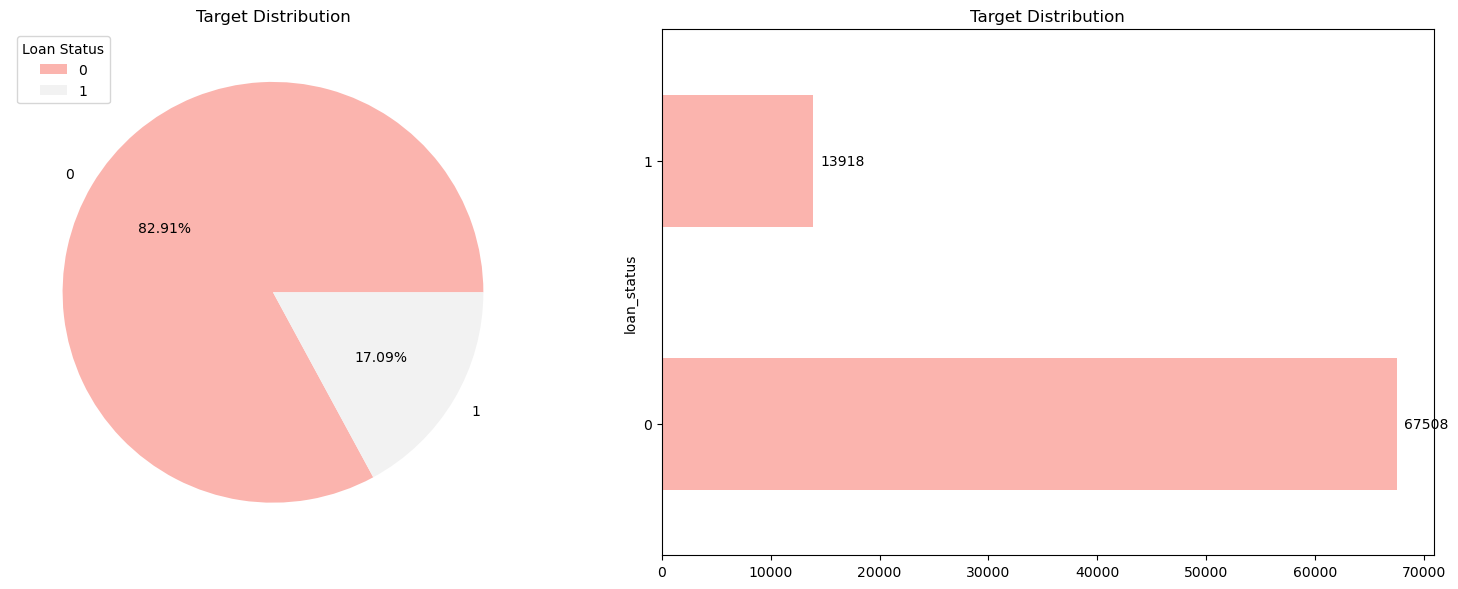

In [27]:
# Statistic of targets
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart with percentages
merged_df[tar_col].value_counts().plot(kind='pie', ax=axs[0], autopct='%.2f%%', cmap='Pastel1', title = 'Target Distribution')
axs[0].set_ylabel('')
axs[0].legend(title='Loan Status', loc='upper left')

# Horizontal bar chart with data labels
target_counts = merged_df[tar_col].value_counts().sort_index()
target_counts.plot(kind='barh', ax=axs[1], cmap='Pastel1', title = 'Target Distribution')

# Add data labels
for i, (index, value) in enumerate(target_counts.items()):
    axs[1].text(value + max(target_counts)*0.01, i, f'{value}', va='center')

plt.tight_layout()
plt.show()

It can be seen that the dataset is highly imbalanced, with over 82% of samples belonging to label 0: On time payment. This indicates a positive aspect — the low proportion of Late payment at around 17%. However, it also poses a potential risk that the model may not perform well in predicting label 1.

### 2.3 Univariate Analysis

#### 2.3.1 Cat cols

**Review 'home_ownership' column**

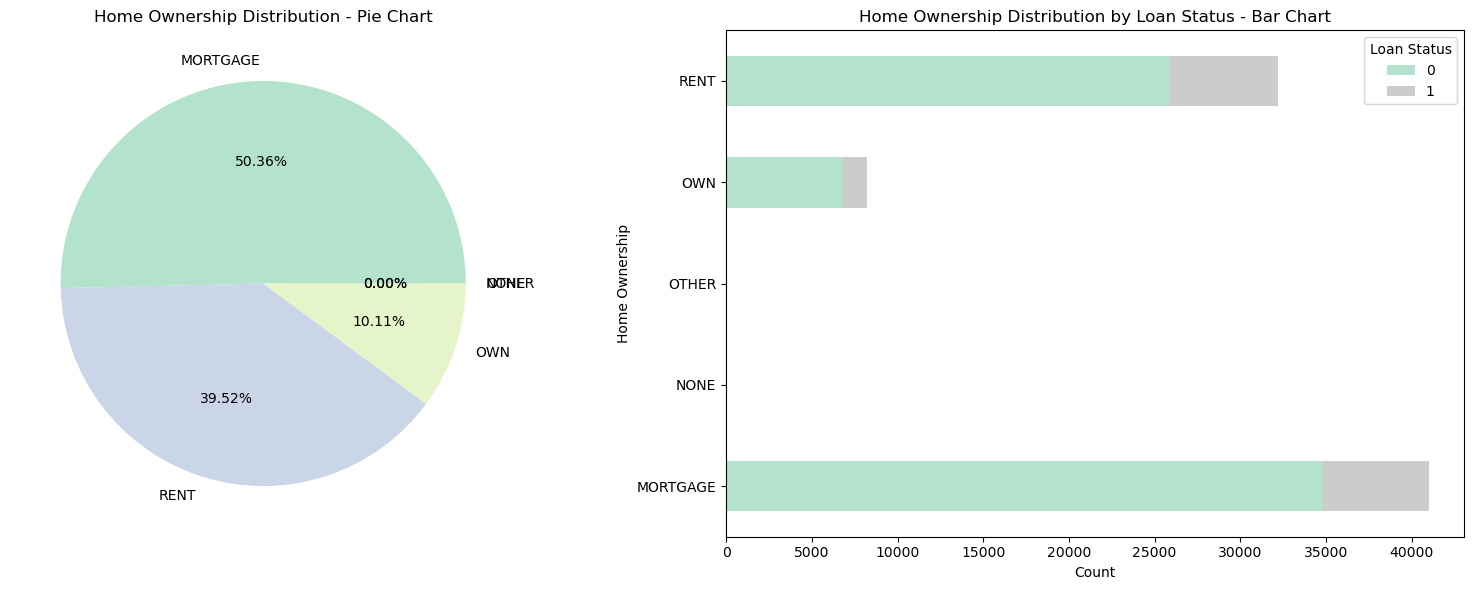

Count of Loan Status by Home Ownership Category:
loan_status     Loan Status: 0  Loan Status: 1
home_ownership                                
MORTGAGE                 34837            6171
NONE                         2               0
OTHER                        3               1
OWN                       6816            1420
RENT                     25850            6326
Percentage of Loan Status by Home Ownership Category:
loan_status     Loan Status: 0  Loan Status: 1
home_ownership                                
MORTGAGE                 84.95           15.05
NONE                    100.00            0.00
OTHER                    75.00           25.00
OWN                      82.76           17.24
RENT                     80.34           19.66


In [28]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['home_ownership'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Home Ownership Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart with 'loan_status' as hue
ho_counts = merged_df.groupby(['home_ownership', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
ho_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Home Ownership Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Home Ownership')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
ho_percentage = merged_df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
ho_counts = ho_counts.rename(columns=lambda x: f'Loan Status: {x}')
ho_percentage = ho_percentage.rename(columns=lambda x: f'Loan Status: {x}')
ho_percentage = ho_percentage.round(2)
print("Count of Loan Status by Home Ownership Category:")
print(ho_counts)
print('Percentage of Loan Status by Home Ownership Category:')
print(ho_percentage)

MORTGAGE is the most common home ownership status, followed by RENT, these two categories together account for over 89% of the total observations.

OWN represents a significant but smaller portion (10.11%) of the data.

NONE, OTHER are negligible, with a combined proportion of only about 0.1%. Therefore, I will group them into a single category called "OTHERS".

The 'OTHER' category has a higher proportion of class 1 compared to other categories; however, in terms of quantity, this group consists of only 4 records, which can be considered noise. Therefore, it can be concluded that there appears to be no significant relationship between 'home_ownership' and 'loan_status'.

In [29]:
merged_df['home_ownership'] = merged_df['home_ownership'].replace(['NONE', 'ANY', 'OTHER'], 'OTHERS')

**Review 'verification_status' column**

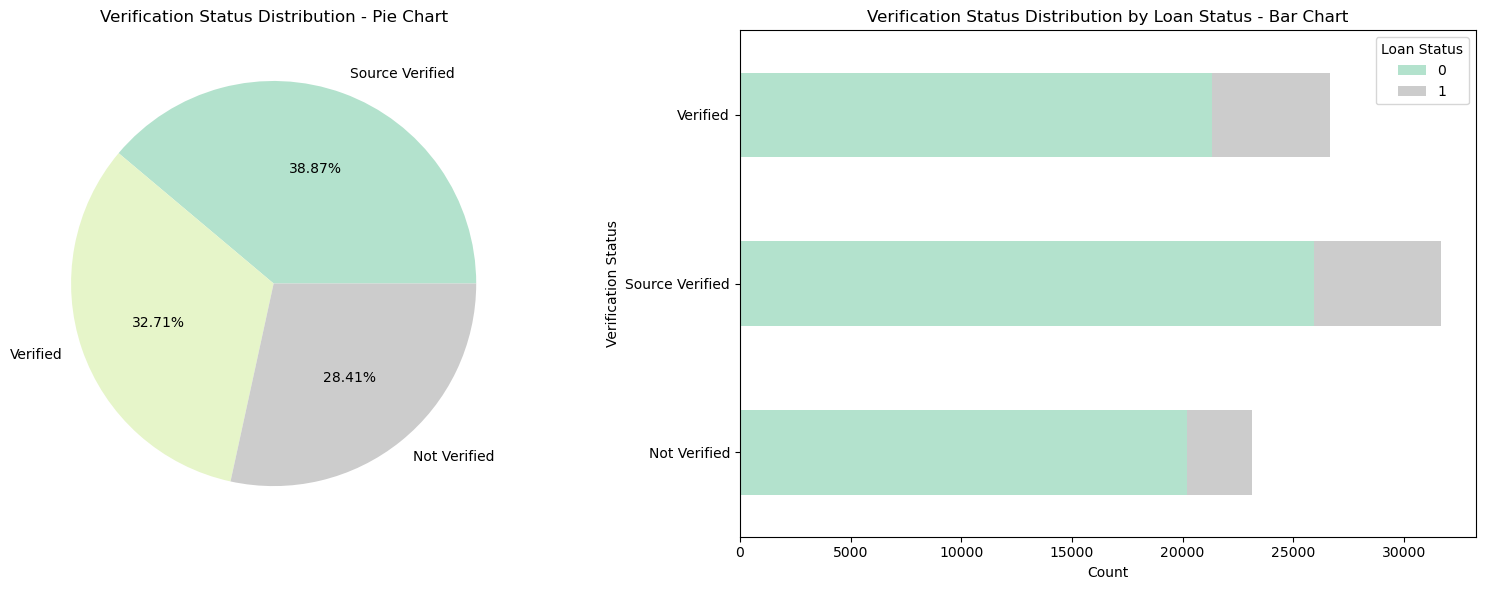

Count of Loan Status by Verification Status Category:
loan_status          Loan Status: 0  Loan Status: 1
verification_status                                
Not Verified                  20212            2925
Source Verified               25948            5704
Verified                      21348            5289
Percentage of Loan Status by Verification Status Category:
loan_status          Loan Status: 0  Loan Status: 1
verification_status                                
Not Verified                  87.36           12.64
Source Verified               81.98           18.02
Verified                      80.14           19.86


In [30]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['verification_status'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Verification Status Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
vs_counts = merged_df.groupby(['verification_status', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
vs_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Verification Status Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Verification Status')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
vs_percentage = merged_df.groupby('verification_status')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
vs_counts = vs_counts.rename(columns=lambda x: f'Loan Status: {x}')
vs_percentage = vs_percentage.rename(columns=lambda x: f'Loan Status: {x}')
vs_percentage = vs_percentage.round(2)
print('Count of Loan Status by Verification Status Category:')
print(vs_counts)
print('Percentage of Loan Status by Verification Status Category:')
print(vs_percentage)

Source Verified and Not Verified are the most prevalent verification statuses, accounting for over 71.59% of the data.

Verified represents a smaller but significant portion (28.41% ).

The verification status appears to be a strong indicator of loan risk. Loans that are fully 'Verified' are more than 1.5 times as likely to be in 'Loan Status' 1 compared to loans that are 'Not Verified'. 'Source Verified' loans fall in between but are also notably riskier than 'Not Verified' loans.

In conclusion, the level of income verification is a significant factor related to loan status, with more thoroughly verified loans exhibiting a higher propensity to be in 'Loan Status' 1 in this dataset. This suggests that verification_status could be a valuable feature for a predictive model.

**Review 'profession' column**

In [31]:
# Define mapping dictionary for semantic grouping
profession_mapping = {
    'Admin/Assistant/Support/Services': 'Corporate Admin & Support',
    'Agent/Legal/Insuarance': 'Business, Finance & HR',
    'Civil Servant': 'Public Service & Education',
    'Clerk': 'Corporate Admin & Support',
    'Consultant': 'Business, Finance & HR',
    'Convenience Services': 'Sales, Service & F&B',
    'Coordinator': 'Corporate Admin & Support',
    'Counselor/Therapist': 'Public Service & Education',
    'Educator/Teaching': 'Public Service & Education',
    'Financial/Accounting/Analyst': 'Business, Finance & HR',
    'Food and Beverage': 'Sales, Service & F&B',
    'Healthcare/Medical': 'Healthcare',
    'Human Resources': 'Business, Finance & HR',
    'IT/Technician/Engineer': 'Tech, Engineering & Logistics',
    'Logistics/Delivery/Driver': 'Tech, Engineering & Logistics',
    'Management/Specialist/Supervisor': 'Leadership & Management',
    'Manufacture/Distributor': 'Production & Skilled Trade',
    'Mechanic/Maintenance': 'Tech, Engineering & Logistics',
    'No Information': 'No Information',
    'Operations': 'Corporate Admin & Support',
    'Others': 'Others',
    'Production/Assembler': 'Production & Skilled Trade',
    'Representative/Relations': 'Sales, Service & F&B',
    'Sales/Marketing': 'Sales, Service & F&B',
    'Security': 'Production & Skilled Trade',
    'Worker': 'Production & Skilled Trade'
}

# Apply the mapping to the DataFrame
merged_df['profession'] = merged_df['profession'].map(profession_mapping)

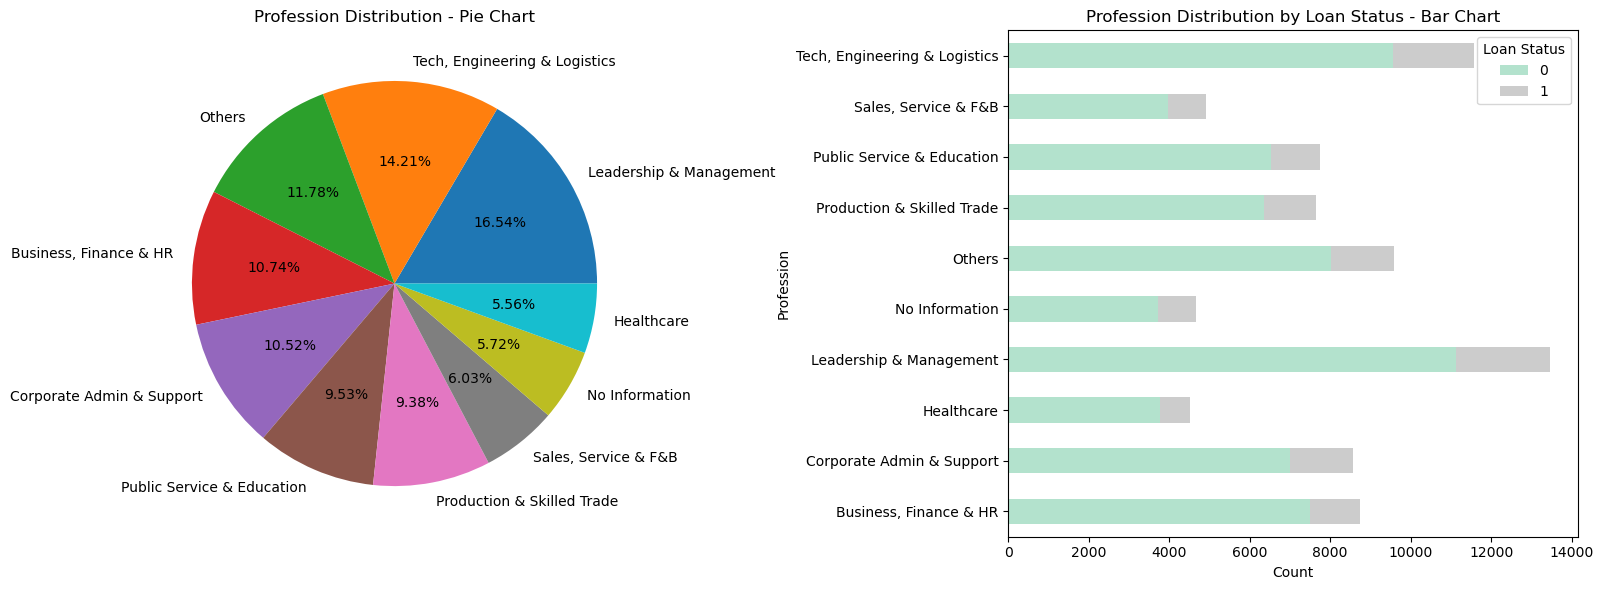

Count of Loan Status by Profession Category:
loan_status                    Loan Status: 0  Loan Status: 1
profession                                                   
Business, Finance & HR                   7493            1250
Corporate Admin & Support                6989            1574
Healthcare                               3766             760
Leadership & Management                 11130            2341
No Information                           3713             944
Others                                   8008            1582
Production & Skilled Trade               6348            1293
Public Service & Education               6517            1242
Sales, Service & F&B                     3973             936
Tech, Engineering & Logistics            9571            1996
Percentage of Loan Status by Profession Category:
loan_status                    Loan Status: 0  Loan Status: 1
profession                                                   
Business, Finance & HR               

In [32]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['profession'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Profession Distribution - Pie Chart')
axs[0].set_ylabel('')  

# Horizontal bar chart
profession_counts = merged_df.groupby(['profession', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
profession_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Profession Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Profession')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
profession_percentage = merged_df.groupby('profession')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
profession_counts = profession_counts.rename(columns=lambda x: f'Loan Status: {x}')
profession_percentage = profession_percentage.rename(columns=lambda x: f'Loan Status: {x}')
profession_percentage = profession_percentage.round(2)
print('Count of Loan Status by Profession Category:')
print(profession_counts)
print('Percentage of Loan Status by Profession Category:')
print(profession_percentage)

After processing the data from the 'emp_title' column, which had 77,000 unique values, and performing clustering using KMeans, grouping again, the resulting 'profession' column has 10 unique values. 

Leadership & Management is the most prevalent profession, accounting for over 16% of the data, 5.72% of customers have no occupation information and 11.78% belong to small-sized categories that have been grouped into the 'Others' category.

"No Infomation" is the group with the highest proportion of class 1 (20.27%). There is a possibility that this group of customers has unstable occupations, so they did not declare their occupation when filling out the form. Therefore, I keep the 'No Information' label instead of treating it as a missing value. On the contrary, 'Business, Finance & HR' has a significantly lower proportion of class 1 (14.3%). 'Profession' could be a potential feature for the model.

**Review 'job_level' column**

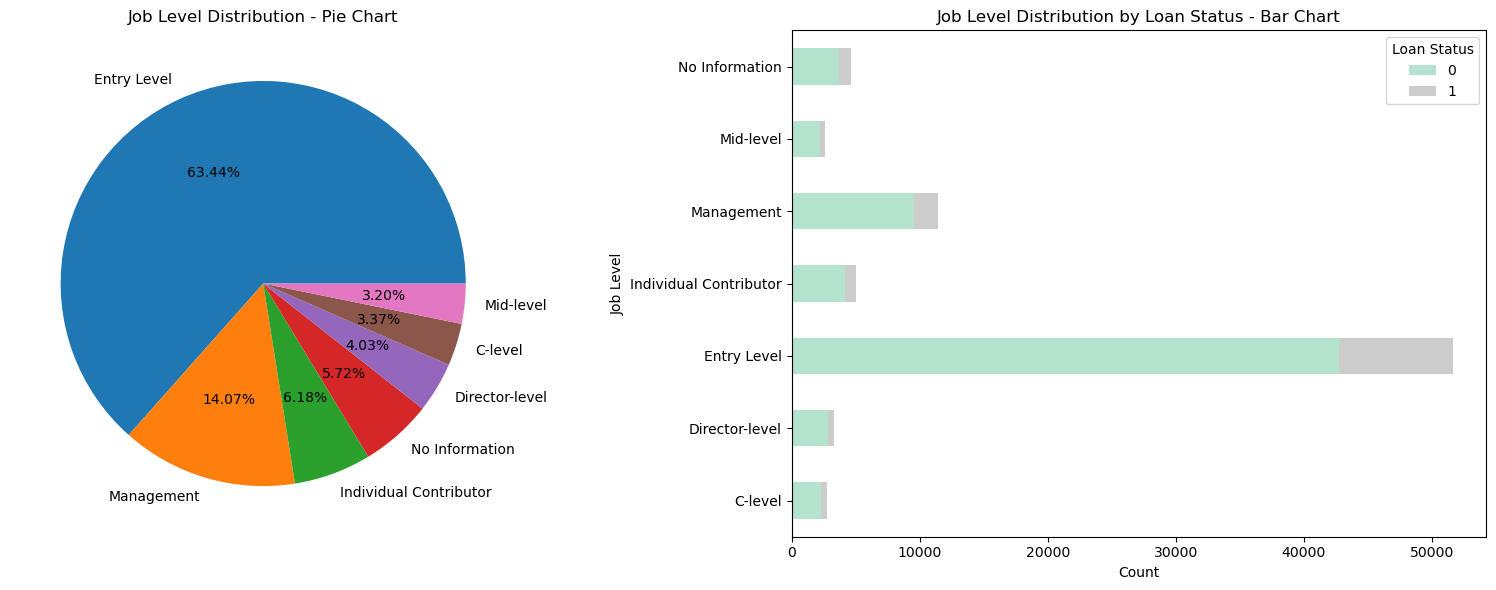

Count of Loan Status by Job Level Category:
loan_status             Loan Status: 0  Loan Status: 1
job_level                                             
C-level                           2297             443
Director-level                    2854             428
Entry Level                      42736            8923
Individual Contributor            4138             892
Management                        9562            1891
Mid-level                         2208             397
No Information                    3713             944
Percentage of Loan Status by Job Level Category:
loan_status             Loan Status: 0  Loan Status: 1
job_level                                             
C-level                          83.83           16.17
Director-level                   86.96           13.04
Entry Level                      82.73           17.27
Individual Contributor           82.27           17.73
Management                       83.49           16.51
Mid-level                  

In [33]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['job_level'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Job Level Distribution - Pie Chart')
axs[0].set_ylabel('')  

# Horizontal bar chart
job_level_counts = merged_df.groupby(['job_level', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
job_level_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Job Level Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Job Level')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
job_level_percentage = merged_df.groupby('job_level')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
job_level_counts = job_level_counts.rename(columns=lambda x: f'Loan Status: {x}')
job_level_percentage = job_level_percentage.rename(columns=lambda x: f'Loan Status: {x}')
job_level_percentage = job_level_percentage.round(2)
print('Count of Loan Status by Job Level Category:')
print(job_level_counts)
print('Percentage of Loan Status by Job Level Category:')
print(job_level_percentage)

"No Information" are the groups with the highest proportion of class 1 (20.27%).  On the contrary, 'Director' has a significantly lower proportion of class 1 (13.04%). This is understandable, as lower job levels may indicate less financial stability and a higher risk of default. This could be a potential feature for the model.

**Review 'subregion' column**

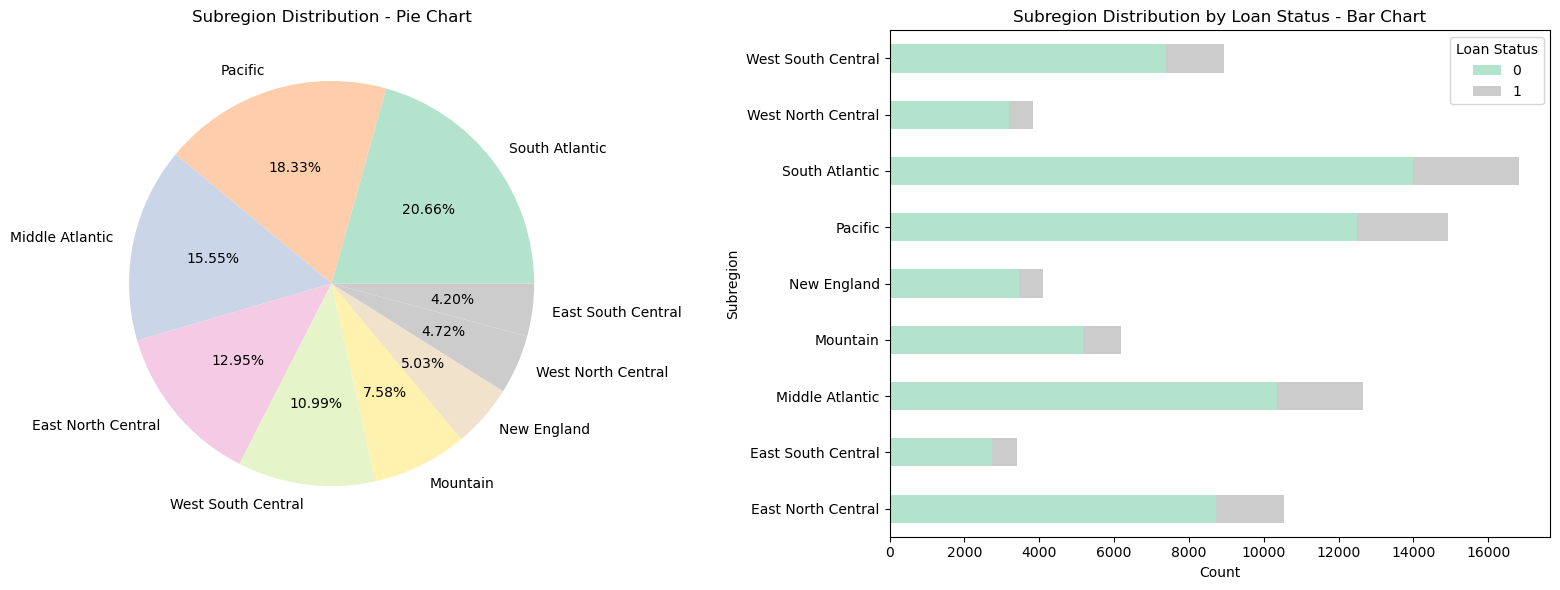

Count of Loan Status by Subregion Category:
loan_status         Loan Status: 0  Loan Status: 1
subregion                                         
East North Central            8722            1819
East South Central            2745             674
Middle Atlantic              10347            2314
Mountain                      5174            1001
New England                   3456             636
Pacific                      12499            2423
South Atlantic               13989            2834
West North Central            3194             649
West South Central            7382            1568
Percentage of Loan Status by Subregion Category:
loan_status         Loan Status: 0  Loan Status: 1
subregion                                         
East North Central           82.74           17.26
East South Central           80.29           19.71
Middle Atlantic              81.72           18.28
Mountain                     83.79           16.21
New England                  84.46      

In [34]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['subregion'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Subregion Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
sr_counts = merged_df.groupby(['subregion', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
sr_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Subregion Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Subregion')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
sr_percentage = merged_df.groupby('subregion')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
sr_counts = sr_counts.rename(columns=lambda x: f'Loan Status: {x}')
sr_percentage = sr_percentage.rename(columns=lambda x: f'Loan Status: {x}')
sr_percentage = sr_percentage.round(2)
print('Count of Loan Status by Subregion Category:')
print(sr_counts)
print('Percentage of Loan Status by Subregion Category:')
print(sr_percentage)

Although there is some variation in default rates, the range of these rates across all subregions is relatively narrow. There appears to be no significant relationship between 'subregion' and 'loan_status'.

**Review 'term' column**

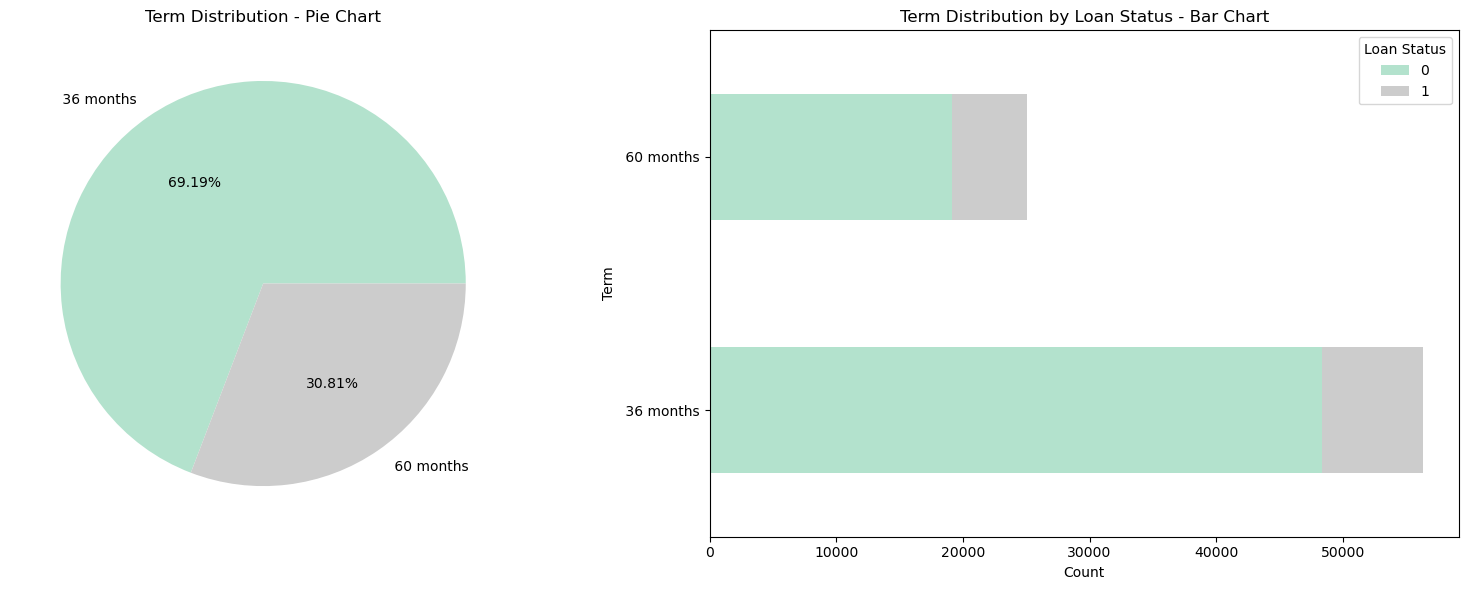

Count of Loan Status by Term Category:
loan_status  Loan Status: 0  Loan Status: 1
term                                       
36 months             48389            7946
60 months             19119            5972
Percentage of Loan Status by Term Category:
loan_status  Loan Status: 0  Loan Status: 1
term                                       
36 months              85.9            14.1
60 months              76.2            23.8


In [35]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['term'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Term Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
term_counts = merged_df.groupby(['term', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
term_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Term Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Term')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
term_percentage = merged_df.groupby('term')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
term_counts = term_counts.rename(columns=lambda x: f'Loan Status: {x}')
term_percentage = term_percentage.rename(columns=lambda x: f'Loan Status: {x}')
term_percentage = term_percentage.round(2)
print('Count of Loan Status by Term Category:')
print(term_counts)
print('Percentage of Loan Status by Term Category:')
print(term_percentage)

'36 months' is the most prevalent loan term, accounting for 69.19% of the data, while the remaining 30.81% belong to '60 months' term

Loans with a term of '60 months' account for only about half the proportion compared to those with a '36 months' term, but they have more than 1.6 times the proportion of 'Loan Status' 1. This indicates that longer-term loans tend to carry higher risk.

**Review 'grade' column**

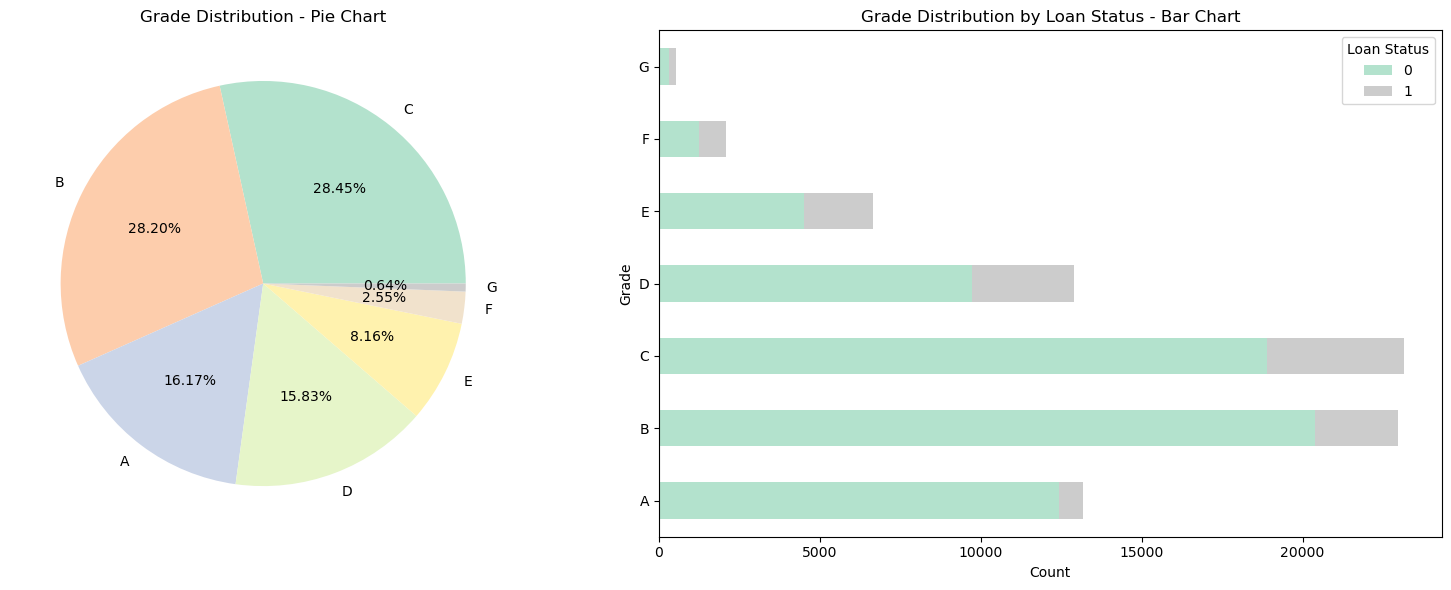

Count of Loan Status by Grade Category:
loan_status  Loan Status: 0  Loan Status: 1
grade                                      
A                     12428             737
B                     20384            2581
C                     18903            4262
D                      9731            3160
E                      4519            2126
F                      1241             836
G                       302             216
Percentage of Loan Status by Grade Category:
loan_status  Loan Status: 0  Loan Status: 1
grade                                      
A                     94.40            5.60
B                     88.76           11.24
C                     81.60           18.40
D                     75.49           24.51
E                     68.01           31.99
F                     59.75           40.25
G                     58.30           41.70


In [36]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['grade'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Grade Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
grade_counts = merged_df.groupby(['grade', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
grade_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Grade Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Grade')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
grade_percentage = merged_df.groupby('grade')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
grade_counts = grade_counts.rename(columns=lambda x: f'Loan Status: {x}')
grade_percentage = grade_percentage.rename(columns=lambda x: f'Loan Status: {x}')
grade_percentage = grade_percentage.round(2)
print('Count of Loan Status by Grade Category:')
print(grade_counts)
print('Percentage of Loan Status by Grade Category:')
print(grade_percentage)

89% of the data belongs to groups A, B, C, and D, while only about 11% belongs to the remaining three groups E, F, and G.

Loan Grade is a highly predictive feature for determining loan status. Lower grades (D, E, F, G) are associated with considerably higher risk of default compared to higher grades (A, B, C). This monotonic trend makes 'Grade' a potentially crucial variable for credit risk assessment and modeling.

**Review 'emp_length' column**

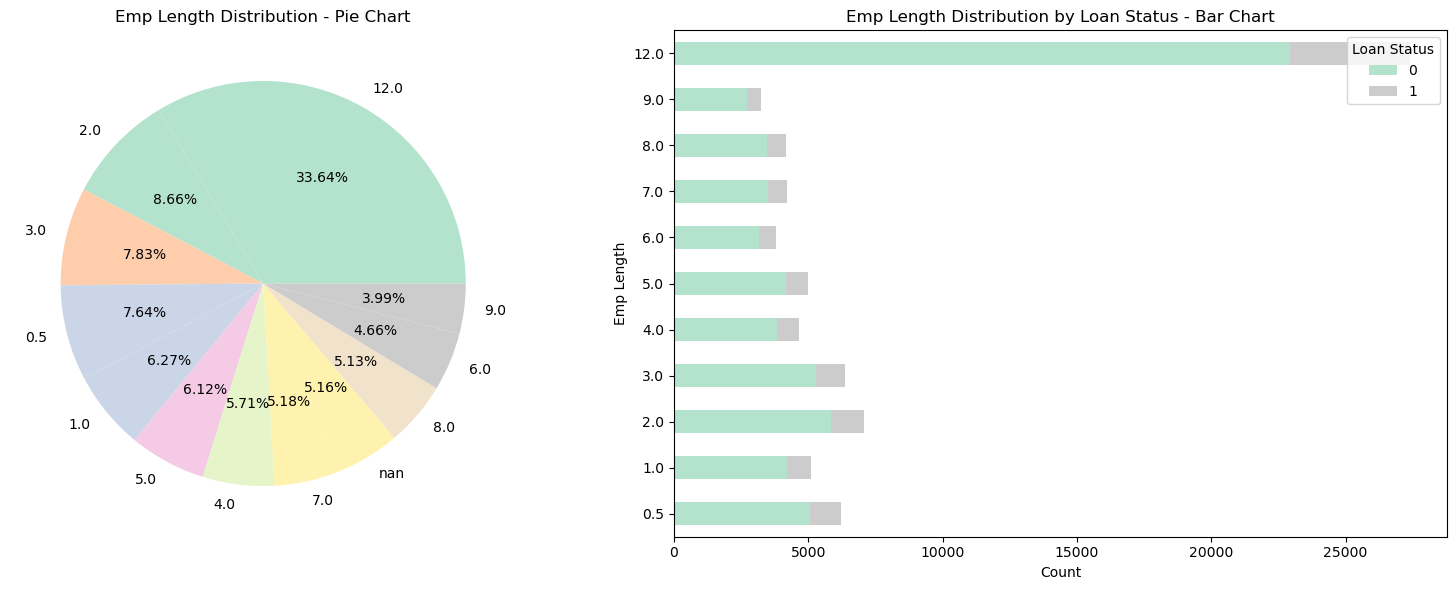

Count of Loan Status by Emp Length Category:
loan_status  Loan Status: 0  Loan Status: 1
emp_length                                 
0.5                    5061            1164
1.0                    4191             917
2.0                    5853            1202
3.0                    5295            1082
4.0                    3842             805
5.0                    4179             801
6.0                    3163             630
7.0                    3508             708
8.0                    3460             720
9.0                    2700             550
12.0                  22929            4466
Percentage of Loan Status by Emp Length Category:
loan_status  Loan Status: 0  Loan Status: 1
emp_length                                 
0.5                   81.30           18.70
1.0                   82.05           17.95
2.0                   82.96           17.04
3.0                   83.03           16.97
4.0                   82.68           17.32
5.0                   83.

In [37]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['emp_length'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Emp Length Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
emp_length_counts = merged_df.groupby(['emp_length', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
emp_length_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Emp Length Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Emp Length')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
emp_length_percentage = merged_df.groupby('emp_length')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
emp_length_counts = emp_length_counts.rename(columns=lambda x: f'Loan Status: {x}')
emp_length_percentage = emp_length_percentage.rename(columns=lambda x: f'Loan Status: {x}')
emp_length_percentage = emp_length_percentage.round(2)
print('Count of Loan Status by Emp Length Category:')
print(emp_length_counts)
print('Percentage of Loan Status by Emp Length Category:')
print(emp_length_percentage)

Customers with more than 10 years of work experience have the lowest proportion of class 1, however, there is not much difference between customers with different lengths of employment. There appears to be no significant relationship between 'emp_length' and 'loan_status'.

**Review 'type' column**

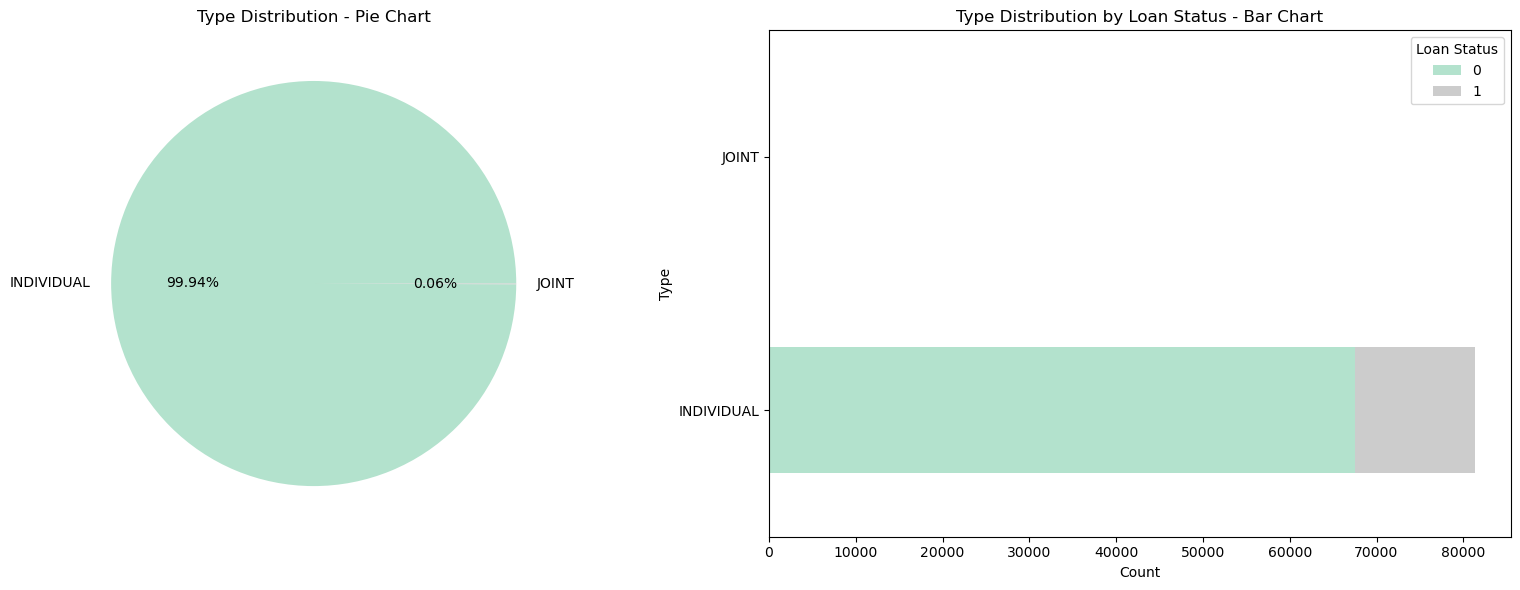

Count of Loan Status by Type Category:
loan_status  Loan Status: 0  Loan Status: 1
type                                       
INDIVIDUAL            67472           13904
JOINT                    36              14
Percentage of Loan Status by Type Category:
loan_status  Loan Status: 0  Loan Status: 1
type                                       
INDIVIDUAL            82.91           17.09
JOINT                 72.00           28.00


In [38]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['type'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Type Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
type_counts = merged_df.groupby(['type', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
type_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Type Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Type')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
type_percentage = merged_df.groupby('type')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
type_counts = type_counts.rename(columns=lambda x: f'Loan Status: {x}')
type_percentage = type_percentage.rename(columns=lambda x: f'Loan Status: {x}')
type_percentage = type_percentage.round(2)
print('Count of Loan Status by Type Category:')
print(type_counts)
print('Percentage of Loan Status by Type Category:')
print(type_percentage)

The dataset is severely imbalanced, 99.94% of the data belongs to the 'INDIVIDUAL' group, while only 0.06% belongs to the remaining groups ('JOINT'). Due to the extreme rarity of the 'JOINT' category, it might not even be "seen" enough times during training to learn meaningful patterns.

In [39]:
# merged_df['type'] = merged_df['type'].replace(['DIRECT_PAY', 'JOINT'], 'NON_INDIVIDUAL')

In [40]:
# type_percentage = merged_df.groupby('type')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
# type_percentage = type_percentage.rename(columns=lambda x: f'Loan Status: {x}')
# type_percentage = type_percentage.round(2)

# print('Count of Loan Status by Type Category:')
# print(type_counts)
# print('Percentage of Loan Status by Type Category:')
# print(type_percentage)

**Review 'purpose' column**

In [41]:
# Define mapping dictionary for semantic grouping
purpose_mapping = {
    'debt_consolidation': 'debt_consolidation',
    'credit_card': 'credit_card',
    'home_improvement': 'home_related',
    'house': 'home_related',
    'medical': 'health',
    'car': 'auto',
    'wedding': 'personal_lifestyle',
    'vacation': 'personal_lifestyle',
    'moving': 'personal_lifestyle',
    'major_purchase': 'major_purchase',
    'small_business': 'business',
    'other': 'other',
    'renewable_energy': 'other'
}

# Apply the mapping to the DataFrame
merged_df['purpose'] = merged_df['purpose'].map(purpose_mapping)
merged_df['purpose'] = merged_df['purpose'].fillna('other')

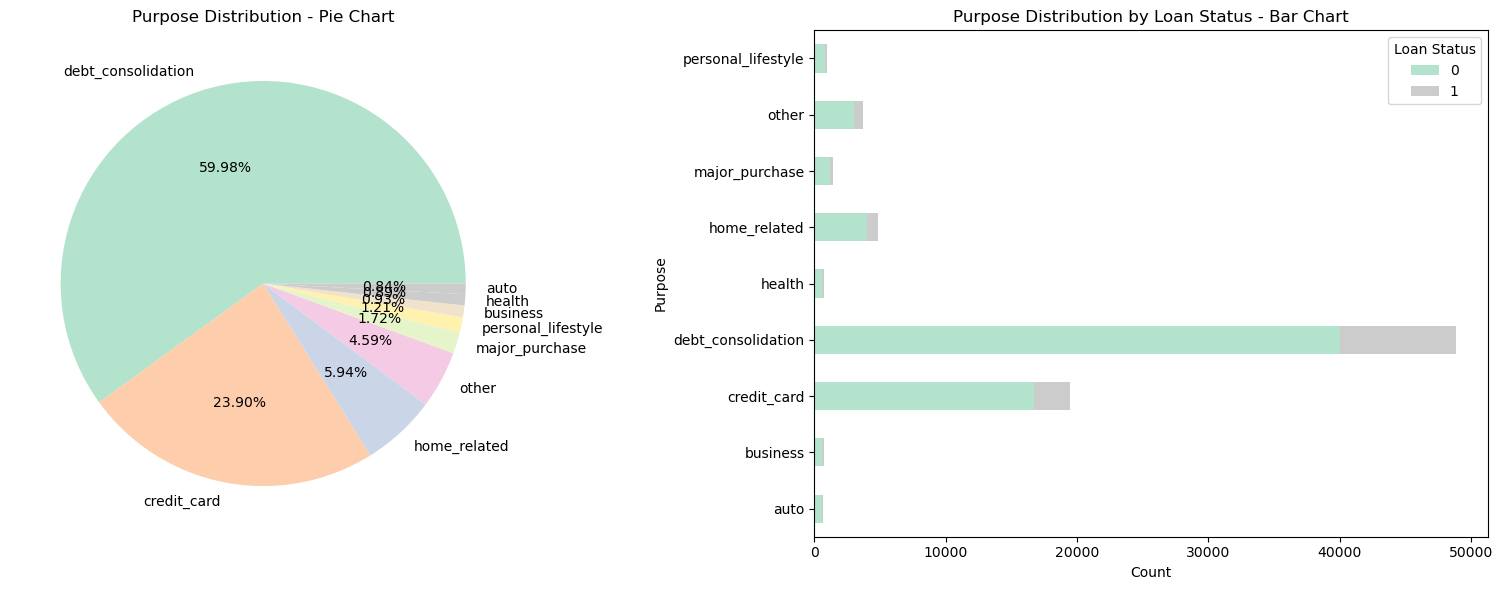

Count of Loan Status by Purpose Category:
loan_status         Loan Status: 0  Loan Status: 1
purpose                                           
auto                           593              90
business                       564             194
credit_card                  16721            2742
debt_consolidation           39975            8862
health                         605             122
home_related                  4025             812
major_purchase                1167             235
other                         3048             686
personal_lifestyle             810             175
Percentage of Loan Status by Purpose Category:
loan_status         Loan Status: 0  Loan Status: 1
purpose                                           
auto                         86.82           13.18
business                     74.41           25.59
credit_card                  85.91           14.09
debt_consolidation           81.85           18.15
health                       83.22          

In [42]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['purpose'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Purpose Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
purpose_counts = merged_df.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
purpose_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Purpose Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Purpose')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
purpose_percentage = merged_df.groupby('purpose')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
purpose_counts = purpose_counts.rename(columns=lambda x: f'Loan Status: {x}')
purpose_percentage = purpose_percentage.rename(columns=lambda x: f'Loan Status: {x}')
purpose_percentage = purpose_percentage.round(2)
print('Count of Loan Status by Purpose Category:')
print(purpose_counts)
print('Percentage of Loan Status by Purpose Category:')
print(purpose_percentage)

59.98% of customers took out loans for the purpose of 'debt_consolidation', and 23.90% for 'credit_card' purposes, while the remaining 17% borrowed for other purposes.

- Highest Risk Purposes: 'Business' loans show the highest percentage of 'Loan Status' 1 at 25.59%. 'Other' (18.37%) and 'Debt Consolidation' (18.15%) loans also exhibit relatively higher default rates compared to the overall average.

- Lowest Risk Purposes: 'Auto' loans have the lowest percentage of 'Loan Status' 1 at 13.18%. 'Credit Card' loans, despite being a very common purpose, also have a relatively low default rate of 14.09%.

The purpose of the loan provides some indication of the associated risk. Loans for 'business', 'other', and 'debt consolidation' tend to have higher default rates, while loans for 'auto' and 'credit card' consolidation show lower default rates in this dataset. This makes 'Purpose' a potentially useful categorical feature for predicting loan status.

#### 2.3.1 Num cols

In [43]:
# statistics of num cols
merged_df[num_cols].describe()

emp_length    avg_cur_bal   Tot_cur_bal   loan_amount      int_rate  \
count  77226.000000   81426.000000  8.142600e+04  81426.000000  81426.000000   
mean       6.845486   13271.463169  1.390987e+05  15014.095621      0.133168   
std        4.394070   15957.313943  1.535651e+05   8439.872249      0.044229   
min        0.500000       0.000000  0.000000e+00   1000.000000      0.053200   
25%        3.000000    3138.000000  2.985850e+04   8425.000000      0.099900   
50%        7.000000    7352.000000  8.059050e+04  13575.000000      0.129900   
75%       12.000000   18431.750000  2.078412e+05  20000.000000      0.162900   
max       12.000000  555925.000000  4.447397e+06  35000.000000      0.289900   

        installment   issue_month  issue_quarter  issue_year_num  \
count  81426.000000  81426.000000   81426.000000    81426.000000   
mean     443.736108      7.099379       2.730565     2014.285793   
std      244.327605      3.394966       1.109315        0.851983   
min       29.520000      1.000000       1.000000     2012.000000   
25%      267.209990      4.000000       2.000000     2014.000000   
50%      388.109990      7.000000       3.000000     2015.000000   
75%      580.349980     10.000000       4.000000     2015.000000   
max     1424.569900     12.000000       4.000000     2015.000000   

       loan_age_days     total_inc  
count   81426.000000  8.142600e+04  
mean      439.965723  7.566194e+04  
std       316.649433  6.737378e+04  
min        30.000000  4.000000e+03  
25%       183.000000  4.600000e+04  
50%       364.000000  6.500000e+04  
75%       670.000000  9.000000e+04  
max      1247.000000  8.900060e+06

**Review 'issue_year_num' column**

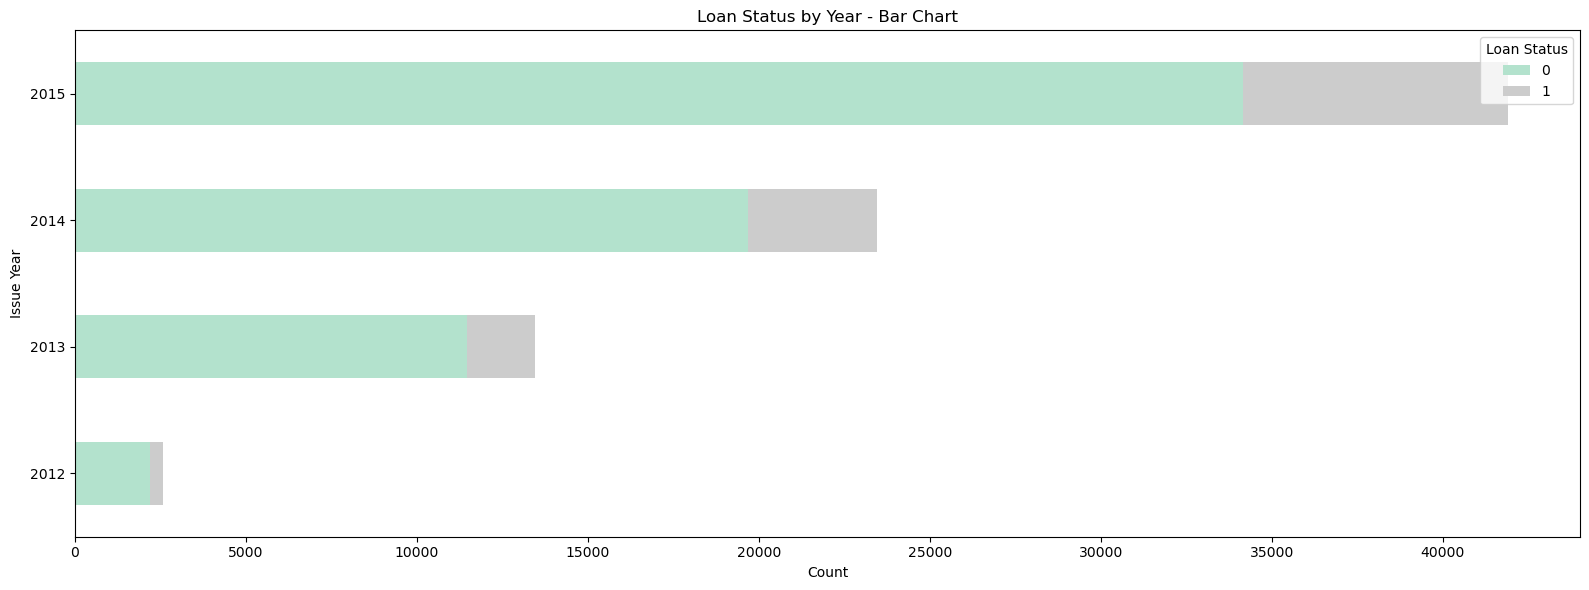

Count of Loan Status by Issue Year:
loan_status     Loan Status: 0  Loan Status: 1
issue_year_num                                
2012                      2200             394
2013                     11459            2001
2014                     19693            3760
2015                     34156            7763
Percentage of Loan Status by Issue Year:
loan_status     Loan Status: 0  Loan Status: 1
issue_year_num                                
2012                     84.81           15.19
2013                     85.13           14.87
2014                     83.97           16.03
2015                     81.48           18.52


In [44]:
fig, ax = plt.subplots(figsize=(16, 6))

# Horizontal bar chart with 'loan_status' as hue
loan_counts = merged_df.groupby(['issue_year_num', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
loan_counts.plot(kind='barh', stacked=True, ax=ax, cmap='Pastel2')
ax.set_title('Loan Status by Year - Bar Chart')
ax.set_ylabel('Issue Year')
ax.set_xlabel('Count')

# Add legend for loan status
ax.legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
loan_percentage = merged_df.groupby('issue_year_num')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
loan_counts = loan_counts.rename(columns=lambda x: f'Loan Status: {x}')
loan_percentage = loan_percentage.rename(columns=lambda x: f'Loan Status: {x}')
loan_percentage = loan_percentage.round(2)
print("Count of Loan Status by Issue Year:")
print(loan_counts)
print('Percentage of Loan Status by Issue Year:')
print(loan_percentage)

The number of loans and the late payment rate vary across years -> It is necessary to split the dataset by time when training and testing the model.

**Review 'issue_month' column**

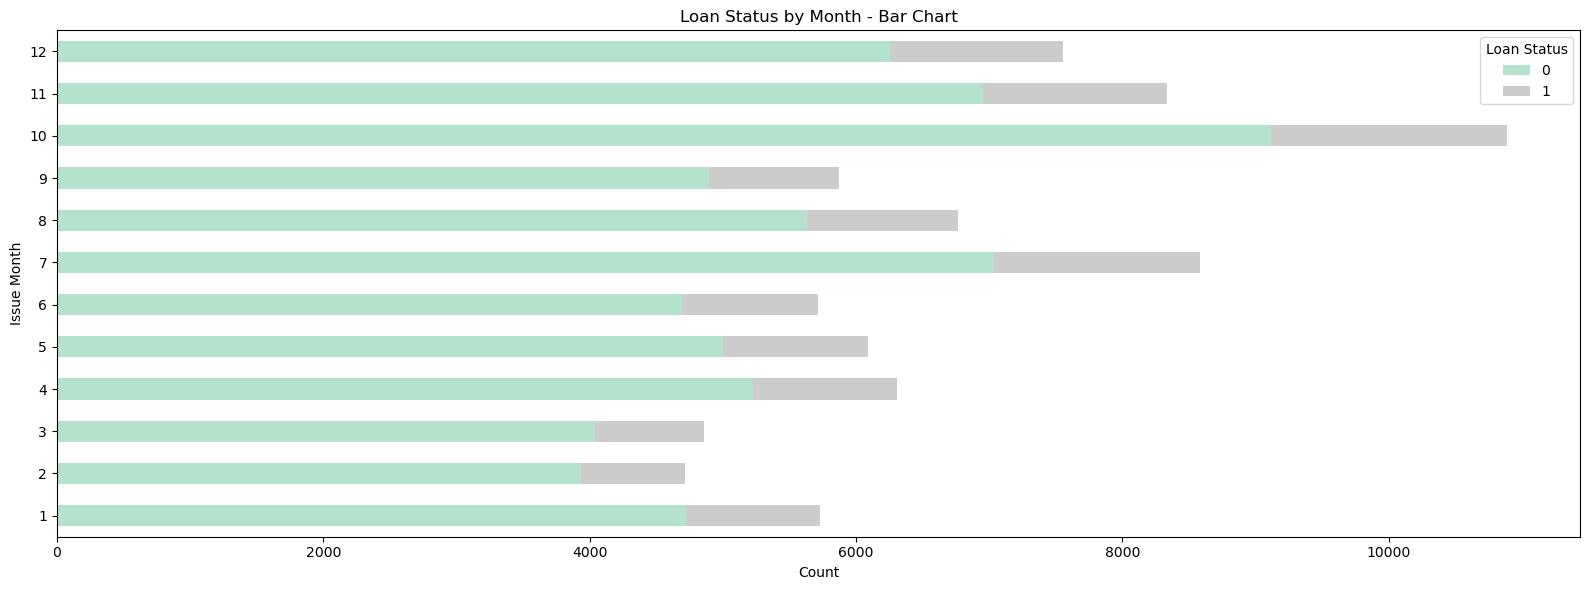

Count of Loan Status by Issue Month:
loan_status  Loan Status: 0  Loan Status: 1
issue_month                                
1                      4722            1007
2                      3936             781
3                      4040             817
4                      5226            1084
5                      5001            1093
6                      4690            1022
7                      7035            1547
8                      5631            1138
9                      4900             973
10                     9114            1779
11                     6957            1378
12                     6256            1299
Percentage of Loan Status by Issue Month:
loan_status  Loan Status: 0  Loan Status: 1
issue_month                                
1                     82.42           17.58
2                     83.44           16.56
3                     83.18           16.82
4                     82.82           17.18
5                     82.06           17.

In [45]:
fig, ax = plt.subplots(figsize=(16, 6))

# Horizontal bar chart with 'loan_status' as hue
loan_m_counts = merged_df.groupby(['issue_month', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
loan_m_counts.plot(kind='barh', stacked=True, ax=ax, cmap='Pastel2')
ax.set_title('Loan Status by Month - Bar Chart')
ax.set_ylabel('Issue Month')
ax.set_xlabel('Count')

# Add legend for loan status
ax.legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
loan_m_percentage = merged_df.groupby('issue_month')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
loan_m_counts = loan_m_counts.rename(columns=lambda x: f'Loan Status: {x}')
loan_m_percentage = loan_m_percentage.rename(columns=lambda x: f'Loan Status: {x}')
loan_m_percentage = loan_m_percentage.round(2)
print("Count of Loan Status by Issue Month:")
print(loan_m_counts)
print('Percentage of Loan Status by Issue Month:')
print(loan_m_percentage)

There is no strong correlation between issue_month and loan_status.

**Review 'issue_quarter' column**

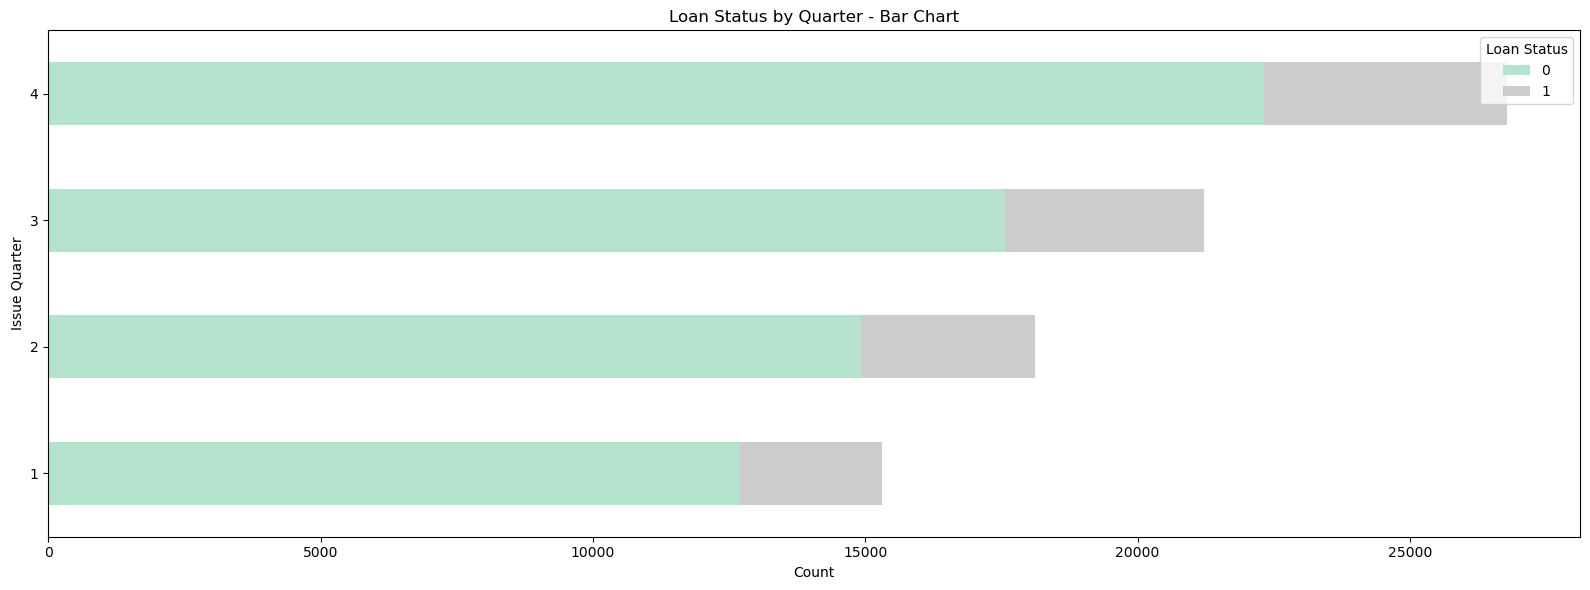

Count of Loan Status by Issue Quarter:
loan_status    Loan Status: 0  Loan Status: 1
issue_quarter                                
1                       12698            2605
2                       14917            3199
3                       17566            3658
4                       22327            4456
Percentage of Loan Status by Issue Quarter:
loan_status    Loan Status: 0  Loan Status: 1
issue_quarter                                
1                       82.98           17.02
2                       82.34           17.66
3                       82.76           17.24
4                       83.36           16.64


In [46]:
fig, ax = plt.subplots(figsize=(16, 6))

# Horizontal bar chart with 'loan_status' as hue
loan_q_counts = merged_df.groupby(['issue_quarter', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
loan_q_counts.plot(kind='barh', stacked=True, ax=ax, cmap='Pastel2')
ax.set_title('Loan Status by Quarter - Bar Chart')
ax.set_ylabel('Issue Quarter')
ax.set_xlabel('Count')

# Add legend for loan status
ax.legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
loan_q_percentage = merged_df.groupby('issue_quarter')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
loan_q_counts = loan_q_counts.rename(columns=lambda x: f'Loan Status: {x}')
loan_q_percentage = loan_q_percentage.rename(columns=lambda x: f'Loan Status: {x}')
loan_q_percentage = loan_q_percentage.round(2)
print("Count of Loan Status by Issue Quarter:")
print(loan_q_counts)
print('Percentage of Loan Status by Issue Quarter:')
print(loan_q_percentage)

There is no strong correlation between issue_quarter and loan_status.

**Review 'loan_amount' column**

<Axes: xlabel='loan_amount', ylabel='Density'>

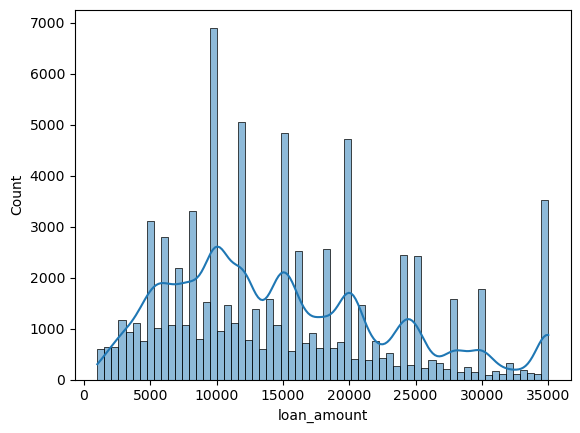

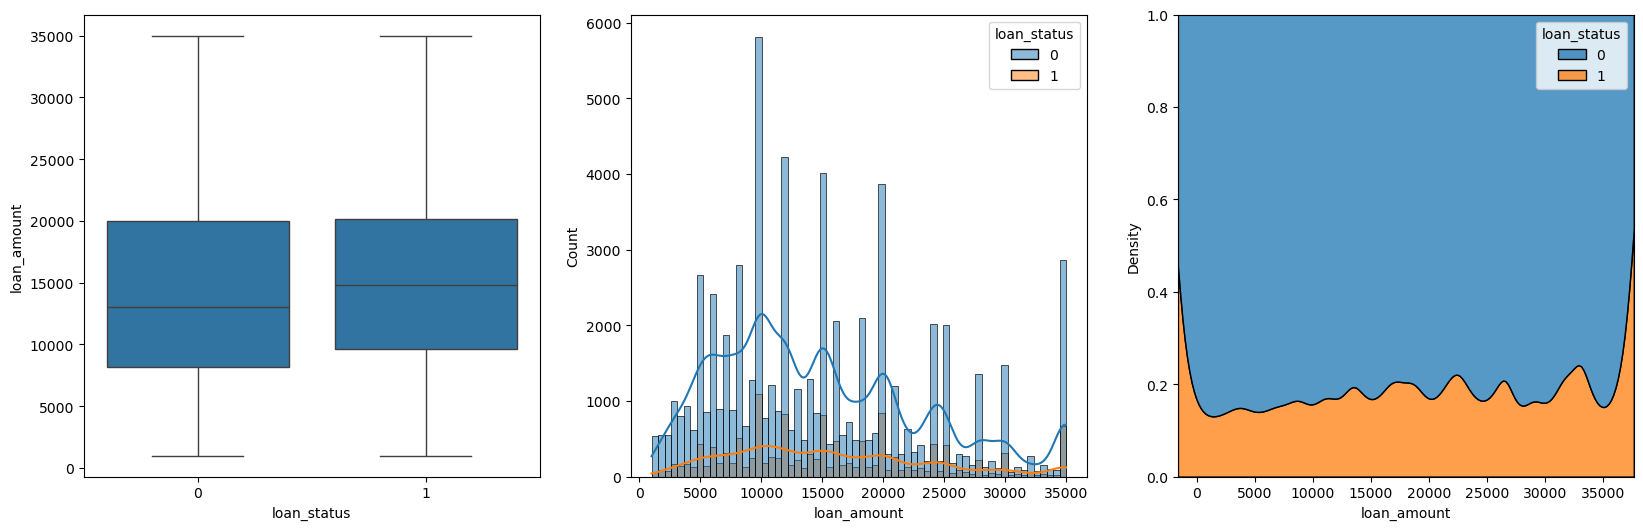

In [47]:
c = 'loan_amount'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

The data is heavily skewed to the left, indicating that most loans have smaller amounts. There are multiple peaks in the distribution, suggesting that loan amounts cluster around certain values (e.g., around 5000, 10000, 15000, etc.).

The Kernel Density Estimate (KDE) curve overlays the histogram, providing a smooth representation of the distribution. The long tail on the right indicates the presence of a few very large loan amounts, but these are less frequent.

There is no strong correlation between loan_amount and loan_status.

**Review 'total_inc' column**

<Axes: xlabel='total_inc', ylabel='Density'>

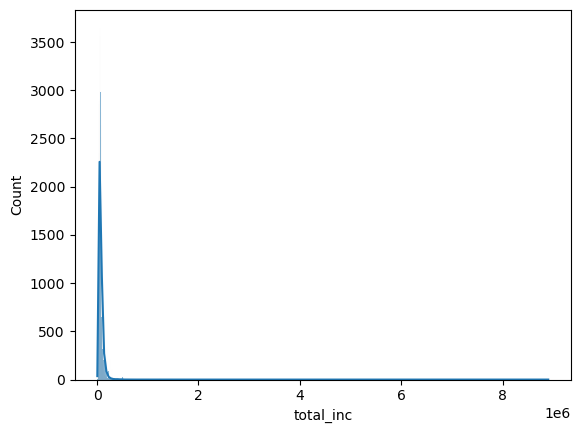

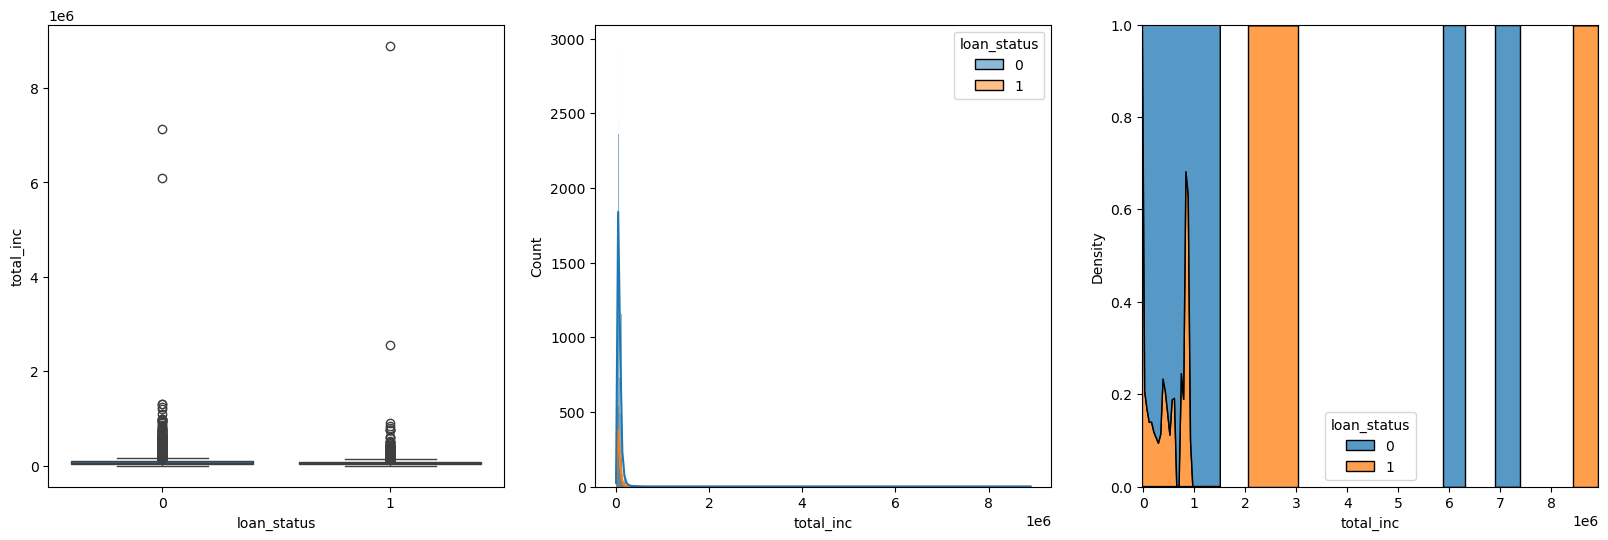

In [48]:
c = 'total_inc'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

The total_income distribution is highly skewed, with most individuals having low incomes and a few outliers with very high incomes. The long tail indicates the presence of extreme values, but these are rare.

There is no strong correlation between total_income and loan_status. Both defaulters and non-defaulters have similar income distributions, as evidenced by the overlapping box plots and KDE plots.

<Axes: xlabel='total_inc', ylabel='Density'>

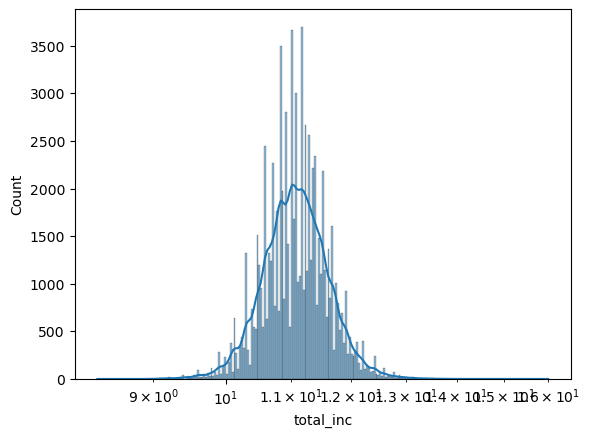

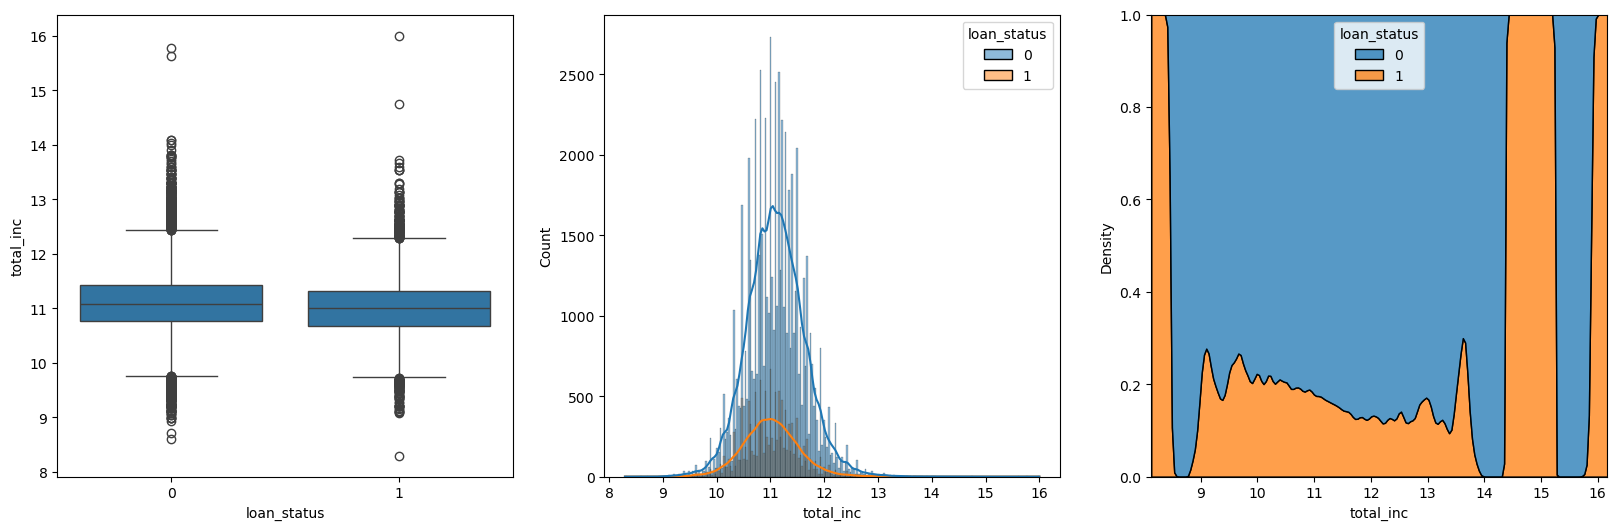

In [49]:
c = 'total_inc'

df1 = merged_df.copy()
df1[c] = np.log(df1[c]).fillna(-1)

sns.histplot(df1, x=c, kde=True, log_scale=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=df1, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=df1, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=df1, x=c, hue=tar_col, multiple='fill', ax=axs[2])

The log transformation reduces the skewness in the total_income distribution, making it more symmetric but it does not uncover a strong relationship with loan_status.

**Review 'avg_cur_bal' column**

<Axes: xlabel='avg_cur_bal', ylabel='Density'>

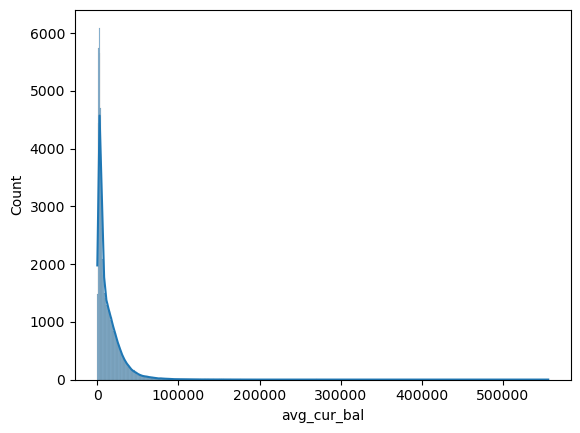

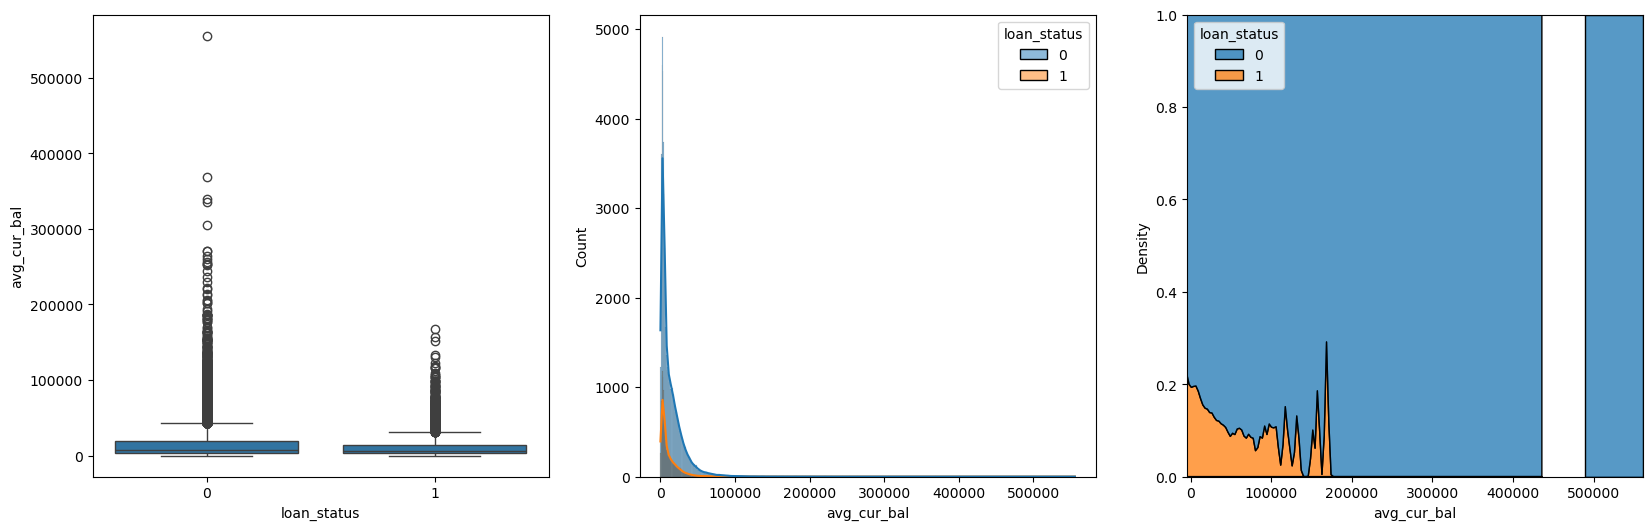

In [50]:
c = 'avg_cur_bal'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

<Axes: xlabel='avg_cur_bal', ylabel='Density'>

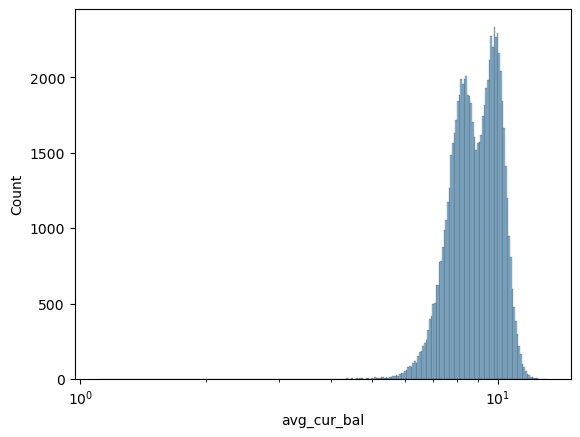

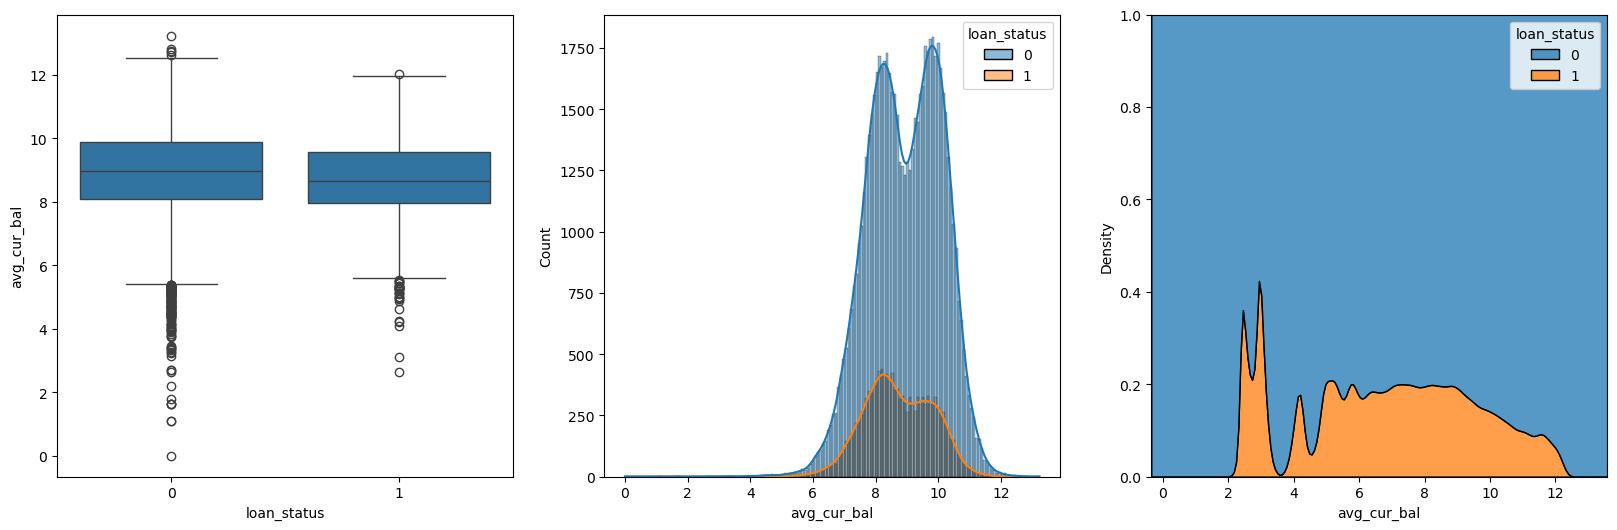

In [51]:
c = 'avg_cur_bal'

df1[c] = np.log(df1[c]).fillna(-1)

sns.histplot(df1, x=c, kde=True, log_scale=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=df1, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=df1, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=df1, x=c, hue=tar_col, multiple='fill', ax=axs[2])

'avg_cur_bal' is heavily skewed, with most individuals having very low average current balances. The log transformation successfully reduces the skewness in the 'avg_cur_bal' distribution, and now it's roughly bell-shaped with two peaks (bimodal).

Even after transformation, the distributions of the two loan statuses still overlap a lot, meaning 'avg_cur_bal' alone isn’t a strong separator for predicting loan status. But people who default tend to cluster a bit lower on the balance scale.

**Review 'Tot_cur_bal' column**

<Axes: xlabel='Tot_cur_bal', ylabel='Density'>

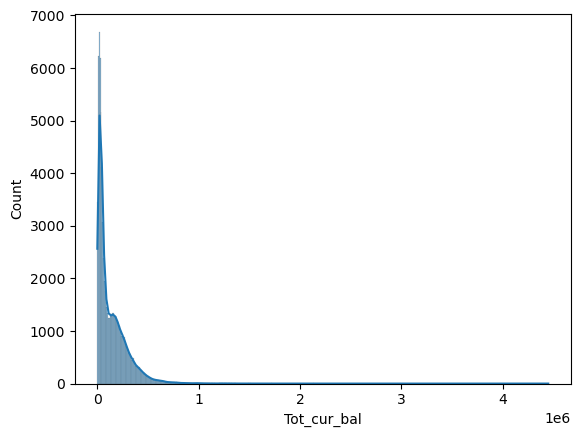

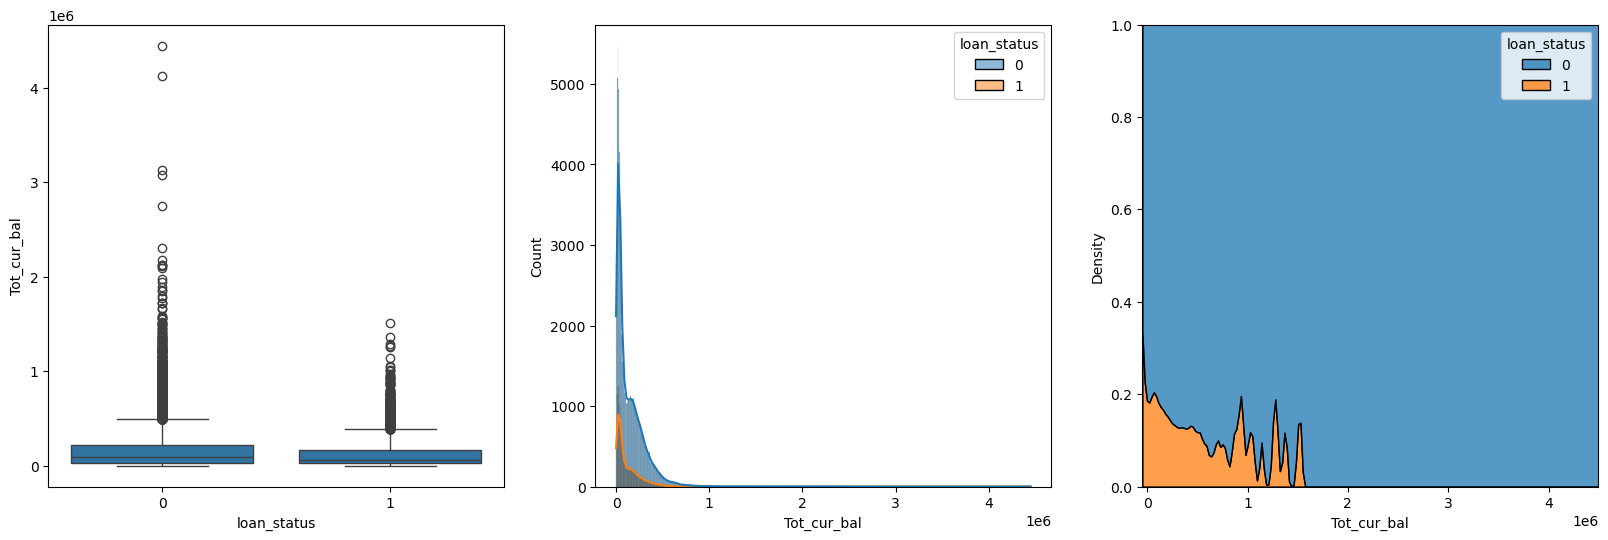

In [52]:
c = 'Tot_cur_bal'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

<Axes: xlabel='Tot_cur_bal', ylabel='Density'>

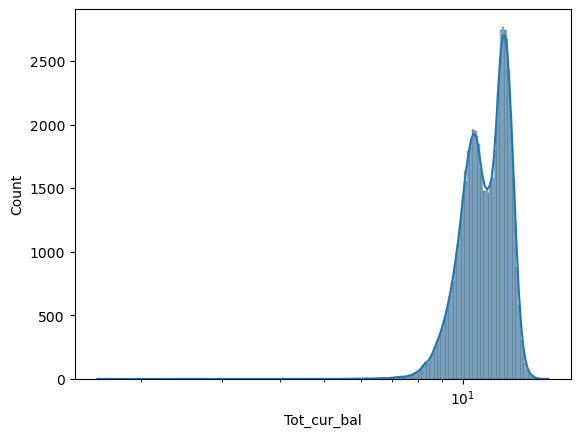

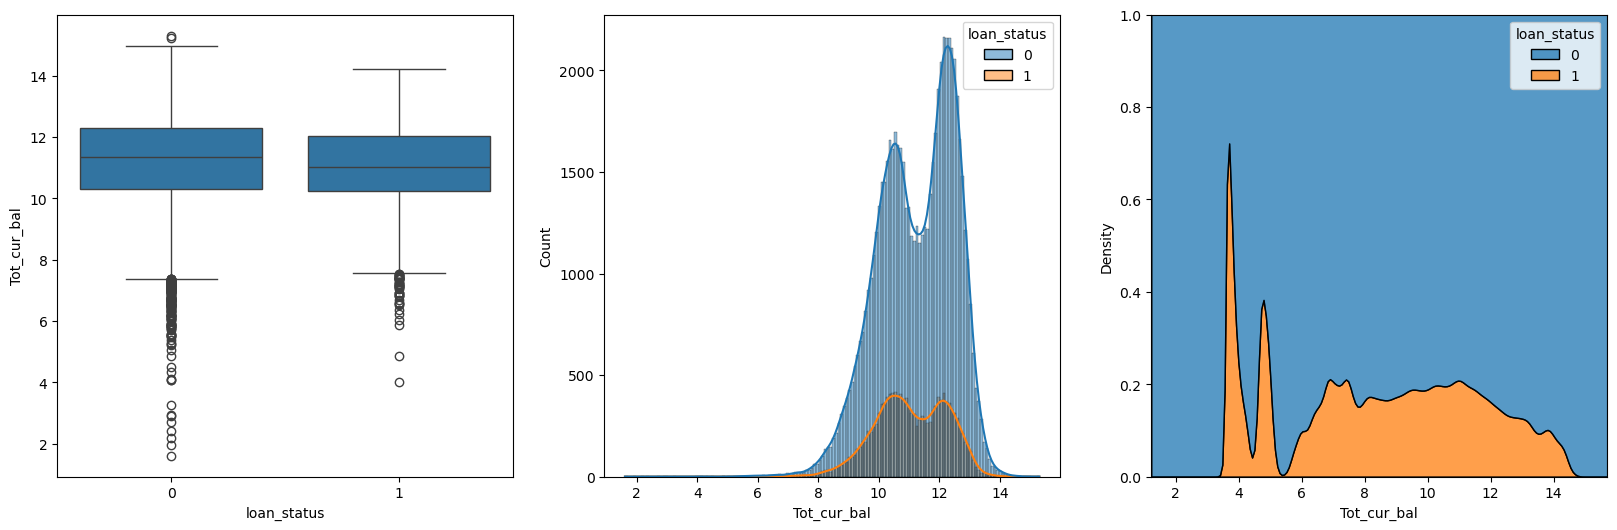

In [53]:
c = 'Tot_cur_bal'

df1[c] = np.log(df1[c]).fillna(-1)

sns.histplot(df1, x=c, kde=True, log_scale=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=df1, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=df1, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=df1, x=c, hue=tar_col, multiple='fill', ax=axs[2])

'Total_cur_bal' is similar to 'avg_cur_bal'.

**Review 'int_rate' column**

<Axes: xlabel='int_rate', ylabel='Density'>

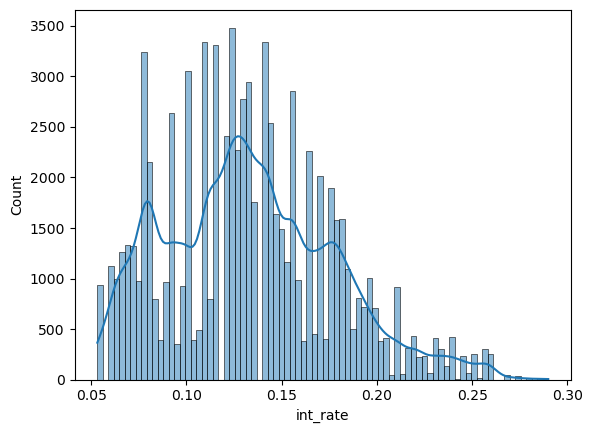

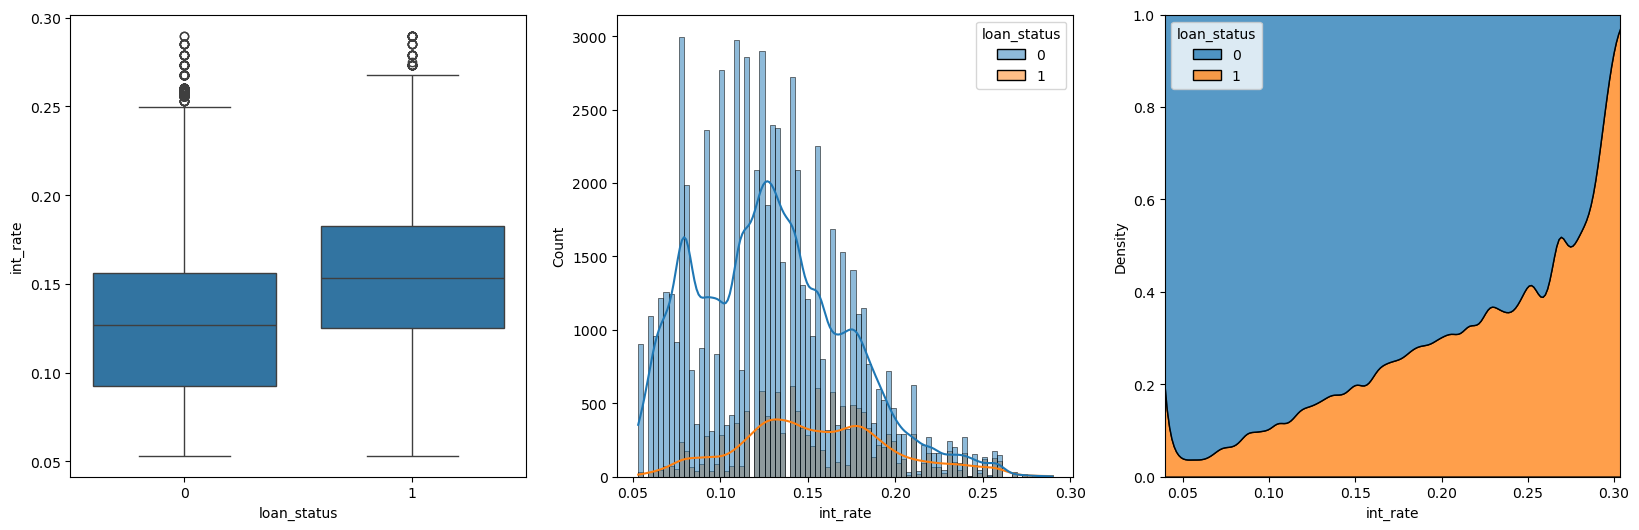

In [54]:
c = 'int_rate'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

'int_rate' is a strong predictor of default, customer with loan_status = 1 (Late payment) tend to have higher interest rates.

In the density plot: Orange area (Late payment) concentrate more heavily as interest rate increases, especially above 15%, default risk noticeably spikes. 

Higher interest rates → higher risk borrowers → more likely to late payment. 

**Review 'installment' column**

<Axes: xlabel='installment', ylabel='Density'>

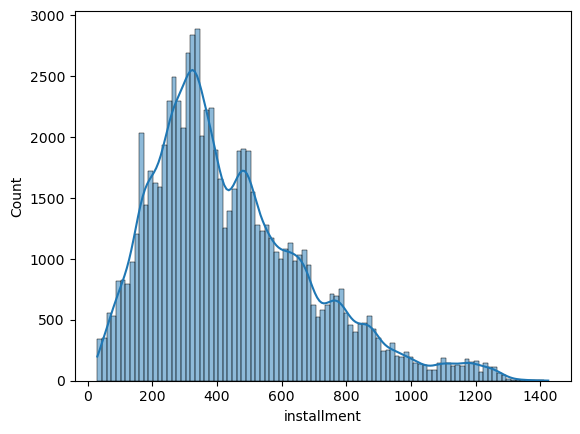

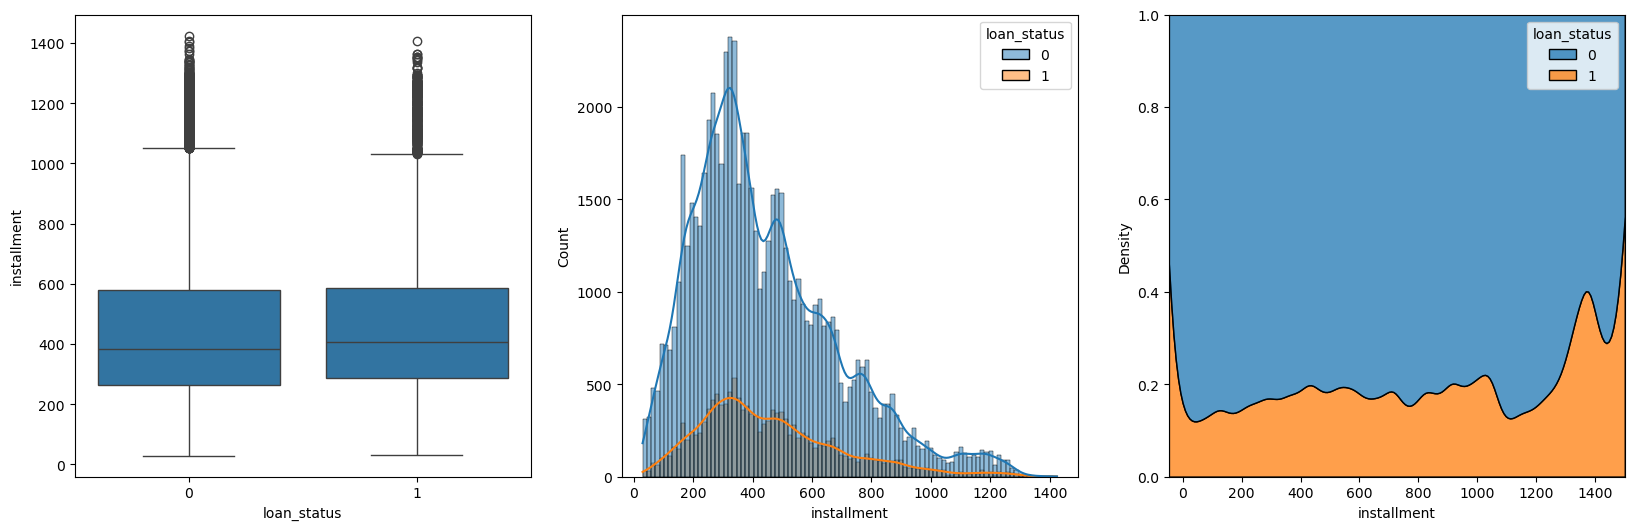

In [55]:
c = 'installment'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

Based on these plots, the 'installment' amount alone does not appear to be a strong standalone predictor or indicator of a loan's status. The distributions of installment for the two loan statuses largely overlap, suggesting that knowing the installment amount doesn't provide significant leverage in determining the loan status.

### 2.4 Multivariate Analysis

In [56]:
num_cols, cat_cols

(['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'loan_age_days',
  'total_inc'],
 ['home_ownership',
  'verification_status',
  'term',
  'grade',
  'pymnt_plan',
  'type',
  'purpose',
  'subregion',
  'job_level',
  'profession',
  'is_maturity',
  'have_inc_joint'])

#### 2.4.1 Correlation Analysis for Numerical Variables

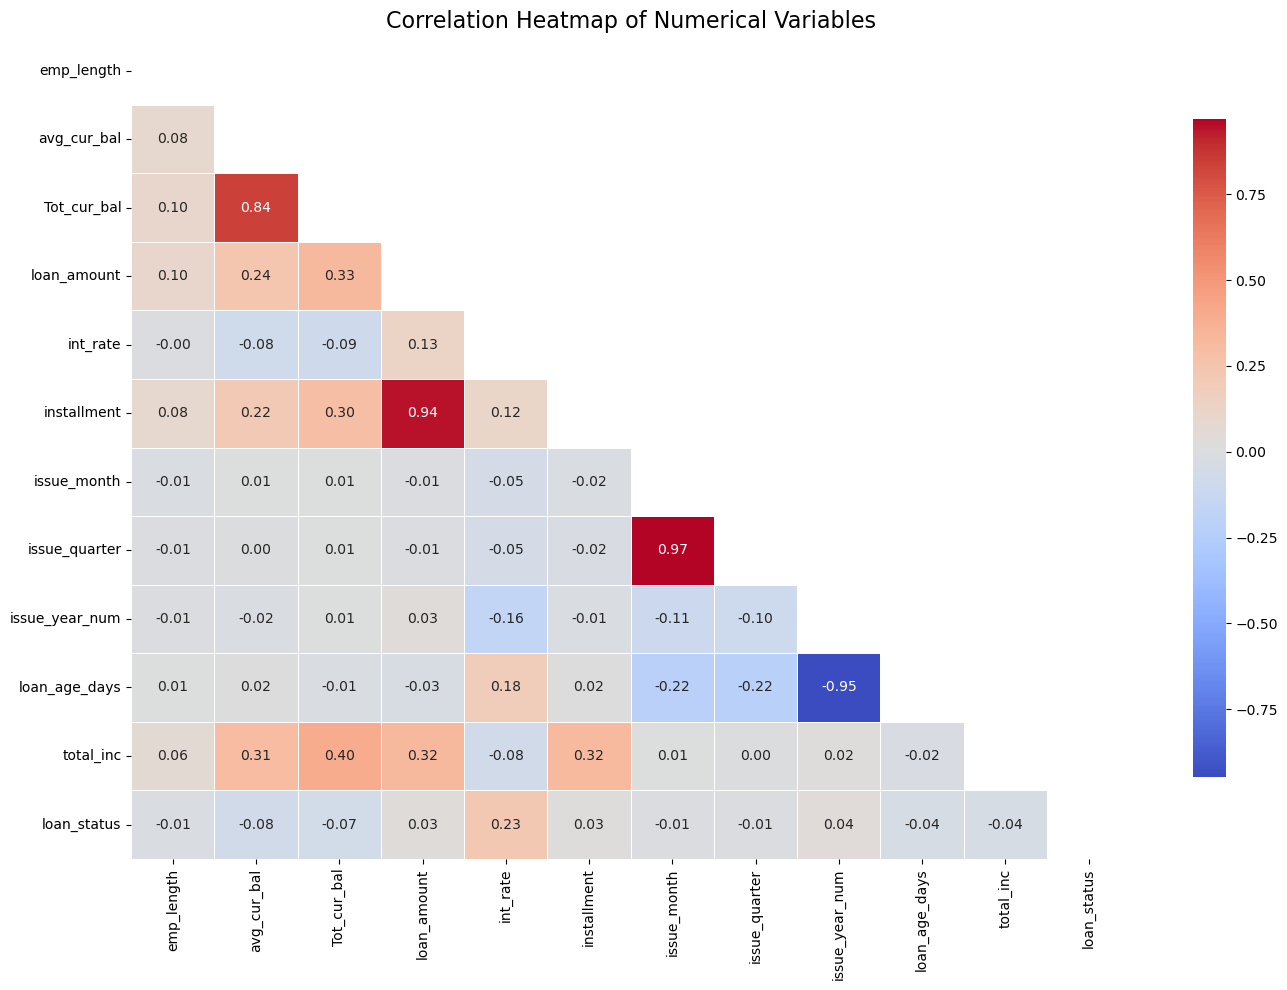


Potentially highly correlated features (|r| > 0.7):
avg_cur_bal and Tot_cur_bal: 0.837
loan_amount and installment: 0.944
issue_month and issue_quarter: 0.970
issue_year_num and loan_age_days: -0.946


In [57]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = merged_df[num_cols + ['loan_status']].corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()

# Identify high correlations (potential multicollinearity)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:  # Threshold for high correlation
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("\nPotentially highly correlated features (|r| > 0.7):")
    for var1, var2, corr in high_corr:
        print(f"{var1} and {var2}: {corr:.3f}")

#### 2.4.2 Pairplot for selected numerical variables

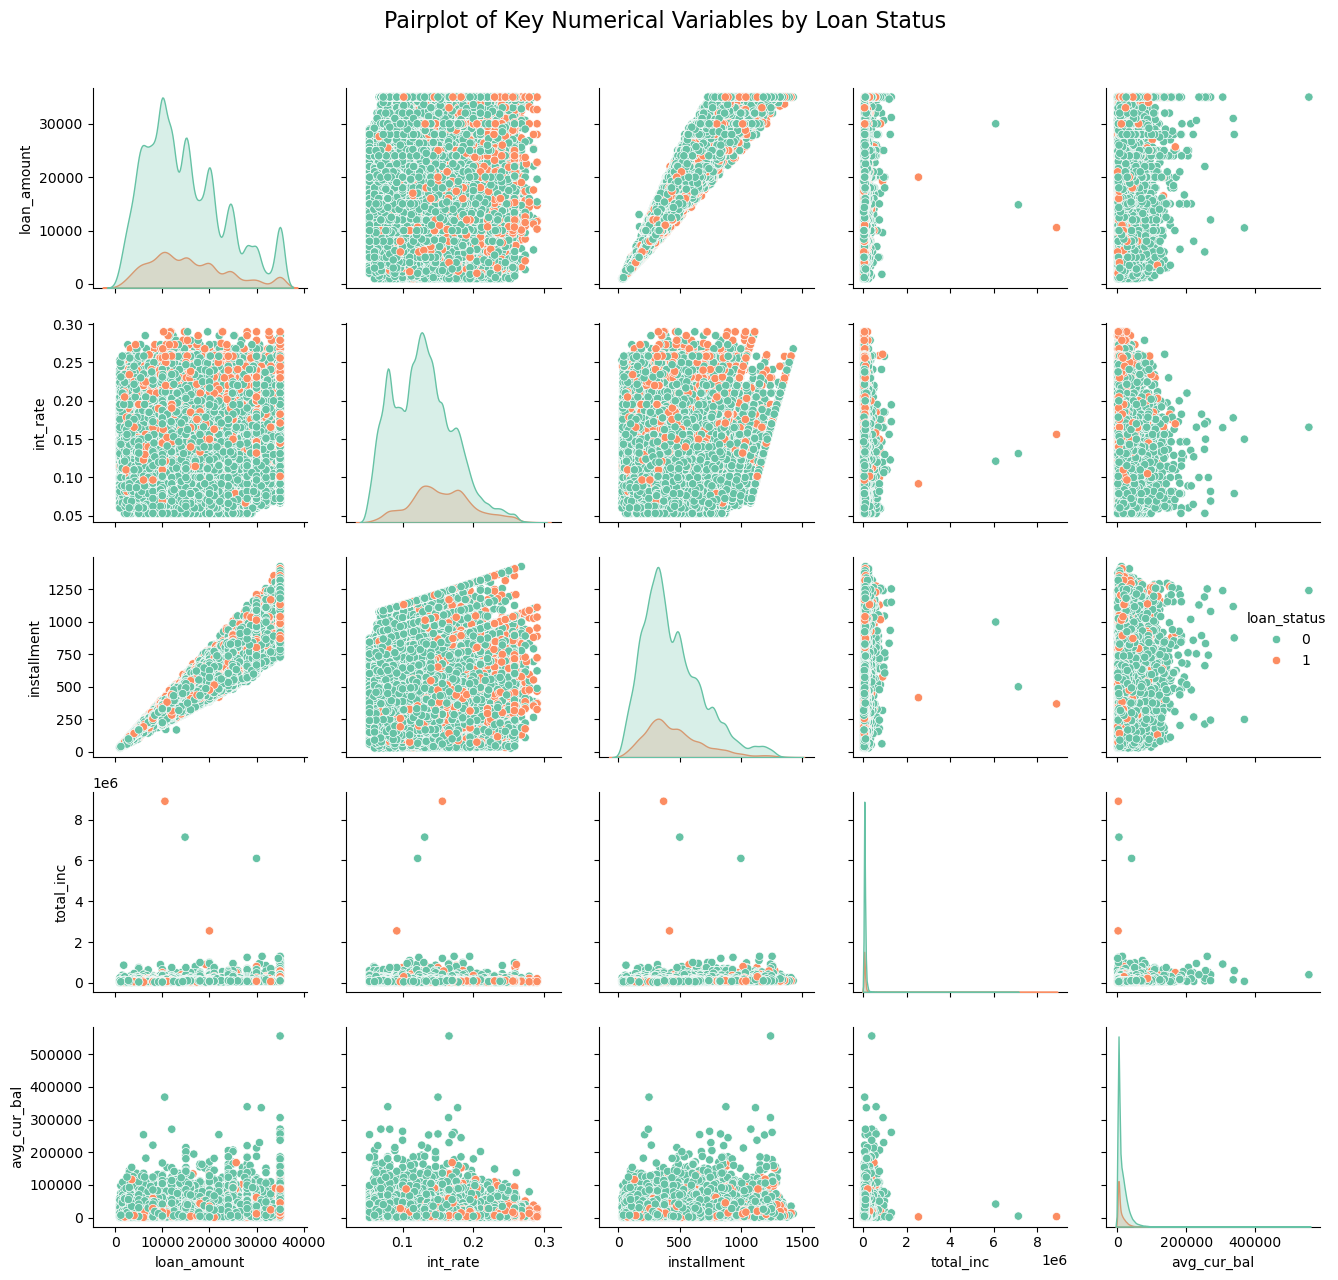

In [58]:
# Select a subset of numerical columns to avoid overcrowded plots
selected_num_cols = ['loan_amount', 'int_rate', 'installment', 'total_inc', 'avg_cur_bal']
sns.pairplot(merged_df[selected_num_cols + ['loan_status']], hue='loan_status', palette='Set2', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Key Numerical Variables by Loan Status', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

**Univariate Distributions by Loan Status:**

- int_rate: The distribution of interest rates is noticeably shifted towards higher values for late payment loans (orange) compared to on time payment loans (teal). This confirms int_rate is a strong univariate predictor.
- loan_amount and installment: The distributions for late payment loans show a slight tendency towards higher values compared to on time payment loans, but there is significant overlap. These variables seem to have some, but not strong, univariate predictive power.
- total_inc: The distributions of total income for late payment and on time payment loans largely overlap, suggesting that raw total income alone is not a strong univariate predictor of loan status in this dataset.
- avg_cur_bal: Late payment loans tend to have higher average current balances, which is expected as these loans have outstanding amounts. This variable reflects the state of the loan at or near default.

**Bivariate Relationships by Loan Status:**

- Strong Correlations: The pairplot clearly shows strong positive correlations between loan_amount and installment, and a positive correlation between loan_amount and int_rate. These relationships are evident for both loan statuses.
- Limited Separation in Bivariate Plots: When examining the scatter plots of pairs of these numerical variables, the late payment loans (orange) and on time payment loans (teal) are largely intermingled. There are no clear boundaries or regions in these 2D plots that effectively separate the two loan statuses using just these pairs of raw numerical variables.
- Overlap Dominates: For most pairs of variables, the overlap between the point clouds for late payment and on time payment loans is substantial, indicating that combinations of these raw numerical features alone do not easily distinguish between the two groups.

-> In conclusion, the pairplot reveals the distributions and pairwise relationships among several key numerical variables. It confirms that int_rate is the most individually predictive variable among these, while also demonstrating that relying solely on these raw numerical features and their simple pairwise relationships will be insufficient to clearly distinguish between defaulted and non-defaulted loans due to significant overlap.

#### 2.4.3 Interaction between numerical and categorical variables

In [59]:
# Boxplots to visualize how numerical variables vary across categorical groups with target
def plot_num_cat_target_relationship(df, num_var, cat_var, target='loan_status', sort_by = None):
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=cat_var, y=num_var, hue=target, data=df, palette='Set2')
    plt.title(f'Distribution of {num_var} by {cat_var} and {target}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

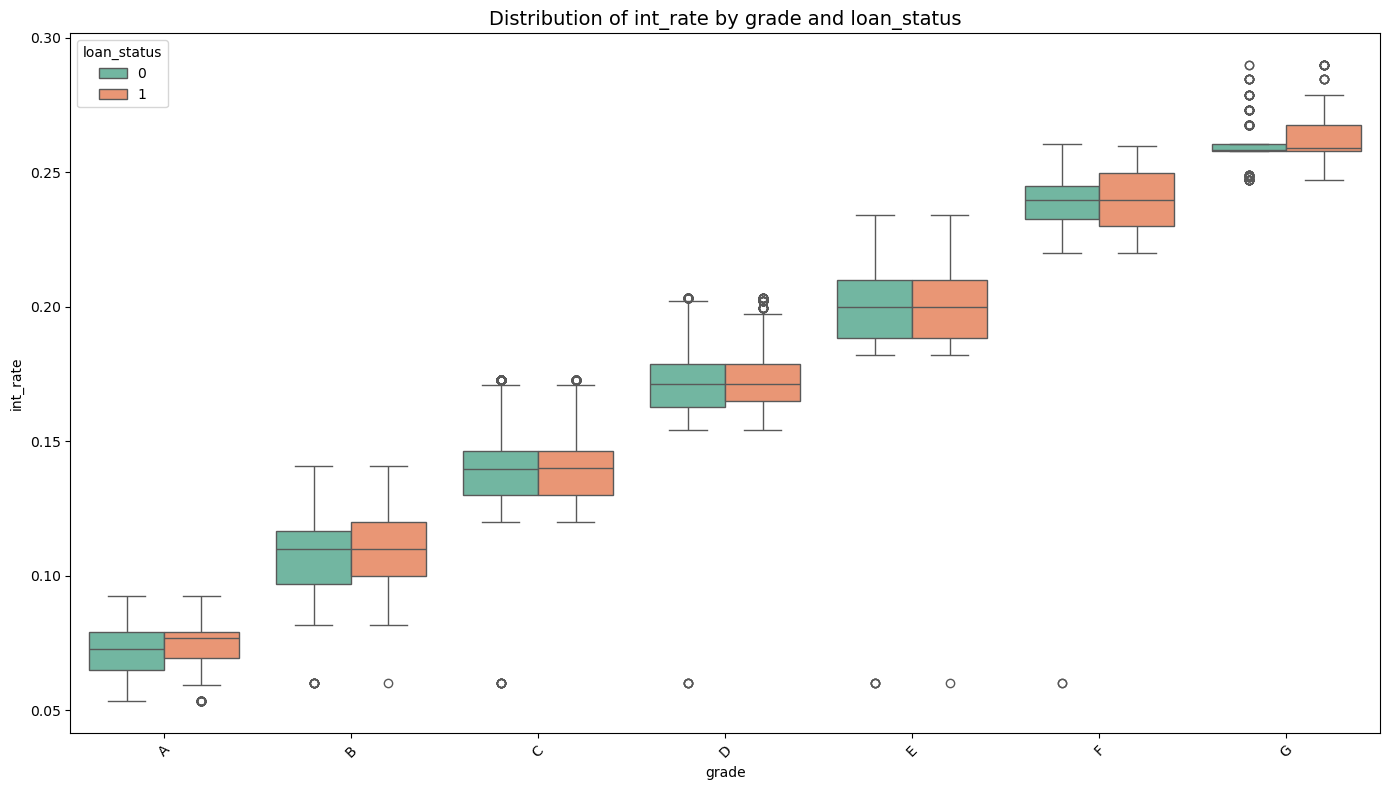

In [60]:
# Interaction of important numerical and categorical variable
# Interest rate and grade
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
merged_df['grade'] = pd.Categorical(merged_df['grade'], categories=grade_order, ordered=True)
plot_num_cat_target_relationship(merged_df, 'int_rate', 'grade', sort_by = 'grade')

It is clearly evident that customers assigned to lower 'grade' categories are charged higher interest rates, reflecting the higher risk associated with these borrowers, but the interest rate itself does not appear to significantly separate late payment from on time payment loans within the same grade.

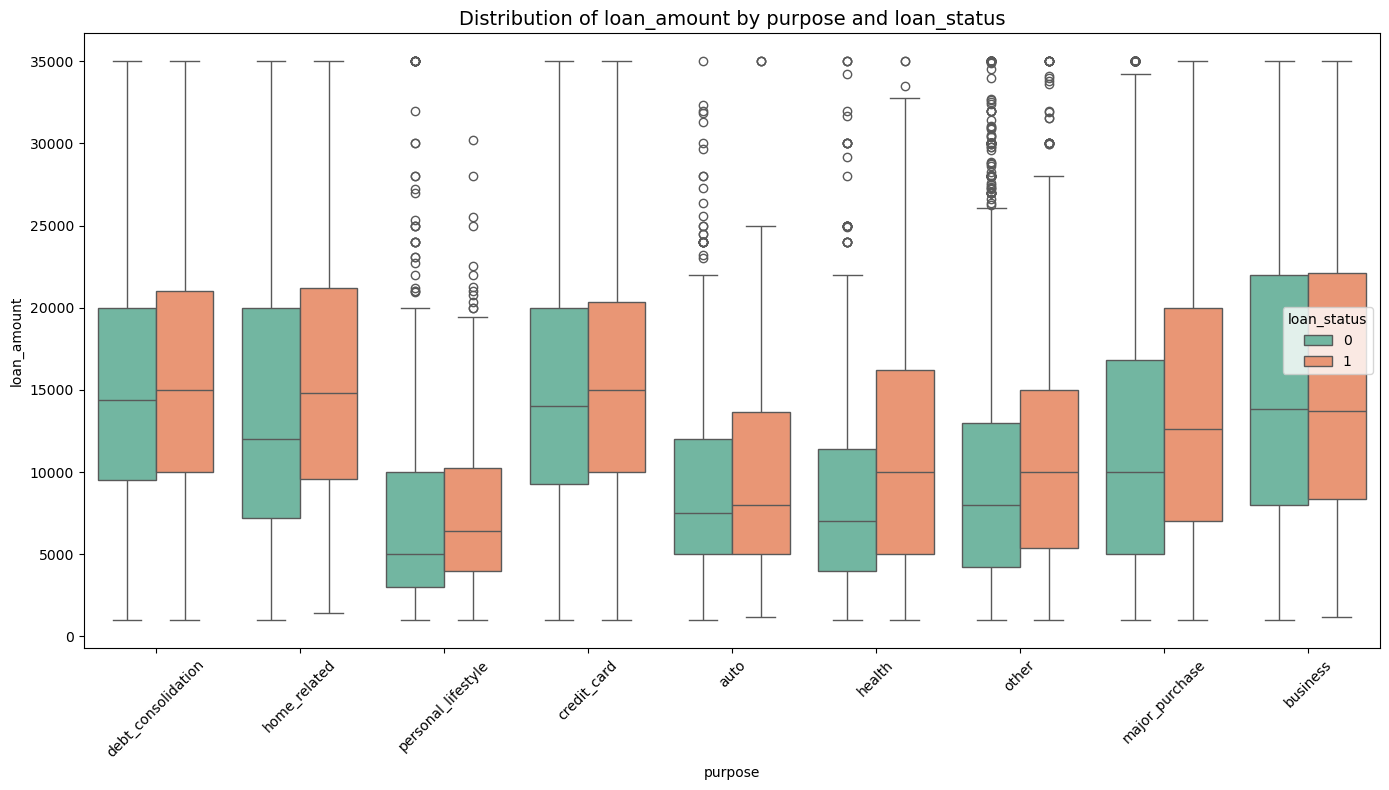

In [61]:
# Loan amount and purpose
plot_num_cat_target_relationship(merged_df, 'loan_amount', 'purpose')

While there is overlap in the distributions, the upward shift in the central tendency (median and IQR) for late payment loans is a notable pattern. This suggests that, regardless of the loan's purpose, a higher loan amount might be associated with an increased risk of default. 

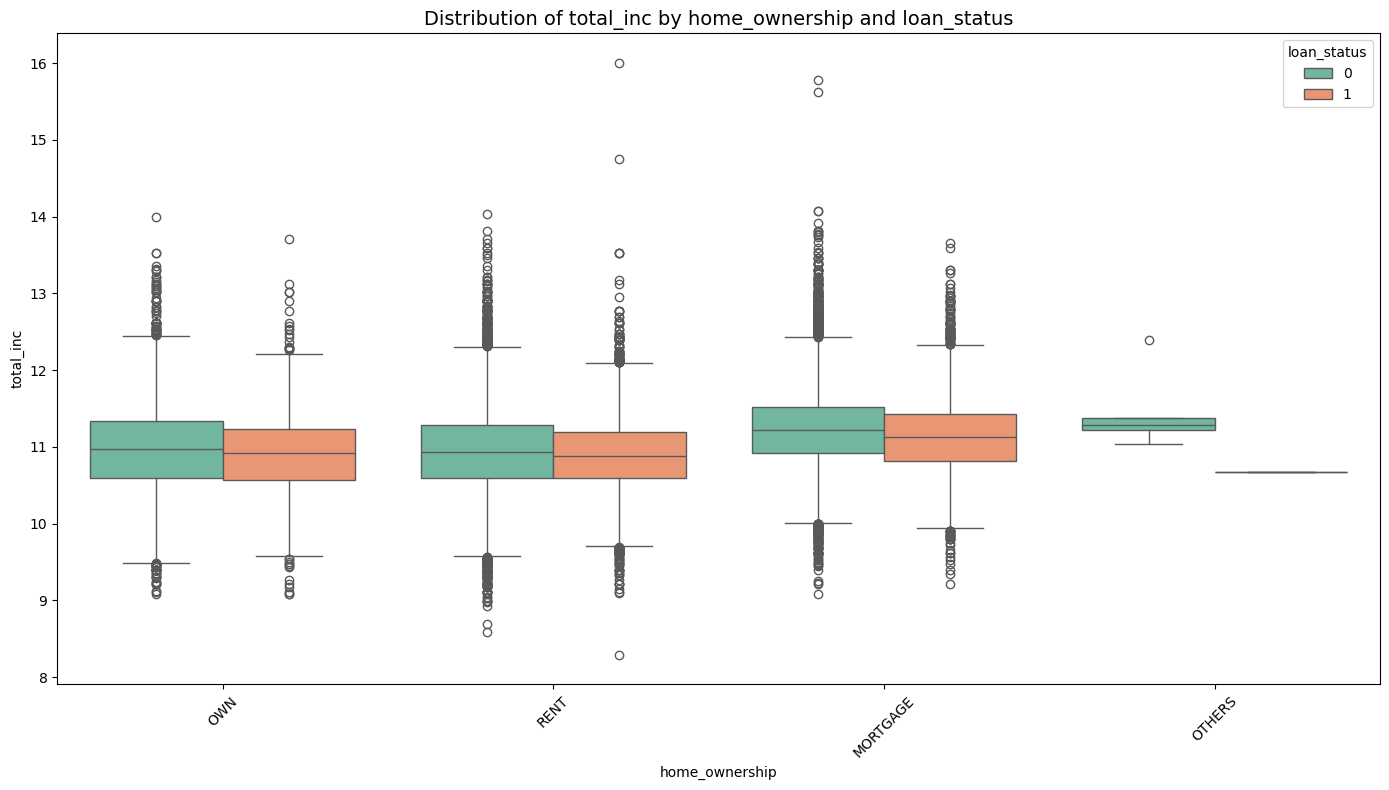

In [62]:
# Total income and home ownership
df1 = merged_df.copy()
df1['total_inc'] = np.log(df1['total_inc']).fillna(-1) # Log transformation to reduce the skewness
plot_num_cat_target_relationship(df1, 'total_inc', 'home_ownership')

While income is often considered a key factor in creditworthiness, this visualization suggests that in this dataset, total_inc itself might not be a primary driver distinguishing late payment from on time payment loans within specific home ownership groups. Other factors are likely more influential in determining loan status.

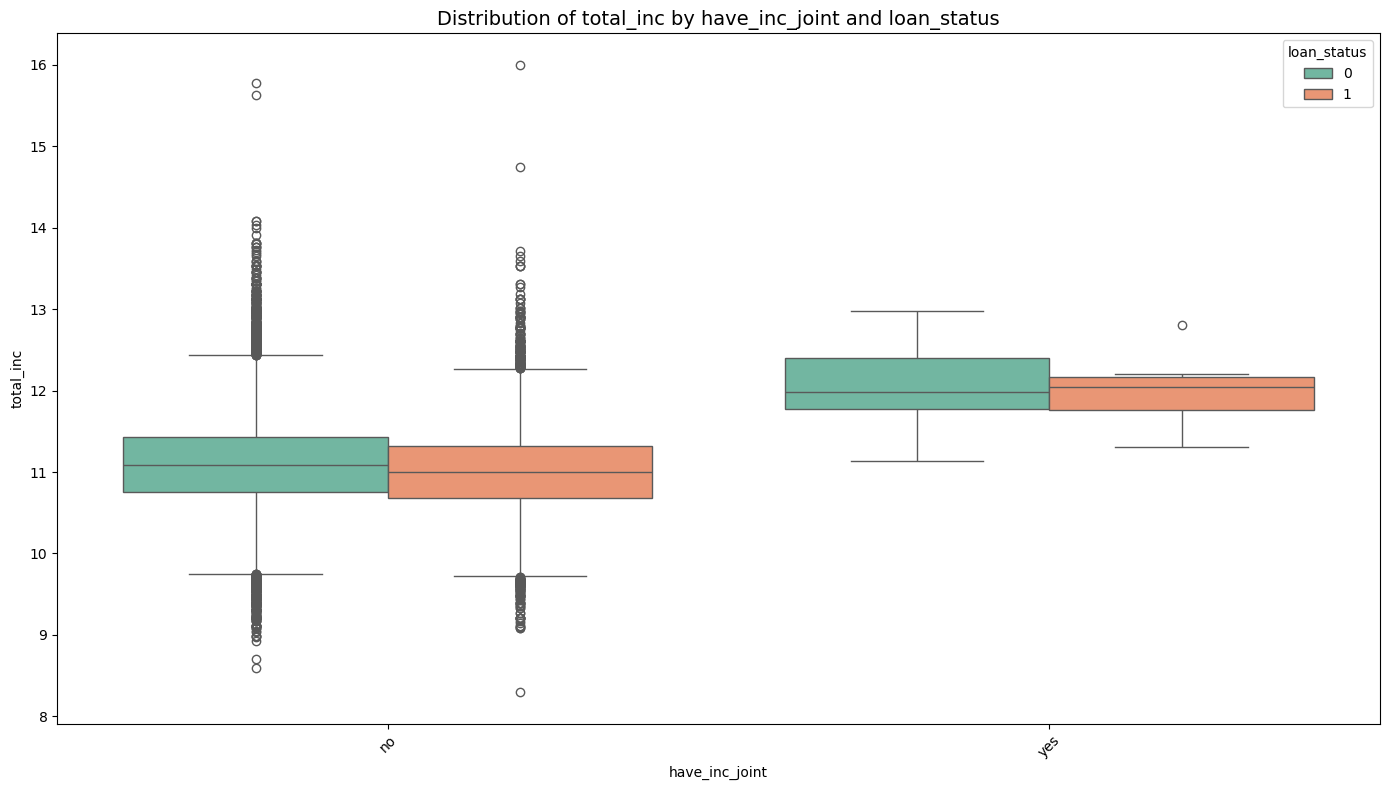

In [63]:
# total_inc and have_inc_joint
df1 = merged_df.copy()
df1['total_inc'] = np.log(df1['total_inc']).fillna(-1) # Log transformation to reduce the skewness
plot_num_cat_target_relationship(df1, 'total_inc', 'have_inc_joint')

While the presence of joint income is strongly associated with higher total income levels, the total income itself, whether individual or joint, does not appear to be a primary factor distinguishing late payment from on time payment loans in this dataset.

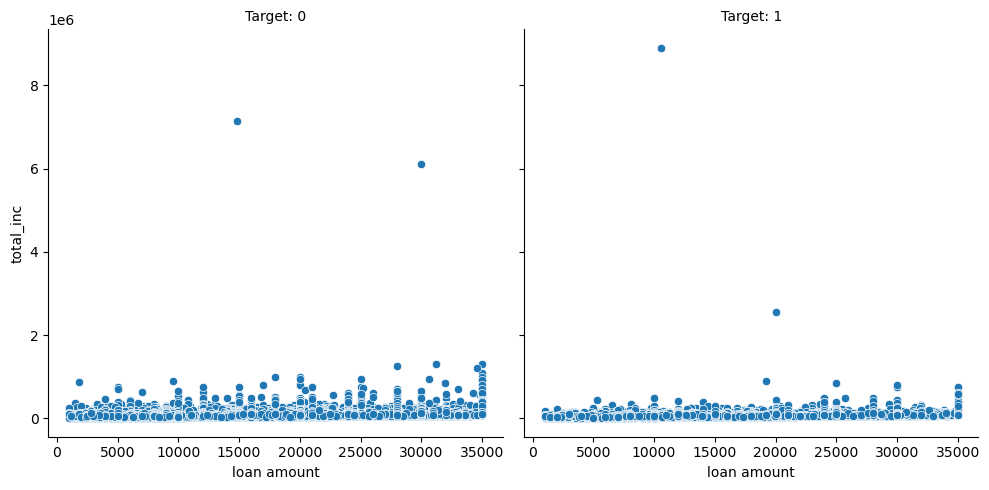

In [64]:
g = sns.FacetGrid(merged_df, col=tar_col, height=5, aspect=1)
g.map(sns.scatterplot, 'loan_amount', 'total_inc')
g.set_axis_labels('loan amount', 'total_inc')
g.set_titles(col_template='Target: {col_name}')
plt.tight_layout()
plt.show()

Although the distribution between the two classes does not show significant differences, it can be observed that higher income is associated with lower late payment risk. Therefore, creating a few new variables may help to further explore this relationship.

## 3. Feature Engineering

### 3.1 Create new feature

Create new numerical feature

In [65]:
# Payment burden features
merged_df['payment_to_income'] = merged_df['installment'] / (merged_df['total_inc']/12)

# Loan to income ratio
merged_df['lti'] = merged_df['loan_amount'] / merged_df['total_inc']

# Interest burden
merged_df['interest_burden'] = merged_df['int_rate'] * merged_df['loan_amount'] / merged_df['total_inc']

# Balance to loan ratio
merged_df['bal_to_loan'] = merged_df['avg_cur_bal'] / merged_df['loan_amount']

# Balance to income ratio
merged_df['bal_to_income'] = merged_df['avg_cur_bal'] / merged_df['total_inc']

# Interest rate premium over grade (how much above typical rate for this grade)
grade_avg_rate = merged_df.groupby('grade')['int_rate'].transform('mean') # calculate avg int rate by grade
merged_df['rate_premium'] = merged_df['int_rate'] - grade_avg_rate

# Total debt indicators
merged_df['total_debt_ratio'] = merged_df['Tot_cur_bal'] / merged_df['total_inc']

# Loan size relative to typical loans in same grade
grade_avg_loan = merged_df.groupby('grade')['loan_amount'].transform('mean')
merged_df['relative_loan_size'] = merged_df['loan_amount'] / grade_avg_loan

In [66]:
merged_df['monthly_interest'] = (merged_df['int_rate'] / 100 / 12) * merged_df['loan_amount']
merged_df['interest_to_payment_ratio'] = merged_df['monthly_interest'] / merged_df['installment']

In [67]:
# Loan utilization (how much of available credit is being used)
merged_df['loan_to_balance_ratio'] = merged_df['loan_amount'] / np.where(merged_df['Tot_cur_bal'] > 0, merged_df['Tot_cur_bal'], 1)

### 3.2 Handle missing value

Assess the change in the distribution of the 'emp_length' variable after filling missing values with the median.

In [68]:
# percentage of null
merged_df['emp_length'].isna().sum()/len(merged_df)

0.051580576228723016

In [69]:
# percentage of median
(merged_df['emp_length'] == merged_df['emp_length'].median()).sum()/len(merged_df)

0.051777073661975294

<Axes: >

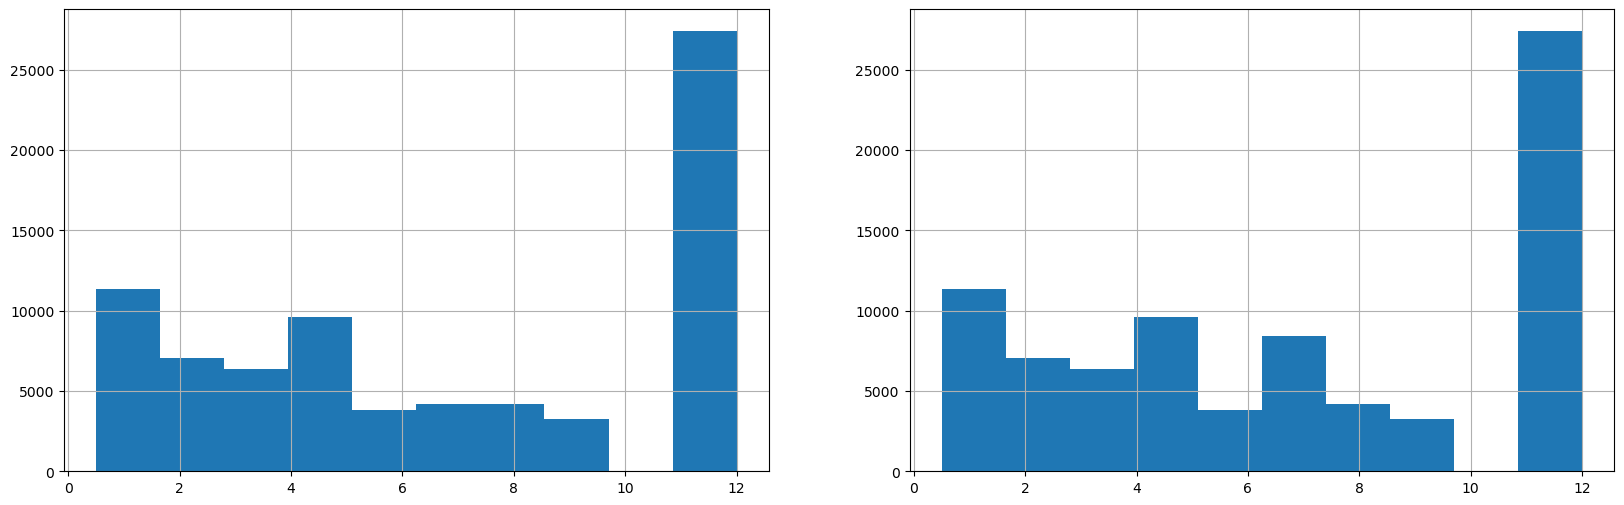

In [70]:
# Comparison of distribution change from simple impute
f, axs = plt.subplots(1,2, figsize=(20, 6))
merged_df['emp_length'].hist(ax=axs[0])
merged_df['emp_length'].fillna(merged_df['emp_length'].median()).hist(ax=axs[1])

The 'emp_length' column contains ~5% missing data. Filling these missing values with the median causes the percentage of the median value to increase from 5.2% to 10%.

### 3.3 Feature evaluation

#### ** Data Split

In [71]:
num_cols = merged_df.select_dtypes(include='number').columns.tolist()
num_cols.remove(tar_col)
cat_cols = merged_df.select_dtypes(exclude='number').columns.tolist()

**Train Test Split for feature evaluation**

Use data from 08/2012 - 06/2015 as the training set, data from 07/2015 - 12/2015 as the test set.

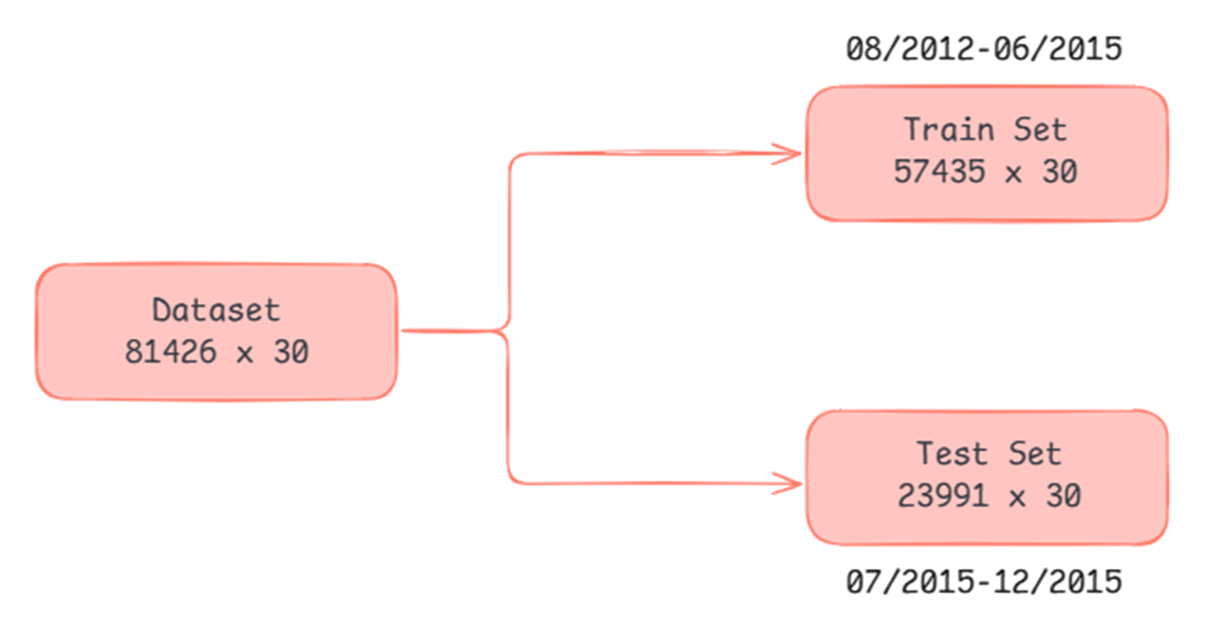

In [72]:
df_train = merged_df[(merged_df['issue_year_num'] < 2015) | ((merged_df['issue_year_num'] == 2015) & (merged_df['issue_month'] <= 6))]
df_test = merged_df[(merged_df['issue_year_num'] == 2015) & (merged_df['issue_month'] > 6)]

In [73]:
X_train = df_train[num_cols + cat_cols]
X_test = df_test[num_cols + cat_cols]
y_train = df_train[tar_col]
y_test = df_test[tar_col]
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (57435, 34), Test set: (23991, 34)


Evaluate the distribution of the target variable in the train set and test set.

Distribution of target
-------


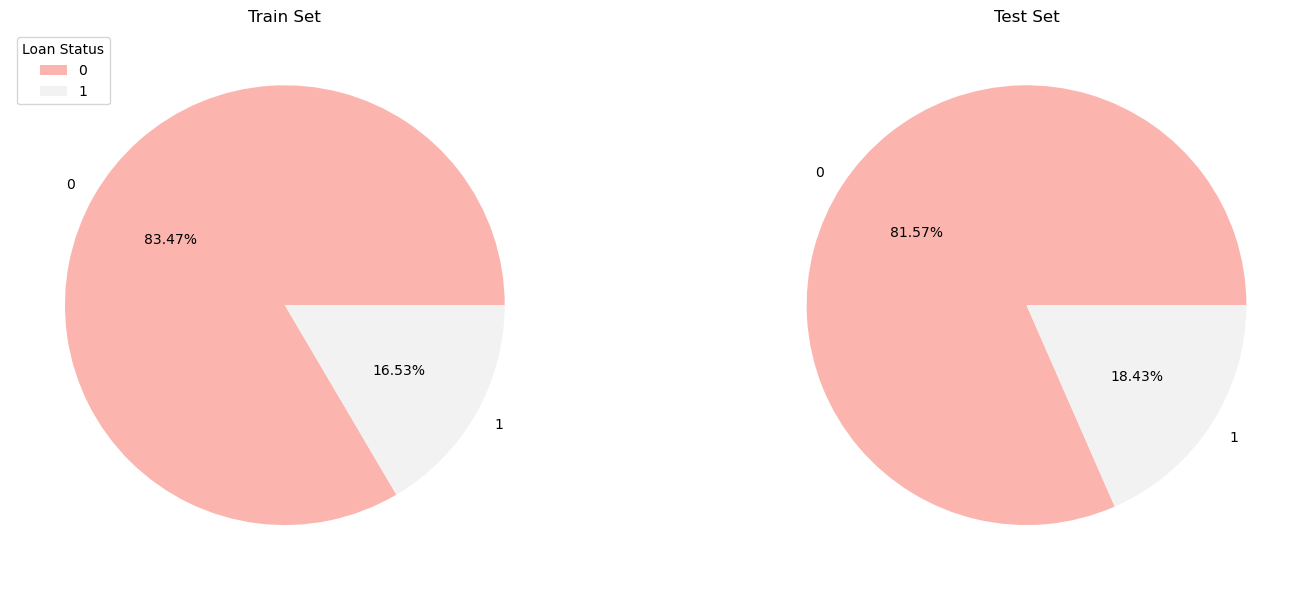

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train
df_train[tar_col].value_counts().plot(kind='pie', ax=axs[0], autopct='%.2f%%', cmap='Pastel1', title = 'Train Set')
axs[0].set_ylabel('')
axs[0].legend(title='Loan Status', loc='upper left')

# Test
df_test[tar_col].value_counts().plot(kind='pie', ax=axs[1], autopct='%.2f%%', cmap='Pastel1', title = 'Test Set')
axs[1].set_ylabel('')

print("Distribution of target")
print("-------")
plt.tight_layout()
plt.show()

The distribution across the train and test set is relatively similar.

#### ** Preprocessing for feature evaluation

**Data Pipeline**

In [75]:
# Split features by type
cat = [col for col in cat_cols if col != 'grade']
ordinal_cat = ['grade']  

# Define ordinal mapping for grade
grade_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [76]:
# Create preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                    
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[grade_categories]))
])

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat),
        ('ord_cat', ordinal_cat_transformer, ordinal_cat)
    ],
    verbose_feature_names_out=False  # Use simpler feature names
)

In [77]:
# Fit and transform train set
X_train_pc = preprocessor.fit_transform(X_train, y_train)  
# Transform test set
X_test_pc = preprocessor.transform(X_test)

In [78]:
X_train.shape, X_train_pc.shape

((57435, 34), (57435, 73))

In [79]:
feature_names = preprocessor.get_feature_names_out()

**Implements multiple feature selection methods and compares them:**

- Univariate Selection (ANOVA F-test): Identifies features with strong individual relationships to the target

- Mutual Information: Captures non-linear relationships between features and target

- Recursive Feature Elimination: Iteratively removes less important features

- Model-based Feature Importance: Uses Random Forest to rank features by importance

#### ** Method 1: Univariate Selection with optimization

In [80]:
selected_features = {}

In [81]:
k_features = min(30, X_train_pc.shape[1])
selector = SelectKBest(f_classif, k=k_features)

In [82]:
# Fit on the data
selector.fit(X_train_pc, y_train)

SelectKBest(k=30)

In [83]:
# Get selected feature names 
feature_indices = selector.get_support(indices=True)
selected_features_uni = [feature_names[i] for i in feature_indices]
selected_features['univariate'] = selected_features_uni

In [84]:
# Transform the data
X_train_selected = selector.transform(X_train_pc)
X_test_selected = selector.transform(X_test_pc)

In [85]:
# Train a simple model to evaluate
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [86]:
print("\n--- UNIVARIATE SELECTION (ANOVA F-TEST) ---")
print(f"Selected features: {len(selected_features_uni)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)
        
print("Top 30 features:")
print(feature_scores.head(30))


--- UNIVARIATE SELECTION (ANOVA F-TEST) ---
Selected features: 30
ROC-AUC Score: 0.6664
Top 30 features:
                                Feature        Score
72                                grade  2843.346085
4                              int_rate  2760.294692
20            interest_to_payment_ratio  2387.854044
13                      interest_burden  2131.699457
19                     monthly_interest   962.212562
30                      term_ 60 months   750.334794
29                      term_ 36 months   750.334794
12                                  lti   659.041710
11                    payment_to_income   584.405681
1                           avg_cur_bal   285.945282
26     verification_status_Not Verified   272.579918
14                          bal_to_loan   260.060474
2                           Tot_cur_bal   233.637536
22              home_ownership_MORTGAGE   148.209704
25                  home_ownership_RENT   143.203966
15                        bal_to_income   129.

#### ** Method 2: Mutual Information - optimize computation

In [87]:
# Use a smaller subset for mutual info because dataset is large
if X_train_pc.shape[0] > 50000:
    print("Using a subset of data for mutual information calculation")
    subset_indices = np.random.choice(X_train_pc.shape[0], 50000, replace=False)
    X_subset = X_train_pc[subset_indices]
    y_subset = y_train.iloc[subset_indices] if hasattr(y_train, 'iloc') else y_train[subset_indices]
    selector = SelectKBest(mutual_info_classif, k=k_features)
    selector.fit(X_subset, y_subset)
else:
    selector = SelectKBest(mutual_info_classif, k=k_features)
    selector.fit(X_train_pc, y_train)

Using a subset of data for mutual information calculation


In [88]:
# Get selected feature names
feature_indices = selector.get_support(indices=True)
selected_features_mi = [feature_names[i] for i in feature_indices]
selected_features['mutual_info'] = selected_features_mi

In [89]:
# Transform the data
X_train_selected = selector.transform(X_train_pc)
X_test_selected = selector.transform(X_test_pc)

In [90]:
# Train a simple model to evaluate
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [91]:
print("\n--- MUTUAL INFORMATION SELECTION ---")
print(f"Selected features: {len(selected_features_mi)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)
        
print("Top 30 features:")
print(feature_scores.head(30))


--- MUTUAL INFORMATION SELECTION ---
Selected features: 30
ROC-AUC Score: 0.6622
Top 30 features:
                                Feature     Score
16                         rate_premium  0.025570
4                              int_rate  0.025342
72                                grade  0.024607
20            interest_to_payment_ratio  0.023877
13                      interest_burden  0.020559
18                   relative_loan_size  0.018781
19                     monthly_interest  0.017770
29                      term_ 36 months  0.015736
5                           installment  0.012371
33                      type_INDIVIDUAL  0.010991
22              home_ownership_MORTGAGE  0.010084
69                       is_maturity_no  0.009514
71                    have_inc_joint_no  0.009513
10                            total_inc  0.007140
30                      term_ 60 months  0.006369
25                  home_ownership_RENT  0.005798
37           purpose_debt_consolidation  0.005625
1

#### ** Method 3: Recursive Feature Elimination

In [92]:
# Use a subset of data for RFE because dataset is large
sample_size_rfe = min(20000, X_train_pc.shape[0])  
if X_train_pc.shape[0] > sample_size_rfe:
    print(f"Using a sample of {sample_size_rfe} records for RFE")
    indices = np.random.choice(X_train_pc.shape[0], sample_size_rfe, replace=False)
    X_rfe = X_train_pc[indices]
    y_rfe = y_train.iloc[indices] if hasattr(y_train, 'iloc') else y_train[indices]
else:
    X_rfe = X_train_pc
    y_rfe = y_train

Using a sample of 20000 records for RFE


In [93]:
# Use a faster model for RFE
estimator = RandomForestClassifier(
    n_estimators=50,  # Reduce number of trees
    max_depth=10,     # Limit tree depth
    random_state=42,
    n_jobs=-1         # Use all CPU cores
        )

In [94]:
# Use a larger step size for RFE to remove more features at each step
k_features = min(30, X_train_pc.shape[1])
step_size = max(1, X_train_pc.shape[1] // 20)  # Remove 5% of features at each step
        
print(f"RFE step size: {step_size} features per iteration")
selector = RFE(
    estimator, 
    n_features_to_select=k_features, 
    step=step_size,
    verbose=1  # Show progress
        )

RFE step size: 3 features per iteration


In [95]:
# Fit RFE
selector.fit(X_rfe, y_rfe)

Fitting estimator with 73 features.
Fitting estimator with 70 features.
Fitting estimator with 67 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 58 features.
Fitting estimator with 55 features.
Fitting estimator with 52 features.
Fitting estimator with 49 features.
Fitting estimator with 46 features.
Fitting estimator with 43 features.
Fitting estimator with 40 features.
Fitting estimator with 37 features.
Fitting estimator with 34 features.
Fitting estimator with 31 features.


RFE(estimator=RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,
                                     random_state=42),
    n_features_to_select=30, step=3, verbose=1)

In [96]:
# Get selected feature names
feature_indices = selector.get_support(indices=True)
selected_features_rfe = [feature_names[i] for i in feature_indices]
selected_features['rfe'] = selected_features_rfe

In [97]:
# Transform full dataset with selected features
X_train_selected = selector.transform(X_train_pc)
X_test_selected = selector.transform(X_test_pc)

In [98]:
# Train a model to evaluate
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [99]:
print("\n--- RECURSIVE FEATURE ELIMINATION ---")
print(f"Selected features: {len(selected_features_rfe)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
print("Selected features:")
print(selected_features_rfe)


--- RECURSIVE FEATURE ELIMINATION ---
Selected features: 30
ROC-AUC Score: 0.6676
Selected features:
['emp_length', 'avg_cur_bal', 'Tot_cur_bal', 'loan_amount', 'int_rate', 'installment', 'issue_month', 'issue_quarter', 'issue_year_num', 'loan_age_days', 'total_inc', 'payment_to_income', 'lti', 'interest_burden', 'bal_to_loan', 'bal_to_income', 'rate_premium', 'total_debt_ratio', 'relative_loan_size', 'monthly_interest', 'interest_to_payment_ratio', 'loan_to_balance_ratio', 'verification_status_Source Verified', 'verification_status_Verified', 'term_ 36 months', 'term_ 60 months', 'purpose_debt_consolidation', 'subregion_Middle Atlantic', 'profession_Sales, Service & F&B', 'grade']


#### ** Method 4: Model-based Feature Importance - optimize with fewer trees and parallel processing

In [100]:
# Train a faster random forest model
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,  # Let trees grow fully for better feature importance
    random_state=42,
    n_jobs=-1        # Use all CPU cores
)

In [101]:
# Use sample for model fitting if data is large
if X_train_pc.shape[0] > 50000:
    print("Using a subset of data for model-based feature importance")
    subset_indices = np.random.choice(X_train_pc.shape[0], 50000, replace=False)
    X_subset = X_train_pc[subset_indices]
    y_subset = y_train.iloc[subset_indices] if hasattr(y_train, 'iloc') else y_train[subset_indices]
    model.fit(X_subset, y_subset)
else:
    model.fit(X_train_pc, y_train)

Using a subset of data for model-based feature importance


In [102]:
# Get feature importances
importances = model.feature_importances_
        
# Create a dataframe for visualization
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [103]:
# Select top k features
k_features = min(30, X_train_pc.shape[1])
selected_features_rf = feature_imp.head(k_features)['Feature'].tolist()
selected_features['model_based'] = selected_features_rf
        
# Extract selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features_rf]
X_train_selected = X_train_pc[:, selected_indices]
X_test_selected = X_test_pc[:, selected_indices]

In [104]:
# Train a new model with selected features
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [105]:
print("\n--- MODEL-BASED FEATURE IMPORTANCE ---")
print(f"Selected features: {len(selected_features_rf)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
print("Top 30 features by importance:")
print(feature_imp.head(30))


--- MODEL-BASED FEATURE IMPORTANCE ---
Selected features: 30
ROC-AUC Score: 0.6711
Top 30 features by importance:
                                Feature  Importance
20            interest_to_payment_ratio    0.050639
13                      interest_burden    0.050208
17                     total_debt_ratio    0.044956
15                        bal_to_income    0.044720
21                loan_to_balance_ratio    0.044697
2                           Tot_cur_bal    0.044574
1                           avg_cur_bal    0.044332
14                          bal_to_loan    0.044219
11                    payment_to_income    0.043959
12                                  lti    0.042497
19                     monthly_interest    0.041492
5                           installment    0.039868
4                              int_rate    0.039505
10                            total_inc    0.039040
18                   relative_loan_size    0.034124
3                           loan_amount    0.030570
9

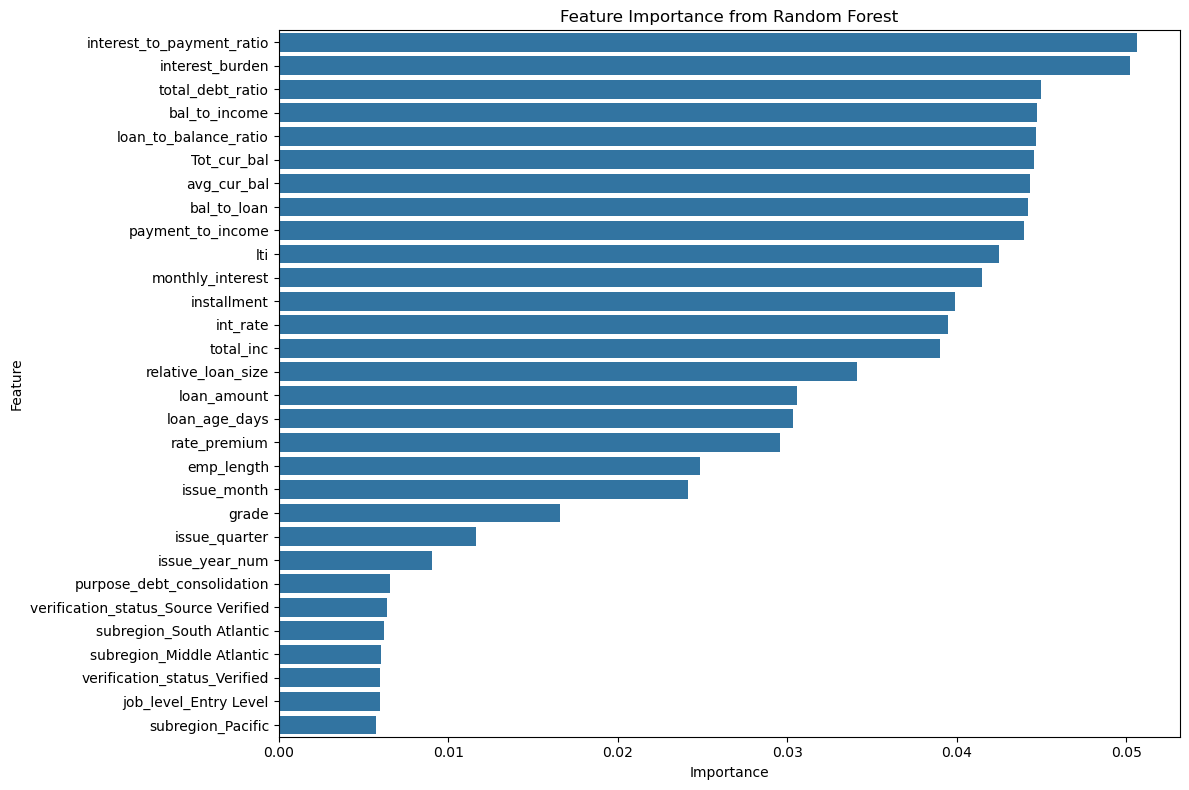

In [106]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(30))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()

#### ** Compare Methods

In [107]:
print("\n--- COMPARING FEATURE SELECTION METHODS ---")
all_selected_features = set()
for method, features in selected_features.items():
    all_selected_features.update(features)
    
comparison = pd.DataFrame(index=list(all_selected_features))
    
for method, features in selected_features.items():
    comparison[method] = [1 if feat in features else 0 for feat in comparison.index]

# Add a count of methods that selected each feature
comparison['Total'] = comparison.sum(axis=1)
comparison = comparison.sort_values('Total', ascending=False)

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 80)
print(comparison)


--- COMPARING FEATURE SELECTION METHODS ---
                                     univariate  mutual_info  rfe  model_based  Total
interest_to_payment_ratio                     1            1    1            1      4
payment_to_income                             1            1    1            1      4
int_rate                                      1            1    1            1      4
grade                                         1            1    1            1      4
monthly_interest                              1            1    1            1      4
avg_cur_bal                                   1            1    1            1      4
lti                                           1            1    1            1      4
loan_amount                                   1            1    1            1      4
purpose_debt_consolidation                    1            1    1            1      4
issue_year_num                                1            1    1            1      4
total_inc

In [108]:
# Recommend the best features (selected by at least 2 methods)
recommended_features = comparison[comparison['Total'] >= 2].index.tolist()
print("\n--- RECOMMENDED FEATURES ---")
print(f"Number of recommended features: {len(recommended_features)}")
print(recommended_features)


--- RECOMMENDED FEATURES ---
Number of recommended features: 34
['interest_to_payment_ratio', 'payment_to_income', 'int_rate', 'grade', 'monthly_interest', 'avg_cur_bal', 'lti', 'loan_amount', 'purpose_debt_consolidation', 'issue_year_num', 'total_inc', 'bal_to_loan', 'interest_burden', 'verification_status_Source Verified', 'installment', 'loan_to_balance_ratio', 'loan_age_days', 'total_debt_ratio', 'issue_quarter', 'emp_length', 'term_ 60 months', 'relative_loan_size', 'bal_to_income', 'rate_premium', 'term_ 36 months', 'verification_status_Verified', 'Tot_cur_bal', 'issue_month', 'subregion_Middle Atlantic', 'job_level_Entry Level', 'subregion_Pacific', 'verification_status_Not Verified', 'home_ownership_RENT', 'home_ownership_MORTGAGE']


In [109]:
rcm_features = ['interest_burden', 'monthly_interest', 'bal_to_loan', 'payment_to_income', 'interest_to_payment_ratio', 'purpose', 'verification_status', 'grade', 'lti', 'int_rate', 'installment', 'loan_amount', 'avg_cur_bal', 'total_debt_ratio', 'bal_to_income', 'total_inc', 'job_level', 'loan_age_days', 'rate_premium', 'loan_to_balance_ratio', 'issue_year_num', 'Tot_cur_bal', 'relative_loan_size', 'emp_length', 'subregion', 'issue_month', 'term', 'profession', 'home_ownership', 'issue_quarter', 'total_inc_bin']

In [110]:
cat_cols = merged_df.select_dtypes(exclude='number')
num_cols = merged_df.select_dtypes(include='number')

In [111]:
cat_cols = [col for col in cat_cols if col in rcm_features]
num_cols = [col for col in num_cols if col in rcm_features]
cat_cols, num_cols

(['home_ownership',
  'verification_status',
  'term',
  'grade',
  'purpose',
  'subregion',
  'job_level',
  'profession'],
 ['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'loan_age_days',
  'total_inc',
  'payment_to_income',
  'lti',
  'interest_burden',
  'bal_to_loan',
  'bal_to_income',
  'rate_premium',
  'total_debt_ratio',
  'relative_loan_size',
  'monthly_interest',
  'interest_to_payment_ratio',
  'loan_to_balance_ratio'])

Only handle outlier in train set

### 3.4 Outlier detection and handling

In [112]:
X_clean = X_train[num_cols + cat_cols]
X_clean.shape, y_train.shape

((57435, 30), (57435,))

In [113]:
# Define the columns need to handle outliers
cols_to_process = ['avg_cur_bal', 'Tot_cur_bal', 'loan_amount', 'int_rate', 'installment', 'total_inc']

Because the datasets contain skewed distributions -> use IQR method to handle outliers

In [114]:
# Calculate number of rows and columns needed for the subplot grid
n_cols = min(3, len(cols_to_process))
n_rows = (len(cols_to_process) + n_cols - 1) // n_cols  # Ceiling division

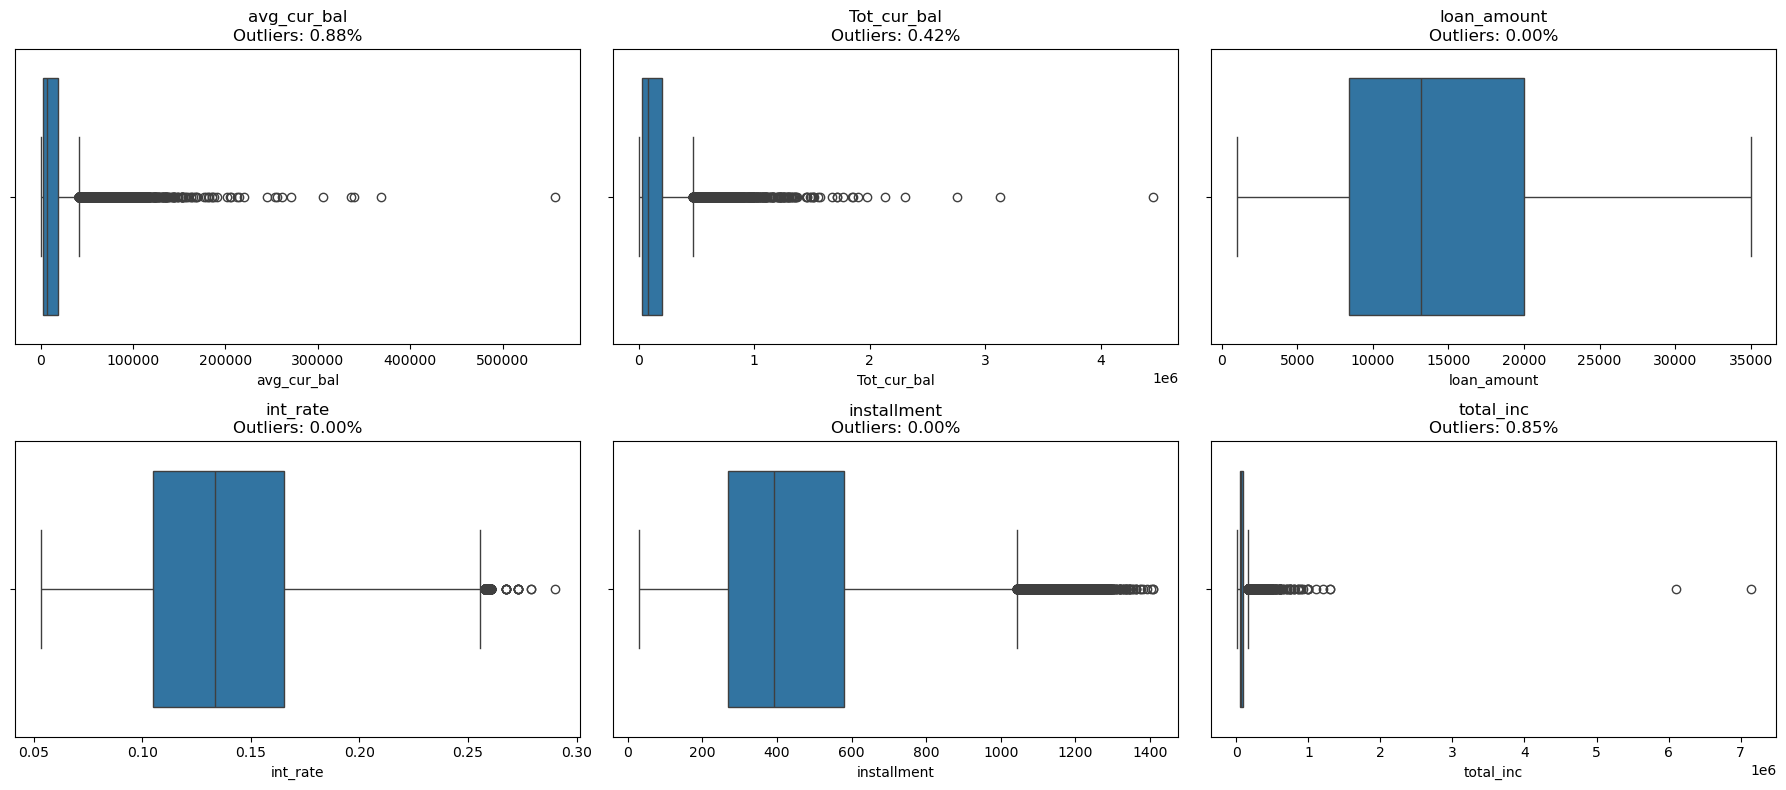

In [115]:
outlier_stats = {}

plt.figure(figsize=(18, n_rows * 4))
        
for i, col in enumerate(cols_to_process):
    # Calculate outlier boundaries
    Q1 = X_clean[col].quantile(0.10)
    Q3 = X_clean[col].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure non-negative for financial data
    upper_bound = Q3 + 1.5 * IQR
                
    outliers = X_clean[(X_clean[col] < lower_bound) | (X_clean[col] > upper_bound)]
    outlier_percentage = len(outliers) / len(X_clean) * 100
                
    # Store stats for reporting
    outlier_stats[col] = {
        'count': len(outliers),
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
                
    # Plot boxplot to visualize outliers - using 1-based indexing for subplot
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=X_clean[col])
    plt.title(f"{col}\nOutliers: {outlier_percentage:.2f}%")
    
    # Cap the outliers - preserve the shape of the distribution better with log transformation
    if X_clean[col].min() >= 0 and X_clean[col].skew() > 1:  # For highly positive skewed data
        # Apply log transform, cap, then transform back
        with np.errstate(divide='ignore'):  # Ignore log(0) warnings
            transformed = np.log1p(X_clean[col])
            
        t_Q1 = transformed.quantile(0.10)
        t_Q3 = transformed.quantile(0.90)
        t_IQR = t_Q3 - t_Q1
        t_lower = t_Q1 - 1.5 * t_IQR
        t_upper = t_Q3 + 1.5 * t_IQR
            
        transformed = transformed.clip(lower=t_lower, upper=t_upper)
        X_clean[col] = np.expm1(transformed)
    else:
        # Standard capping
        X_clean[col] = X_clean[col].clip(lower=lower_bound, upper=upper_bound)

plt.tight_layout()
plt.show()

Recalculate some features after handling outliers.

In [116]:
X_clean['payment_to_income'] = X_clean['installment'] / (X_clean['total_inc']/12)
X_clean['lti'] = X_clean['loan_amount'] / X_clean['total_inc']
X_clean['interest_burden'] = X_clean['int_rate'] * X_clean['loan_amount'] / X_clean['total_inc']
X_clean['bal_to_loan'] = X_clean['avg_cur_bal'] / X_clean['loan_amount']
X_clean['bal_to_income'] = X_clean['avg_cur_bal'] / X_clean['total_inc']
grade_avg_rate = X_clean.groupby('grade')['int_rate'].transform('mean') 
X_clean['rate_premium'] = X_clean['int_rate'] - grade_avg_rate
X_clean['total_debt_ratio'] = X_clean['Tot_cur_bal'] / X_clean['total_inc']
grade_avg_loan = X_clean.groupby('grade')['loan_amount'].transform('mean')
X_clean['relative_loan_size'] = X_clean['loan_amount'] / grade_avg_loan
X_clean['monthly_interest'] = (X_clean['int_rate'] / 100 / 12) * X_clean['loan_amount']
X_clean['interest_to_payment_ratio'] = X_clean['monthly_interest'] / X_clean['installment']
X_clean['loan_to_balance_ratio'] = X_clean['loan_amount'] / np.where(X_clean['Tot_cur_bal'] > 0, X_clean['Tot_cur_bal'], 1)

Train set: X_clean, y_train

Test set: X_test, y_test

In [117]:
X_train = X_clean

### 3.5 Feature Stability

In [118]:
def calculate_psi(expected, actual, bins=10):
    # Create bins based on the percentiles of the expected distribution
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    # Ensure the breakpoints are unique (in case of duplicate values)
    breakpoints = np.unique(breakpoints)
    
    # Calculate the histogram (bin counts) for expected and actual data
    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)
    
    # Convert counts to percentages
    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)
    
    # Replace any 0 values with a small number to avoid division by zero or log(0)
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # Calculate PSI for each bin and sum up
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi_value = np.sum(psi_values)
    
    return psi_value

In [119]:
def print_psi(feature, psi_val):
    level = 'LOW'
    if (psi_val > 0.1) & (psi_val <= 0.25):
        level = 'MEDIUM'
    elif psi_val > 0.25:
        level = 'HIGH'
    print(f"PSI for {feature}: {psi_val:.4f} - {level}")

In [120]:
# Calculate PSI for each feature
psi_results = {}

for feature in num_cols:
    psi_results[feature] = calculate_psi(X_train[feature].values, X_test[feature].values, bins=10)

for feature, psi_val in psi_results.items():
    print_psi(feature, psi_val)

PSI for emp_length: 0.0000 - LOW
PSI for avg_cur_bal: 0.0034 - LOW
PSI for Tot_cur_bal: 0.0054 - LOW
PSI for loan_amount: 0.0041 - LOW
PSI for int_rate: 0.1440 - MEDIUM
PSI for installment: 0.0039 - LOW
PSI for issue_month: 4.5147 - HIGH
PSI for issue_quarter: 5.1485 - HIGH
PSI for issue_year_num: 2.1848 - HIGH
PSI for loan_age_days: 6.9287 - HIGH
PSI for total_inc: 0.0297 - LOW
PSI for payment_to_income: 0.0094 - LOW
PSI for lti: 0.0021 - LOW
PSI for interest_burden: 0.0225 - LOW
PSI for bal_to_loan: 0.0009 - LOW
PSI for bal_to_income: 0.0032 - LOW
PSI for rate_premium: 0.8014 - HIGH
PSI for total_debt_ratio: 0.0034 - LOW
PSI for relative_loan_size: 0.0033 - LOW
PSI for monthly_interest: 0.0168 - LOW
PSI for interest_to_payment_ratio: 0.0637 - LOW
PSI for loan_to_balance_ratio: 0.0018 - LOW


## 4. Data Pipeline

In [121]:
# Split features by type
cat = [col for col in cat_cols if col != 'grade']
ordinal_cat = ['grade']  

# Define ordinal mapping for grade
grade_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [122]:
cat, ordinal_cat, num_cols

(['home_ownership',
  'verification_status',
  'term',
  'purpose',
  'subregion',
  'job_level',
  'profession'],
 ['grade'],
 ['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'loan_age_days',
  'total_inc',
  'payment_to_income',
  'lti',
  'interest_burden',
  'bal_to_loan',
  'bal_to_income',
  'rate_premium',
  'total_debt_ratio',
  'relative_loan_size',
  'monthly_interest',
  'interest_to_payment_ratio',
  'loan_to_balance_ratio'])

In [123]:
# Define preprocessing steps
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[grade_categories]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', cat_pipeline, cat),
        ('ord_cat', ordinal_cat_pipeline, ordinal_cat)
    ],
    verbose_feature_names_out=False
)

In [124]:
# Fit and transform train set
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
# Transform test set
X_test_preprocessed = preprocessor.transform(X_test)

In [125]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['emp_length', 'avg_cur_bal', 'Tot_cur_bal',
                                  'loan_amount', 'int_rate', 'installment',
                                  'issue_month', 'issue_quarter',
                                  'issue_year_num', 'loan_age_days',
                                  'total_inc', 'payment_to_income', 'lti',
                                  'interest_burden', 'bal_to_loan',
                                  'bal_t...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['home_ownership', 'verification_status',
                                  'term', 'purpose', 'subregion', 'job_level',
                                  'profession']),
                                ('ord_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']]))]),
                                 ['grade'])],
                  verbose_feature_names_out=False)

In [126]:
X_train.shape, X_train_preprocessed.shape

((57435, 30), (57435, 67))

After the preprocessing process, the data increased from 30 columns to 67 columns due to the use of One-Hot Encoding on categorical variables.

In [127]:
sparsity_train = 1 - (np.count_nonzero(X_train) / X_train.size)
sparsity_preprocessed = 1 - (np.count_nonzero(X_train_preprocessed) / X_train_preprocessed.size)

In [128]:
sparsity_train, sparsity_preprocessed

(0.0, 0.5545817530264582)

The original training data is almost dense, after preprocessing, the dataset has become sparser.

## 5. Model Perfomance

**Assess model performance**

In [129]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Gini
    gini = 2 * roc_auc - 1
    
    # Precision-Recall AUC
    if y_prob is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
    else:
        pr_auc = None
    
    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Gini: {gini:.4f}")
    if pr_auc is not None:
        print(f"PR AUC: {pr_auc:.4f}")

    # Plot 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['On Time Payment', 'Late Payment'],
                yticklabels=['On Time Payment', 'Late Payment'], ax=axs[0,0])
    axs[0, 0].set_title(f'Confusion Matrix - {model_name}')
    axs[0, 0].set_xlabel('Predicted')
    axs[0, 0].set_ylabel('Actual')
    
    # ROC curve
    if y_prob is not None:
        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_predictions(y_test, y_prob, name=model_name, ax=axs[0, 1])
        axs[0, 1].plot([0, 1], [0, 1], 'k--')
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].set_title(f'ROC Curve - {model_name}')
    
    # Precision-Recall curve
    if y_prob is not None:
        from sklearn.metrics import PrecisionRecallDisplay
        PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=model_name, ax=axs[1, 0])
        axs[1, 0].set_xlabel('Recall')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_title(f'Precision-Recall Curve - {model_name}')

    # KDE plot
    if y_prob is not None:
        df_rank = pd.DataFrame({
            'label': y_test,
            'score': y_prob
        })
        sns.kdeplot(data=df_rank, x='score', hue='label', common_norm=True, multiple="fill", ax=axs[1, 1])
        axs[1, 1].set_title(f'KDE - {model_name}')
        axs[1, 1].set_xlim(0, 1)
        axs[1, 1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return {
        'model': model_name,
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

### # Approach 1: Baseline Model with Logistic Regression

In [130]:
logistic_regression_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
     ])


--- Logistic Regression Results ---
Accuracy: 0.6389
Balanced Accuracy: 0.6468
Precision: 0.2895
Recall/Sensitivity: 0.6594
F1 Score: 0.4023
Matthews Correlation Coefficient: 0.2307
ROC AUC: 0.7034
Gini: 0.4068
PR AUC: 0.3416


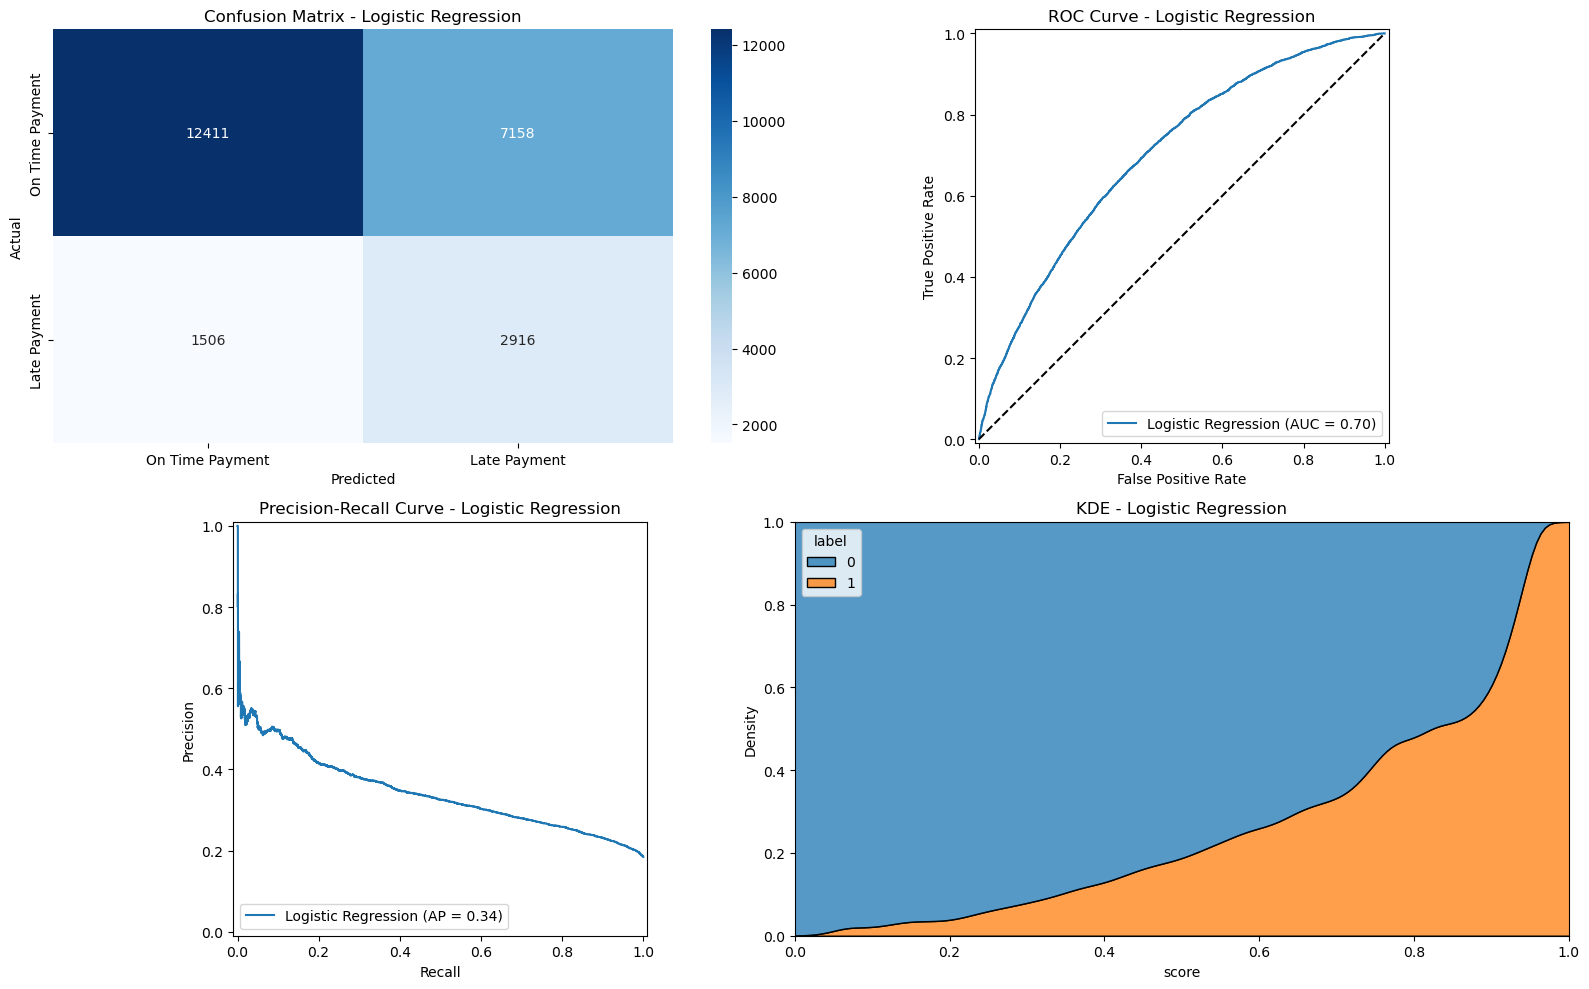

In [131]:
logistic_regression_model.fit(X_train, y_train)
logistic_regression_model_results = evaluate_model(logistic_regression_model, X_test, y_test, "Logistic Regression")

In [132]:
# Predict train & test
y_train_pred = logistic_regression_model.predict(X_train)
y_test_pred = logistic_regression_model.predict(X_test)

y_train_prob = logistic_regression_model.predict_proba(X_train)[:, 1]
y_test_prob = logistic_regression_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.3647 | Test: 0.4023
Recall Train: 0.6520 | Test: 0.6594
PSI for Prob score: 0.0058 - LOW


### # Approach 2: Undersampling with Balanced Random Forest

In [133]:
balanced_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BalancedRandomForestClassifier(
        random_state=42,
        n_estimators=100,
        sampling_strategy='auto',  # Uses undersampling internally
        replacement=False,
        bootstrap=True
    ))
])


--- Balanced Random Forest Results ---
Accuracy: 0.6459
Balanced Accuracy: 0.6380
Precision: 0.2880
Recall/Sensitivity: 0.6255
F1 Score: 0.3944
Matthews Correlation Coefficient: 0.2184
ROC AUC: 0.6889
Gini: 0.3777
PR AUC: 0.3206


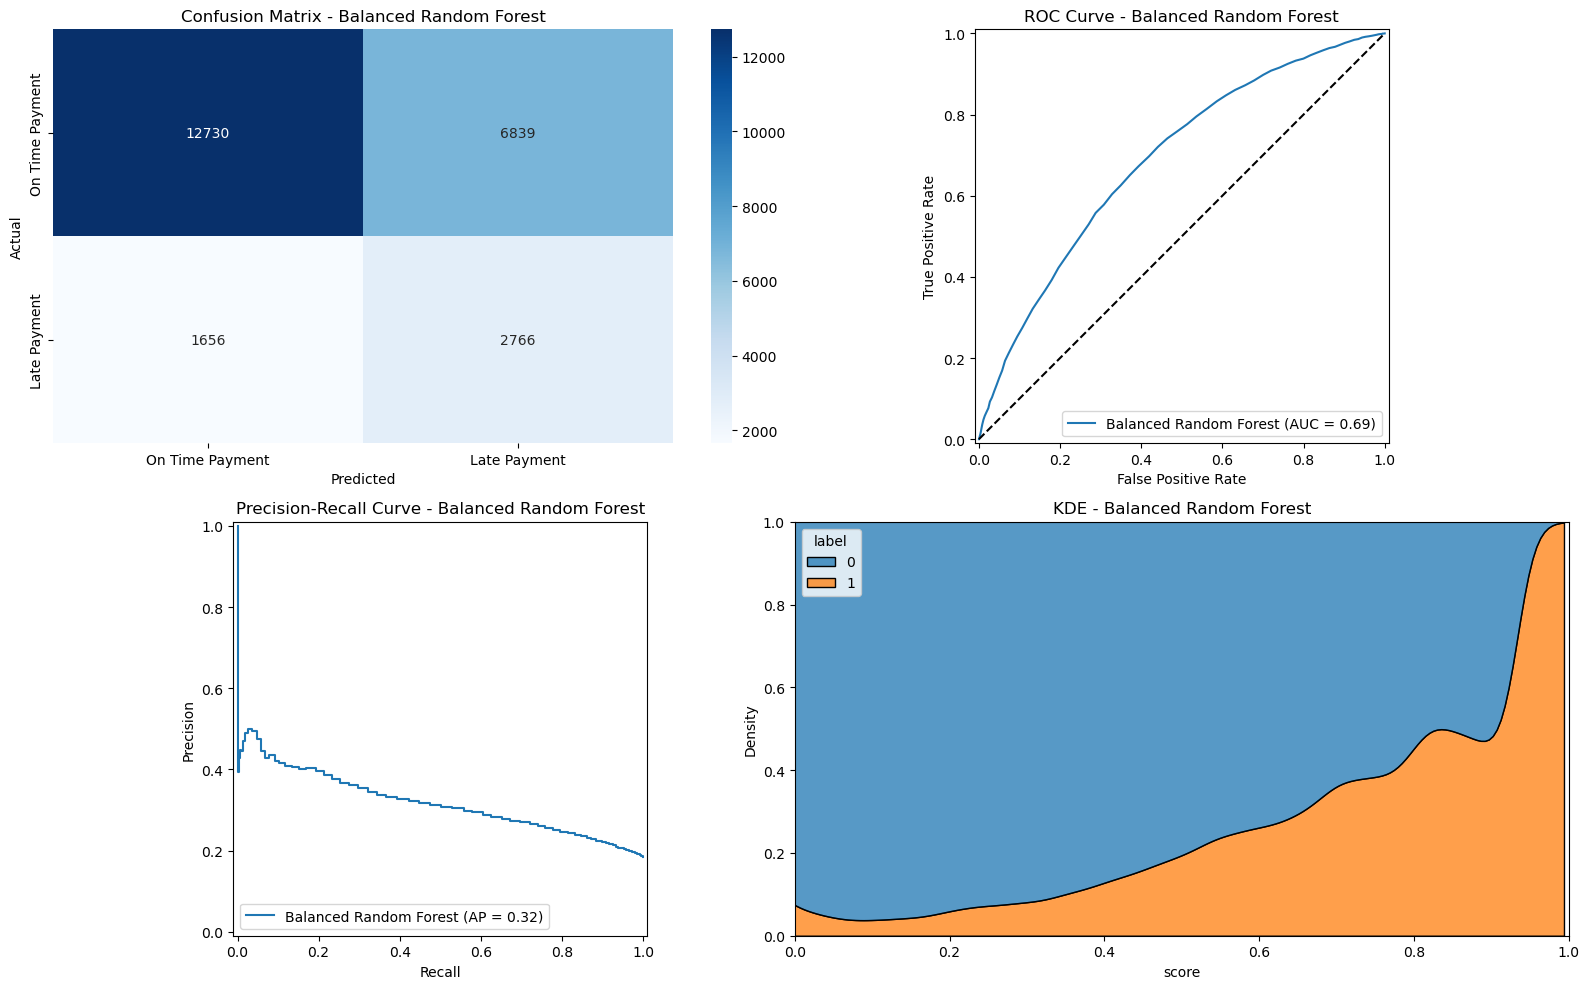

In [134]:
balanced_rf_model.fit(X_train, y_train)
balanced_rf_model_results = evaluate_model(balanced_rf_model, X_test, y_test, "Balanced Random Forest")

In [135]:
# Predict train & test
y_train_pred = balanced_rf_model.predict(X_train)
y_test_pred = balanced_rf_model.predict(X_test)

y_train_prob = balanced_rf_model.predict_proba(X_train)[:, 1]
y_test_prob = balanced_rf_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.6267 | Test: 0.3944
Recall Train: 1.0000 | Test: 0.6255
PSI for Prob score: 0.3500 - HIGH


The model is overfitting and unstable (with a very high PSI).

### # Approach 3: LightGBM with built-in imbalance handling

In [136]:
lgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        is_unbalance=True,  # Built-in handling for imbalanced data
        class_weight={0: 1, 1: Counter(y_train)[0]/Counter(y_train)[1]},  # Class weighting
        objective='binary',
        metric='auc',
        boost_from_average=False,  # Important for imbalanced data
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.1
    ))
])

[LightGBM] [Info] Number of positive: 9496, number of negative: 47939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4341
[LightGBM] [Info] Number of data points in the train set: 57435, number of used features: 66

--- LightGBM (Imbalance-Aware) Results ---
Accuracy: 0.3255
Balanced Accuracy: 0.5664
Precision: 0.2081
Recall/Sensitivity: 0.9480
F1 Score: 0.3413
Matthews Correlation Coefficient: 0.1403
ROC AUC: 0.6884
Gini: 0.3767
PR AUC: 0.3321


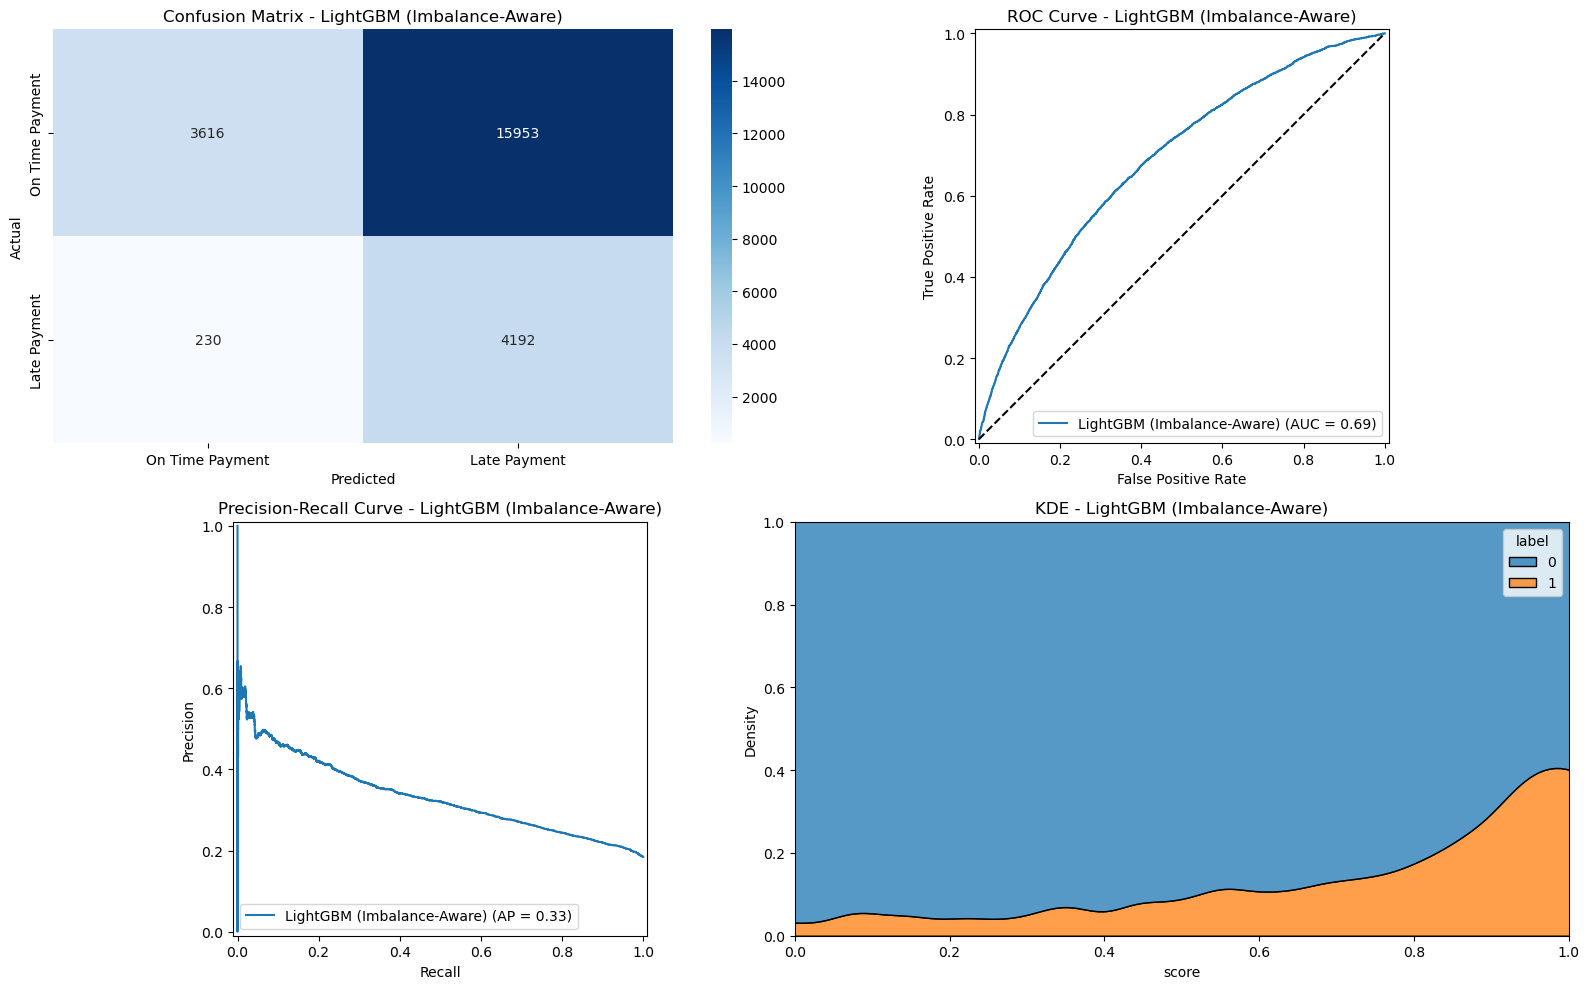

In [137]:
lgb_model.fit(X_train, y_train)
lgb_model_results = evaluate_model(lgb_model, X_test, y_test, "LightGBM (Imbalance-Aware)")

In [138]:
# Predict train & test
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

y_train_prob = lgb_model.predict_proba(X_train)[:, 1]
y_test_prob = lgb_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.3201 | Test: 0.3413
Recall Train: 0.9999 | Test: 0.9480
PSI for Prob score: 0.0193 - LOW


LightGBM (Imbalance-Aware) shows a remarkably high recall (0.9460), meaning it identifies almost all actual defaults. However, this comes at the cost of significantly low precision (0.2075) and low F1 score and balanced accuracy. This model generate a very high number of false positives.

### # Approach 4: CatBoost with custom loss

In [139]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()

In [140]:
# Build CatBoost with more advanced settings
model = CatBoostClassifier(
    random_seed=42,
    loss_function='Logloss',  # Binary classification loss
    eval_metric='AUC:hints=skip_train~false',  # Track AUC on train and validation
    iterations=300,
    learning_rate=0.05,
    depth=6,
    min_data_in_leaf=5,
    l2_leaf_reg=3,
    random_strength=0.1,
    class_weights=[1, Counter(y_train)[0] / Counter(y_train)[1]],  # Class weighting
    boosting_type='Plain',  # More robust than default
    bootstrap_type='Bernoulli',
    subsample=0.8,  # Use 80% of data for each tree
    verbose=False
)

In [141]:
# Create CatBoost Pool for better control
train_pool = Pool(
    data=X_train_processed,
    label=y_train,
    feature_names=list(feature_names)
)

In [142]:
# Train model
model.fit(train_pool)

In [143]:
catboost_model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


--- CatBoost Results ---
Accuracy: 0.6411
Balanced Accuracy: 0.6476
Precision: 0.2907
Recall/Sensitivity: 0.6578
F1 Score: 0.4032
Matthews Correlation Coefficient: 0.2321
ROC AUC: 0.7026
Gini: 0.4051
PR AUC: 0.3426


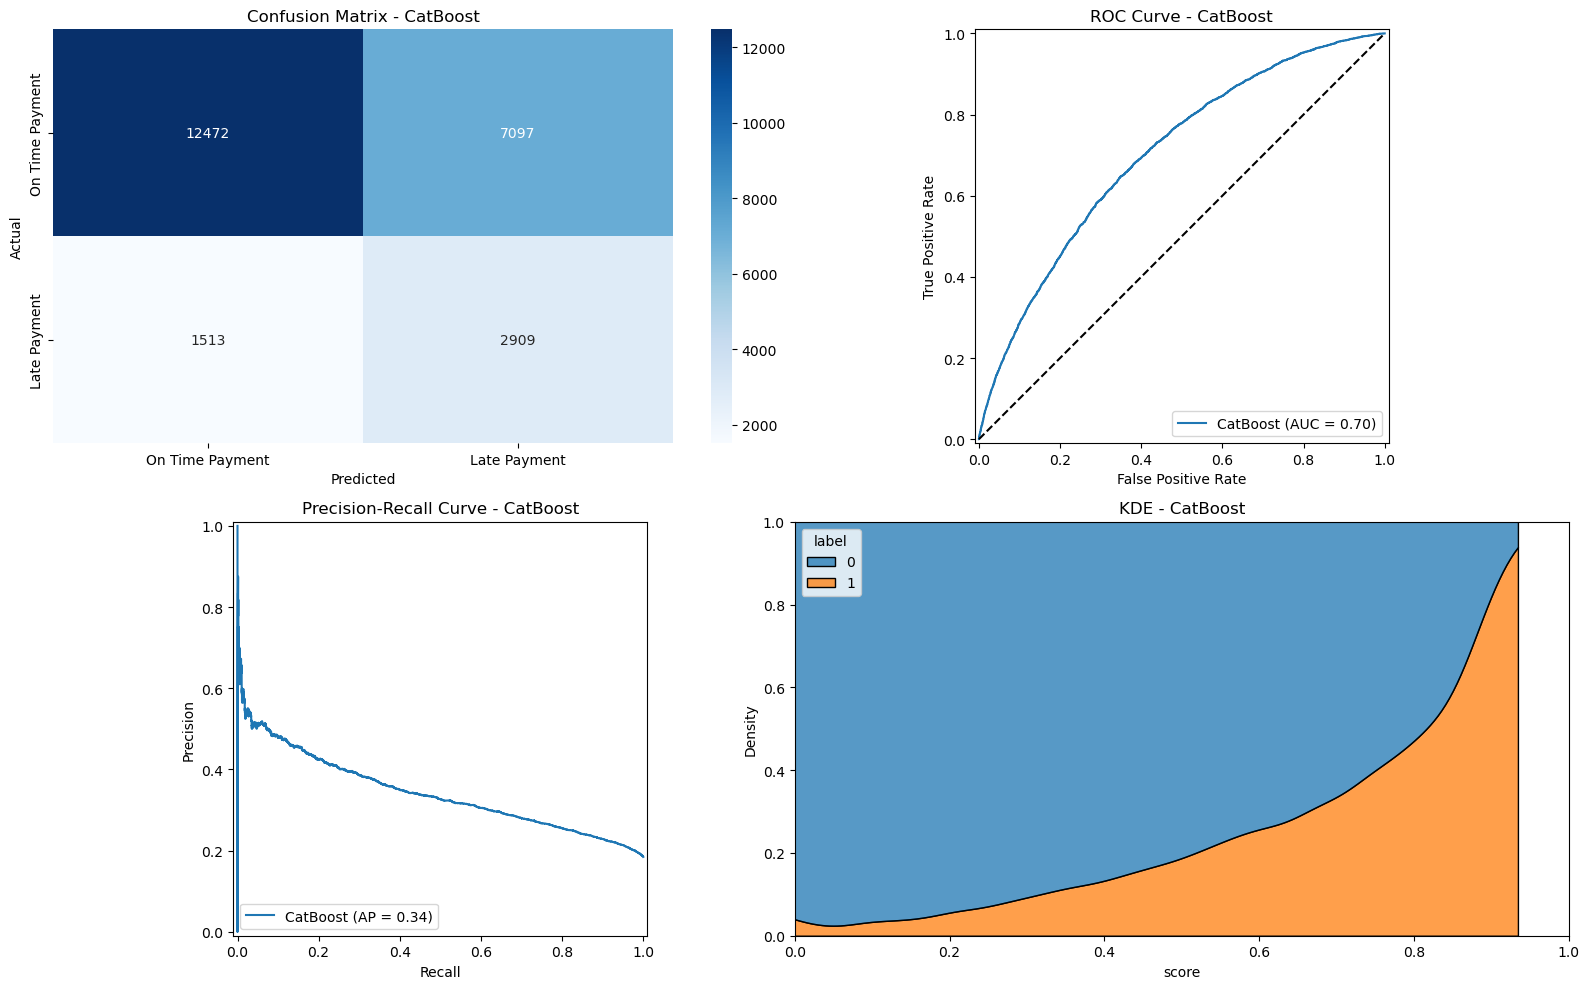

In [144]:
catboost_model.fit(X_train, y_train)
catboost_model_results = evaluate_model(catboost_model, X_test, y_test, "CatBoost")

In [145]:
# Predict train & test
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

y_train_prob = catboost_model.predict_proba(X_train)[:, 1]
y_test_prob = catboost_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.4092 | Test: 0.4032
Recall Train: 0.7117 | Test: 0.6578
PSI for Prob score: 0.0124 - LOW


### # Approach 5: Cost-sensitive XGBoost with focal loss

In [146]:
# Focal loss helps focus on hard examples and downweights easy ones
xgb_focal_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='aucpr',
        gamma=2.0  # Focal loss parameter - focuses on hard examples
    ))
])


--- XGBoost with Focal Loss Results ---
Accuracy: 0.6347
Balanced Accuracy: 0.6423
Precision: 0.2857
Recall/Sensitivity: 0.6542
F1 Score: 0.3977
Matthews Correlation Coefficient: 0.2234
ROC AUC: 0.6975
Gini: 0.3950
PR AUC: 0.3390


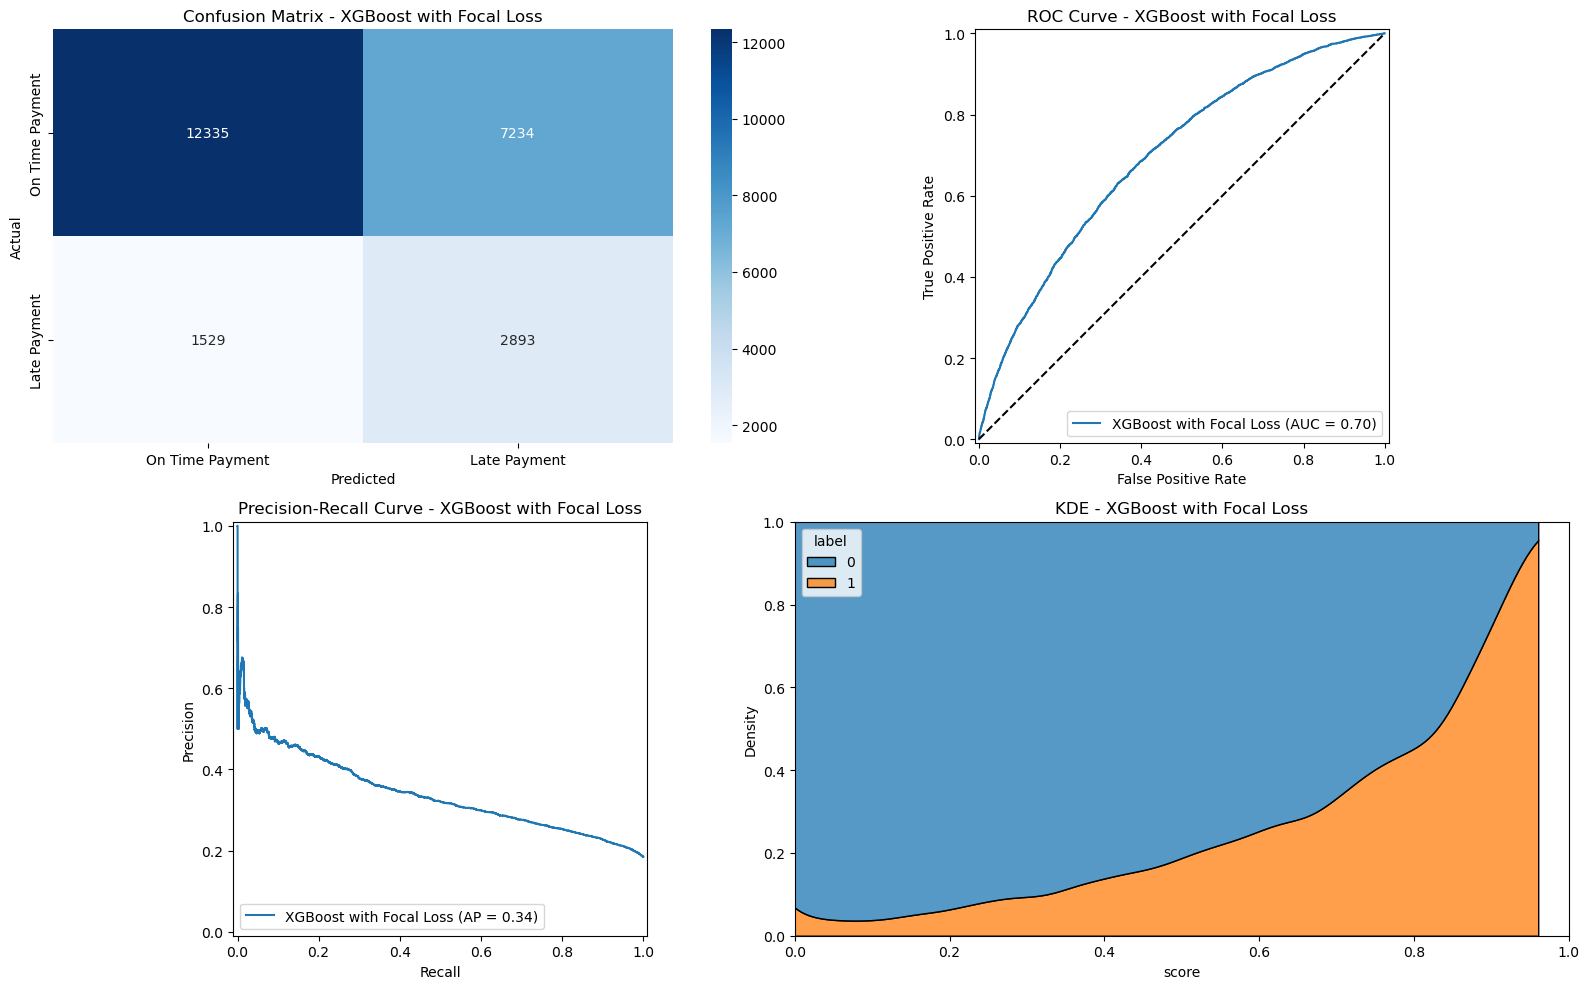

In [147]:
xgb_focal_model.fit(X_train, y_train)
xgb_focal_model_results = evaluate_model(xgb_focal_model, X_test, y_test, "XGBoost with Focal Loss")

In [148]:
# Predict train & test
y_train_pred = xgb_focal_model.predict(X_train)
y_test_pred = xgb_focal_model.predict(X_test)

y_train_prob = xgb_focal_model.predict_proba(X_train)[:, 1]
y_test_prob = xgb_focal_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.4143 | Test: 0.3977
Recall Train: 0.7206 | Test: 0.6542
PSI for Prob score: 0.0131 - LOW


### # Approach 6: Weighted voting ensemble

In [149]:
# Define base classifiers
estimators1 = [
    ('lgb', lgb.LGBMClassifier(
        random_state=42,
        is_unbalance=True,
        class_weight={0: 1, 1: Counter(y_train)[0]/Counter(y_train)[1]},
        objective='binary',
        metric='auc',
        boost_from_average=False,
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.05
    )),
    ('cat', CatBoostClassifier(
        random_seed=42,
        auto_class_weights='Balanced',
        loss_function='Logloss',
        eval_metric='AUC',
        iterations=100,
        depth=6,
        learning_rate=0.05,
        verbose=False
    )),
    ('xgb', XGBClassifier(
        random_state=42,
        scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='aucpr',
        gamma=2.0
    ))
]

In [150]:
# Create voting classifier with optimized weights
# Give more weight to better performing models
voting_clf = VotingClassifier(
    estimators=estimators1,
    voting='soft',
    weights=[1,4,3] 
)

In [151]:
weighted_voting_model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', voting_clf)
    ])

In [152]:
weighted_voting_model.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 9496, number of negative: 47939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4341
[LightGBM] [Info] Number of data points in the train set: 57435, number of used features: 66


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['emp_length', 'avg_cur_bal',
                                                   'Tot_cur_bal', 'loan_amount',
                                                   'int_rate', 'installment',
                                                   'issue_month',
                                                   'issue_quarter',
                                                   'issue_year_num',
                                                   'loan_age_days', 'total_inc',
                                                   'payment_to_income', 'lti',
                                                   'inter...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                  voting='soft', weights=[1, 4, 3]))])


--- Weighted Voting Ensemble Model Results ---
Accuracy: 0.5833
Balanced Accuracy: 0.6464
Precision: 0.2711
Recall/Sensitivity: 0.7463
F1 Score: 0.3977
Matthews Correlation Coefficient: 0.2271
ROC AUC: 0.7045
Gini: 0.4091
PR AUC: 0.3451


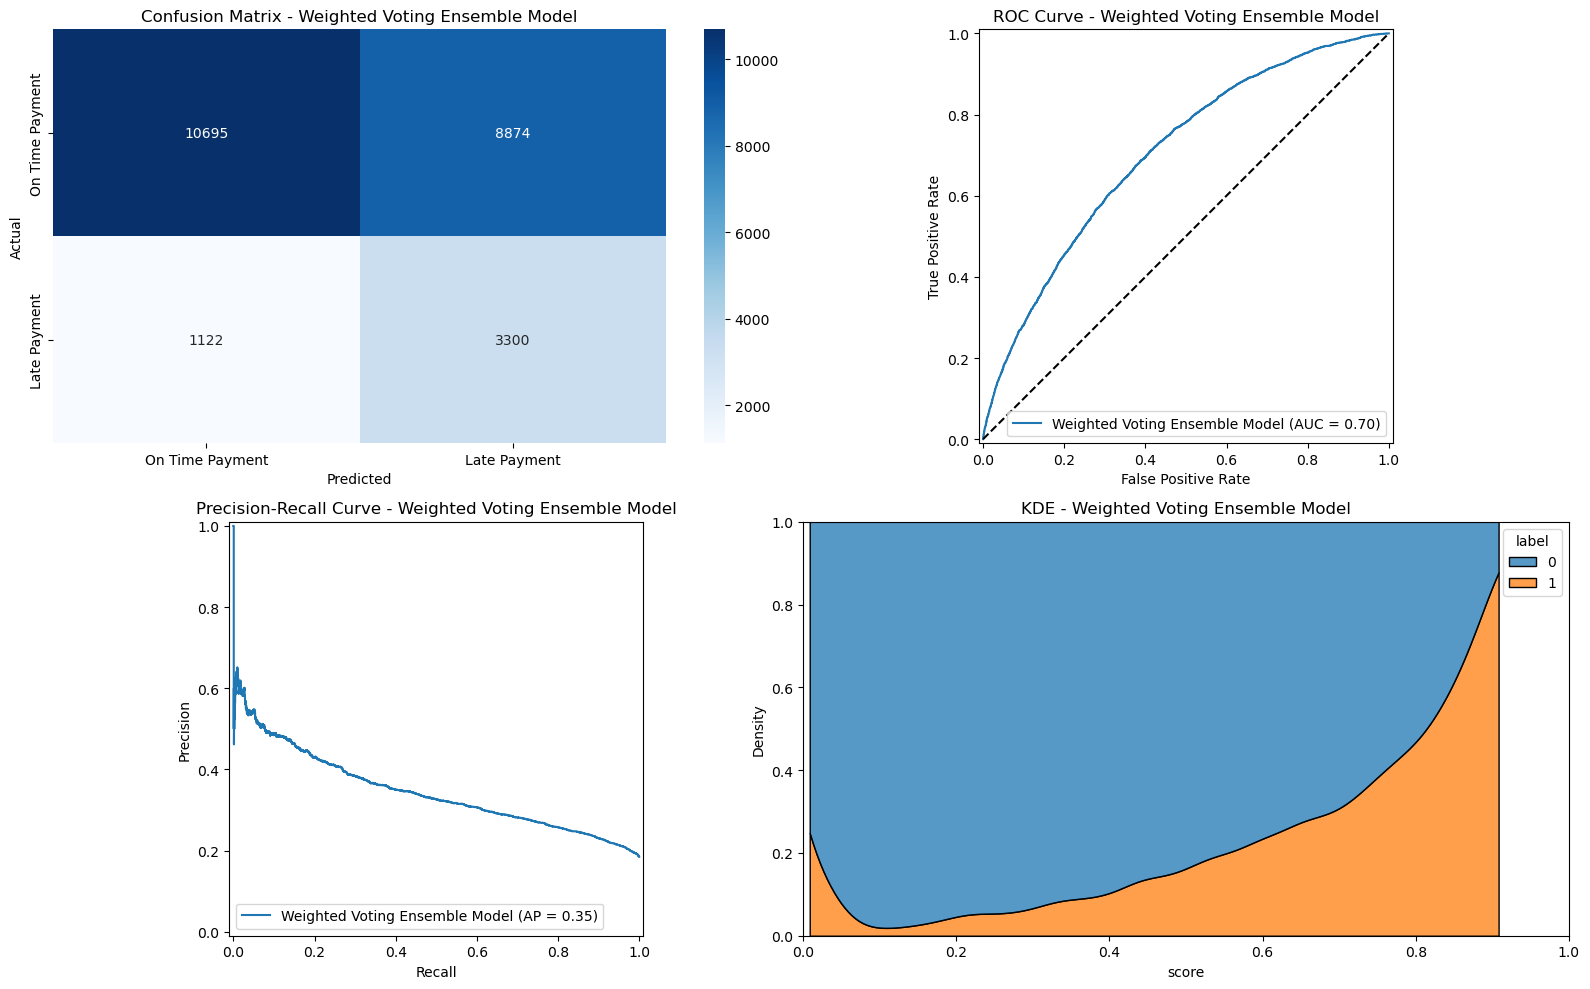

In [153]:
weighted_voting_model_results = evaluate_model(weighted_voting_model, X_test, y_test, "Weighted Voting Ensemble Model")

In [154]:
# Predict train & test
y_train_pred = weighted_voting_model.predict(X_train)
y_test_pred = weighted_voting_model.predict(X_test)

y_train_prob = weighted_voting_model.predict_proba(X_train)[:, 1]
y_test_prob = weighted_voting_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.3832 | Test: 0.3977
Recall Train: 0.7880 | Test: 0.7463
PSI for Prob score: 0.0109 - LOW


### # Approach 7: Stacked Ensemble model

In [155]:
# Base classifiers
estimators2 = [
    ('lgb', lgb.LGBMClassifier(
        random_state=42,
        is_unbalance=True,
        class_weight={0: 1, 1: Counter(y_train)[0]/Counter(y_train)[1]},
        objective='binary',
        metric='auc',
        boost_from_average=False,
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.05,
        importance_type='gain'
    )),
    ('xgb', XGBClassifier(
        random_state=42,
        scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
        max_depth=5,
        learning_rate=0.05,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='aucpr',
        gamma=2.0
    )),
    ('cat', CatBoostClassifier(
        random_seed=42,
        auto_class_weights='Balanced',
        loss_function='Logloss',
        eval_metric='AUC',
        iterations=100,
        depth=6,
        learning_rate=0.05,
        verbose=False
    ))
]

In [156]:
# Meta learner
final_estimator = LogisticRegression(random_state=42, class_weight='balanced', C=0.1)

In [157]:
# Build the stacking classifier
stacked_model = StackingClassifier(
    estimators=estimators2,
    final_estimator=final_estimator,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1,
    verbose=0
)

In [158]:
# Full pipeline
stacked_ensemble_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacked_model)
])

In [159]:
stacked_ensemble_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['emp_length', 'avg_cur_bal',
                                                   'Tot_cur_bal', 'loan_amount',
                                                   'int_rate', 'installment',
                                                   'issue_month',
                                                   'issue_quarter',
                                                   'issue_year_num',
                                                   'loan_age_days', 'total_inc',
                                                   'payment_to_income', 'lti',
                                                   'inter...
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('cat',
                                                 <catboost.core.CatBoostClassifier object at 0x000001F5C4B204D0>)],
                                    final_estimator=LogisticRegression(C=0.1,
                                                                       class_weight='balanced',
                                                                       random_state=42),
                                    n_jobs=-1, stack_method='predict_proba'))])


--- Stacked Ensemble Model Results ---
Accuracy: 0.5907
Balanced Accuracy: 0.6468
Precision: 0.2733
Recall/Sensitivity: 0.7356
F1 Score: 0.3985
Matthews Correlation Coefficient: 0.2277
ROC AUC: 0.7039
Gini: 0.4079
PR AUC: 0.3448


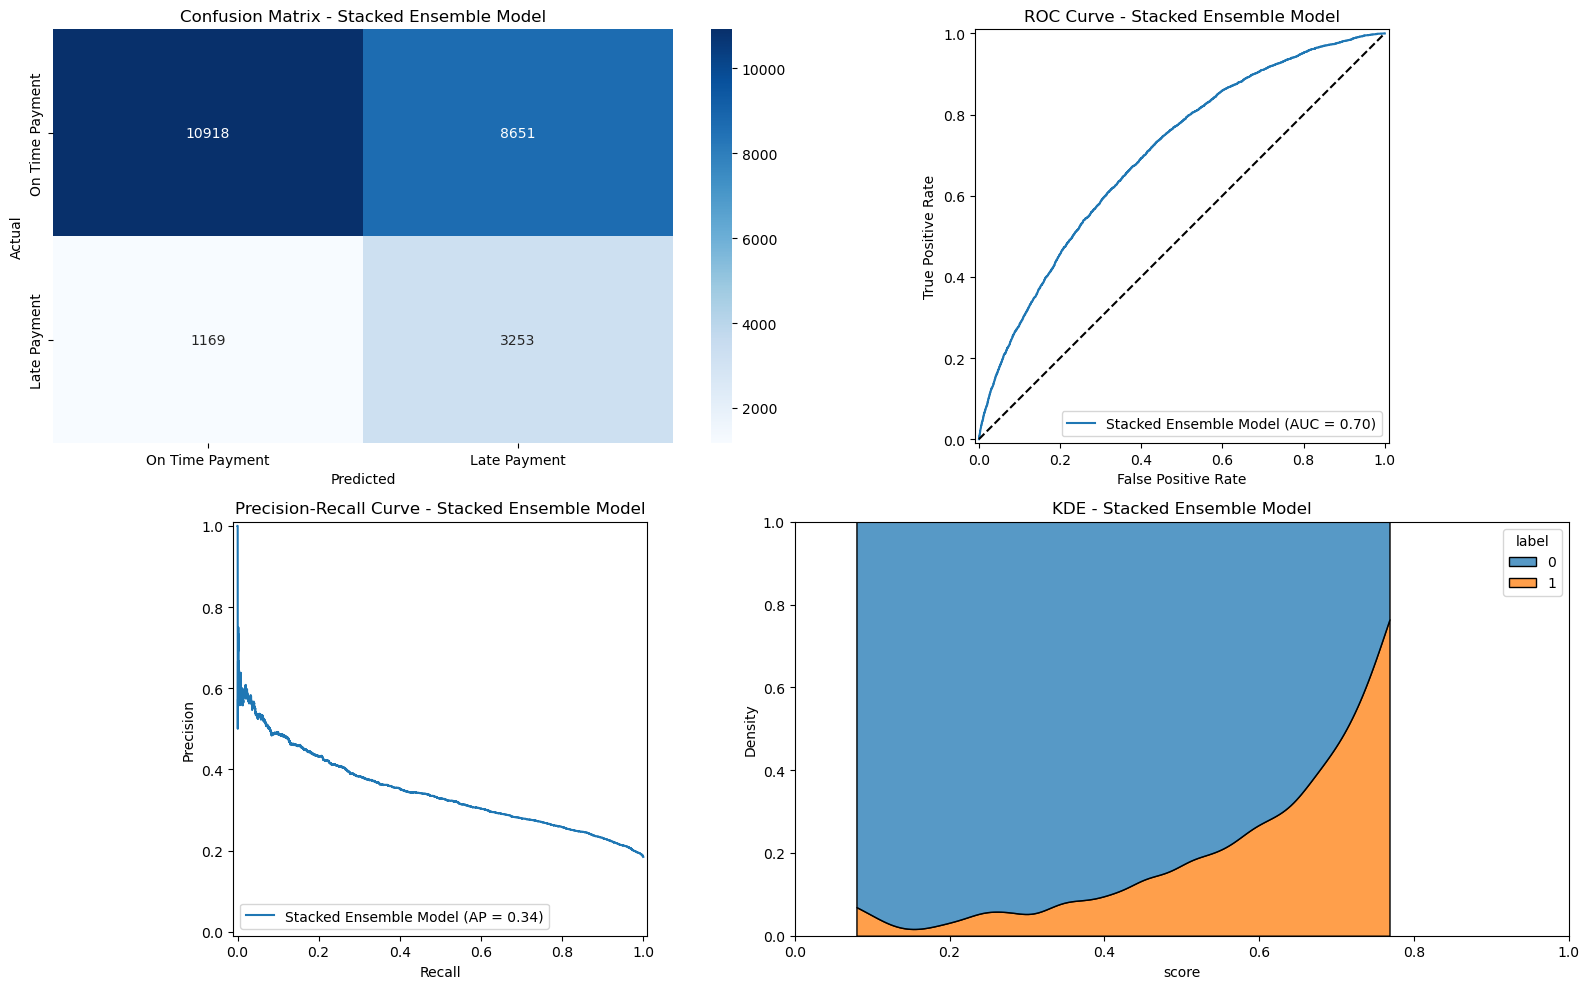

In [160]:
stacked_ensemble_model_results = evaluate_model(stacked_ensemble_model, X_test, y_test, "Stacked Ensemble Model")

In [161]:
# Predict train & test
y_train_pred = stacked_ensemble_model.predict(X_train)
y_test_pred = stacked_ensemble_model.predict(X_test)

y_train_prob = stacked_ensemble_model.predict_proba(X_train)[:, 1]
y_test_prob = stacked_ensemble_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"Recall Train: {recall_train:.4f} | Test: {recall_test:.4f}")
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))

F1 Train: 0.3817 | Test: 0.3985
Recall Train: 0.7737 | Test: 0.7356
PSI for Prob score: 0.0135 - LOW


### # Compare all models

In [162]:
all_results = [logistic_regression_model_results, balanced_rf_model_results, xgb_focal_model_results, catboost_model_results, lgb_model_results, weighted_voting_model_results, stacked_ensemble_model_results]

results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('model')

<Figure size 1400x800 with 0 Axes>

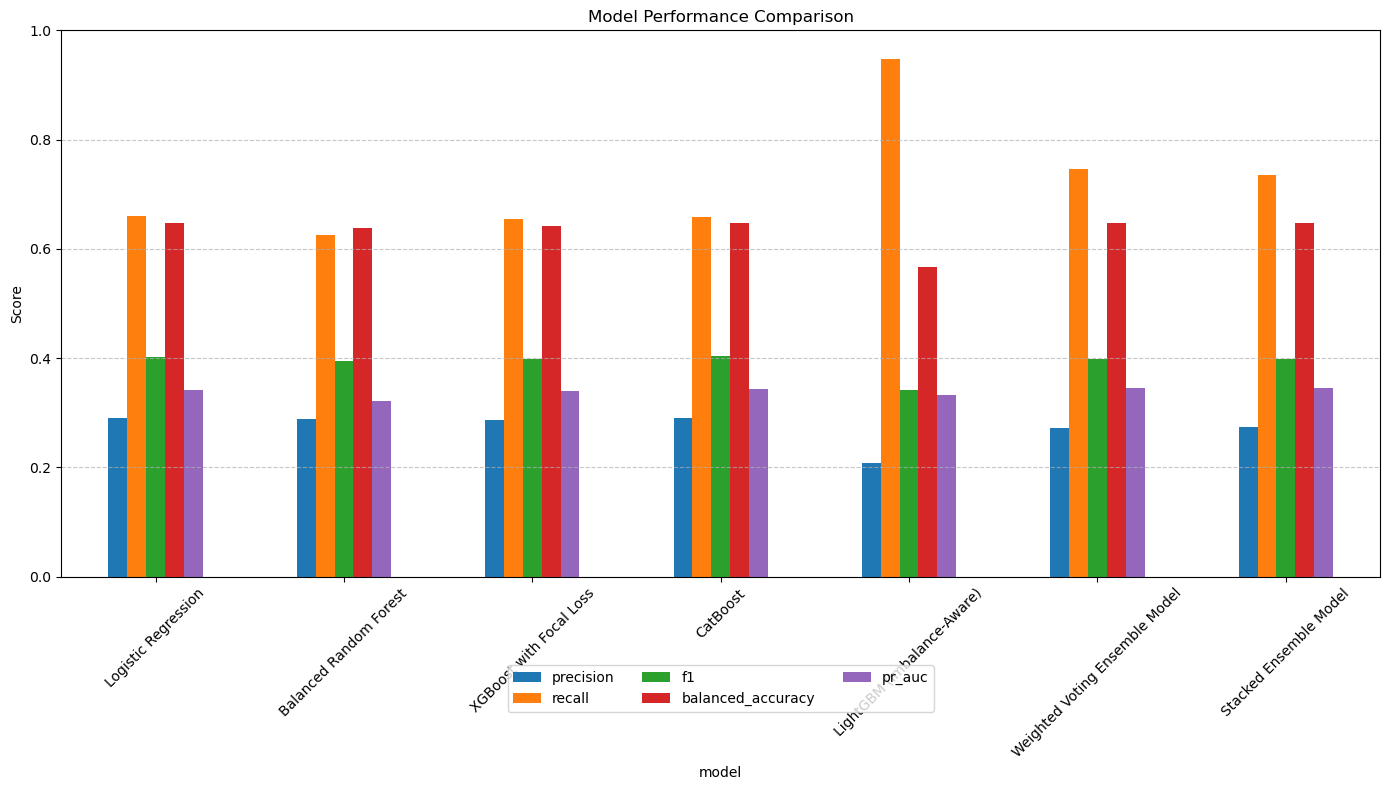

In [163]:
# Plot comparison of key metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['precision', 'recall', 'f1', 'balanced_accuracy', 'pr_auc']
results_df[metrics_to_plot].plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

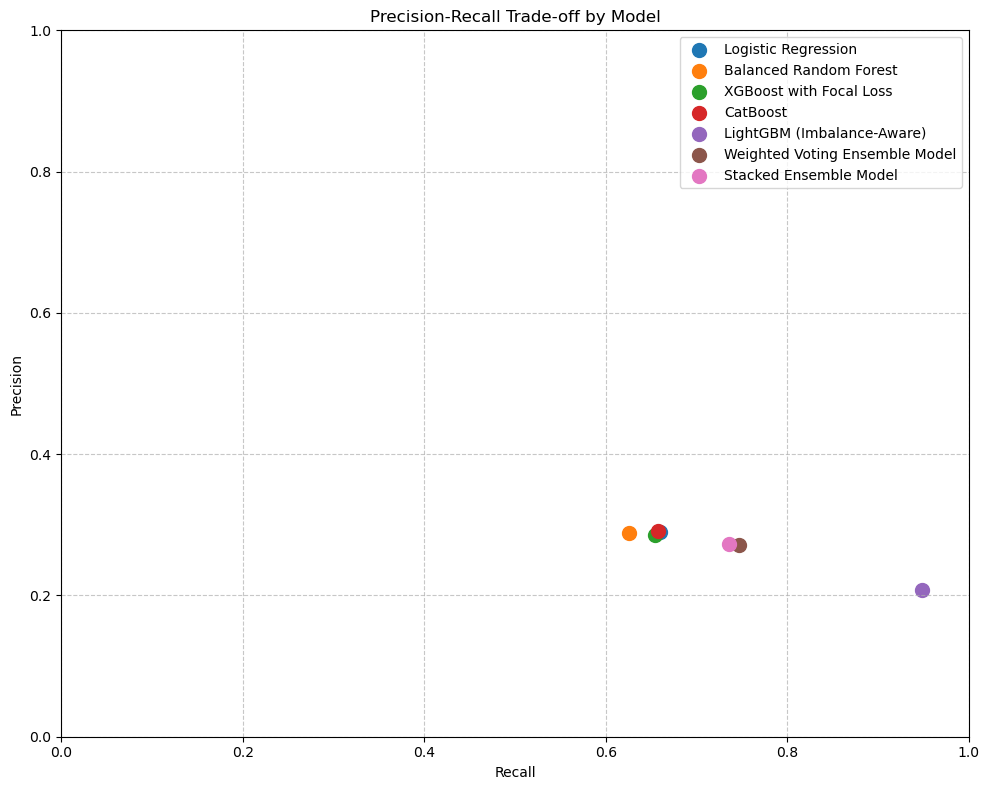

In [164]:
# Precision-Recall trade-off visualization 
plt.figure(figsize=(10, 8))
for idx, (model_name, row) in enumerate(results_df.iterrows()):
    plt.scatter(row['recall'], row['precision'], s=100, label=model_name)
    
plt.title('Precision-Recall Trade-off by Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [165]:
# Print the final table for easy comparison
pd.set_option('display.width', 1000)
print("\n--- Final Model Comparison ---")
print(results_df[['precision', 'recall', 'f1', 'balanced_accuracy', 'pr_auc']])


--- Final Model Comparison ---
                                precision    recall        f1  balanced_accuracy    pr_auc
model                                                                                     
Logistic Regression              0.289458  0.659430  0.402318           0.646824  0.341633
Balanced Random Forest           0.287975  0.625509  0.394382           0.638014  0.320649
XGBoost with Focal Loss          0.285672  0.654229  0.397691           0.642281  0.338969
CatBoost                         0.290726  0.657847  0.403244           0.647591  0.342556
LightGBM (Imbalance-Aware)       0.208091  0.947987  0.341271           0.566385  0.332106
Weighted Voting Ensemble Model   0.271069  0.746269  0.397686           0.646398  0.345080
Stacked Ensemble Model           0.273269  0.735640  0.398505           0.646782  0.344765


Based on the metrics, the Weighted Voting Ensemble Model and Stacked Ensemble Model models appear to be the strongest performers. They offer a good balance of high recall and reasonable precision, resulting in strong balanced accuracy and PR AUC scores.

Considering the goals of late payment prediction (maximizing the identification of late payment loans while maintaining a reasonable level of incorrect classifications), Weighted Voting Ensemble Model seem to be the top contender due to it combination of high recall and competitive balanced accuracy/PR AUC.

## 6. Analyze feature importance of the best model

In [138]:
best_model = weighted_voting_model

In [139]:
def get_average_feature_importances(model):
    if hasattr(model, 'named_steps') and 'classifier' in best_model.named_steps:
        classifier = model.named_steps['classifier']

        if isinstance(classifier, type(model.named_steps['classifier'])) and hasattr(classifier, 'estimators_'):
            print("Ensemble model detected - averaging feature importances across all base estimators")

            importances_list = []
            for est in classifier.estimators_: 
                if hasattr(est, 'feature_importances_'):
                    importances_list.append(est.feature_importances_)

            if not importances_list:
                print("No base estimator with feature_importances_ found.")
                return None

            avg_importances = np.mean(importances_list, axis=0)
        
        elif hasattr(classifier, 'feature_importances_'):
            print("Single model detected - using its feature importances")
            avg_importances = classifier.feature_importances_
        
        else:
            print("Cannot extract feature importance from this model type")
            return None
        
        feature_names = model.named_steps['preprocessor'].get_feature_names_out()
        
        # Create DataFrame and sort
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': avg_importances
        }).sort_values('Importance', ascending=False)
        
        return importance_df
    
    else:
        print("Model format not recognized for feature importance extraction")
        return None

Ensemble model detected - averaging feature importances across all base estimators

=== TOP 20 IMPORTANT FEATURES ===
                      Feature  Importance
4                    int_rate   73.304386
1                 avg_cur_bal   59.182934
9               loan_age_days   56.854194
13            interest_burden   56.148222
14                bal_to_loan   54.757478
20  interest_to_payment_ratio   53.099133
10                  total_inc   52.571564
2                 Tot_cur_bal   46.221122
17           total_debt_ratio   46.024124
21      loan_to_balance_ratio   44.595861
19           monthly_interest   41.800093
15              bal_to_income   34.467899
18         relative_loan_size   31.922480
12                        lti   31.627851
11          payment_to_income   30.458155
16               rate_premium   30.125726
6                 issue_month   27.234491
66                      grade   26.325592
0                  emp_length   25.346968
3                 loan_amount   21.600605


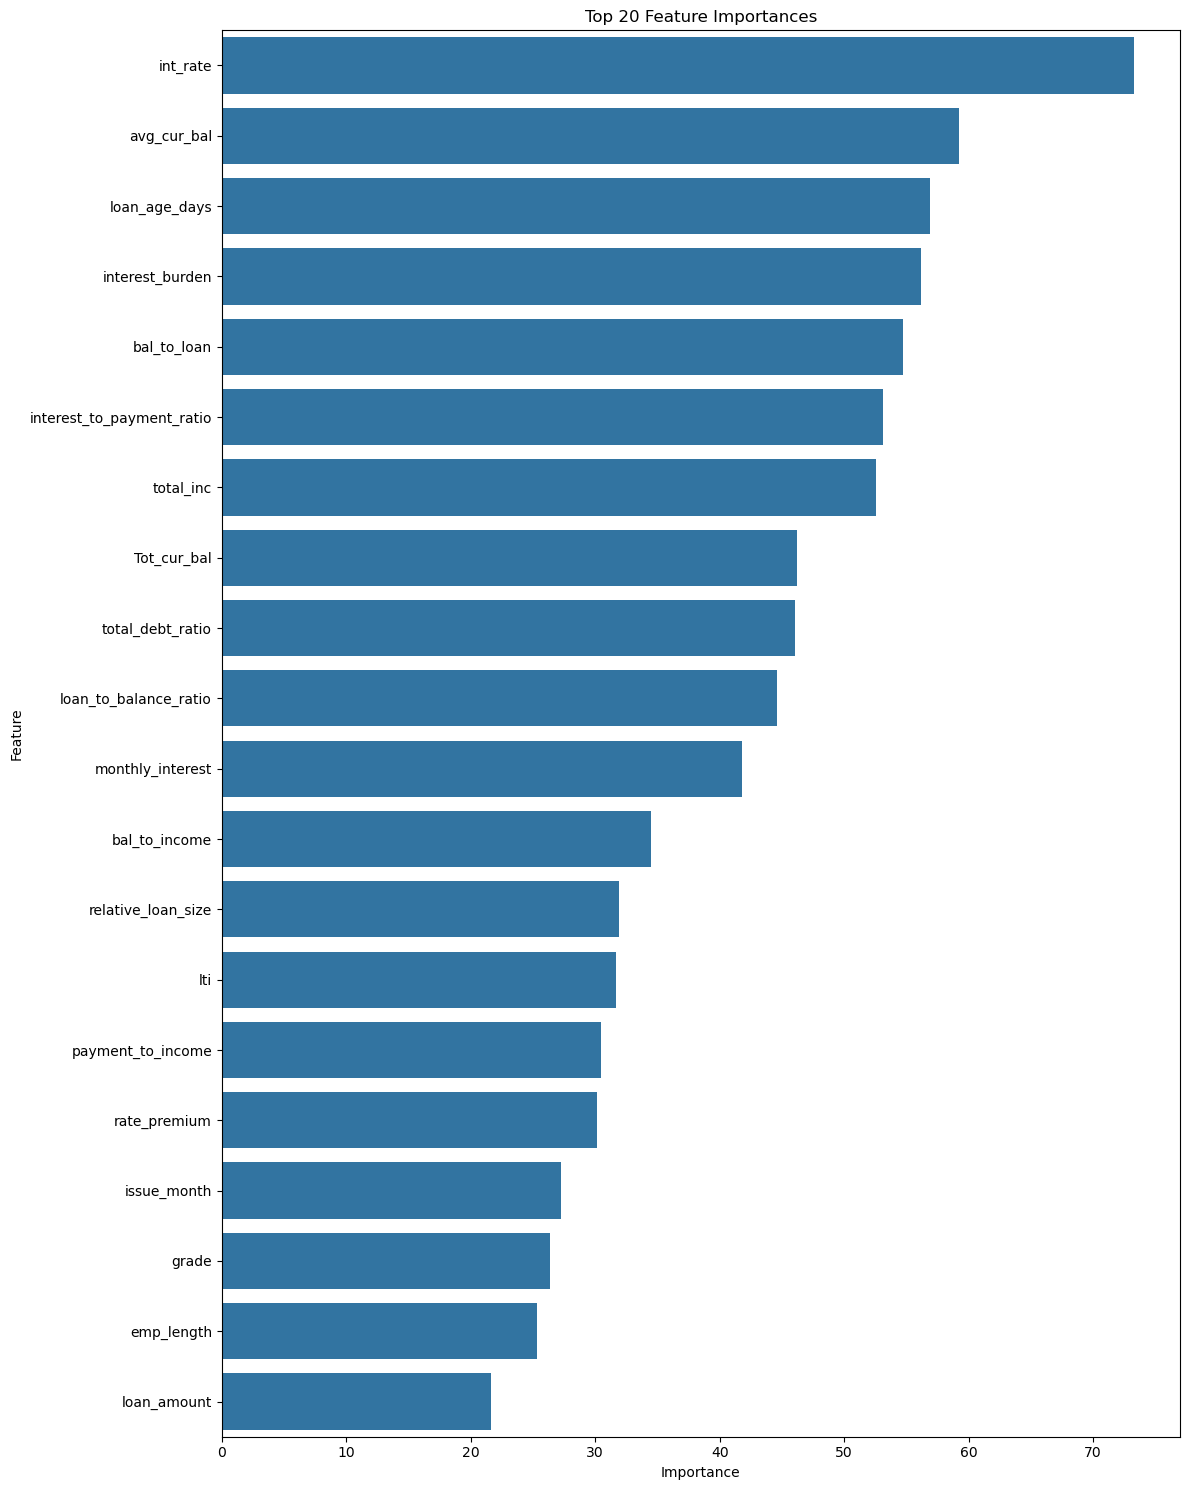

In [140]:
# Get feature importance
importance_df = get_average_feature_importances(best_model)
if importance_df is not None:
    print("\n=== TOP 20 IMPORTANT FEATURES ===")
    print(importance_df.head(20))

    # Plot feature importance
    plt.figure(figsize=(12, 15))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()

## 7. Hyperparameter Tuning

In [151]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

In [152]:
def custom_f1_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

f1_scorer = make_scorer(custom_f1_scorer, greater_is_better=True)

In [153]:
# Reduced cross-validation for faster tuning
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [154]:
def objective(trial):
    # Suggest hyperparameters for each classifier
    # LightGBM parameters (most impactful ones)
    lgb_n_estimators = trial.suggest_int('lgb_n_estimators', 100, 300, step=50)
    lgb_num_leaves = trial.suggest_int('lgb_num_leaves', 20, 100, step=10)
    lgb_learning_rate = trial.suggest_float('lgb_learning_rate', 0.02, 0.1, step=0.01)
    lgb_min_child_samples = trial.suggest_int('lgb_min_child_samples', 10, 50, step=10)
    
    # CatBoost parameters (focus on key ones)
    cat_iterations = trial.suggest_int('cat_iterations', 100, 300, step=50)
    cat_depth = trial.suggest_int('cat_depth', 4, 8)
    cat_learning_rate = trial.suggest_float('cat_learning_rate', 0.02, 0.1, step=0.01)
    cat_l2_leaf_reg = trial.suggest_int('cat_l2_leaf_reg', 1, 10)
    
    # XGBoost parameters (essential ones)
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 300, step=50)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 8)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.02, 0.15, step=0.01)
    xgb_subsample = trial.suggest_float('xgb_subsample', 0.6, 1.0, step=0.1)
    
    # Voting weights
    lgb_weight = trial.suggest_int('lgb_weight', 1, 5)
    cat_weight = trial.suggest_int('cat_weight', 3, 8)
    xgb_weight = trial.suggest_int('xgb_weight', 2, 7)
    
    # Create optimized estimators
    optimized_estimators = [
        ('lgb', lgb.LGBMClassifier(
            random_state=42,
            is_unbalance=True,
            class_weight={0: 1, 1: Counter(y_train)[0]/Counter(y_train)[1]},
            objective='binary',
            metric='auc',
            boost_from_average=False,
            n_estimators=lgb_n_estimators,
            num_leaves=lgb_num_leaves,
            learning_rate=lgb_learning_rate,
            min_child_samples=lgb_min_child_samples,
            verbosity=-1
        )),
        ('cat', CatBoostClassifier(
            random_seed=42,
            auto_class_weights='Balanced',
            loss_function='Logloss',
            eval_metric='AUC',
            iterations=cat_iterations,
            depth=cat_depth,
            learning_rate=cat_learning_rate,
            l2_leaf_reg=cat_l2_leaf_reg,
            verbose=False
        )),
        ('xgb', XGBClassifier(
            random_state=42,
            scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
            max_depth=xgb_max_depth,
            learning_rate=xgb_learning_rate,
            n_estimators=xgb_n_estimators,
            subsample=xgb_subsample,
            use_label_encoder=False,
            eval_metric='aucpr',
            gamma=2.0,
            verbosity=0
        ))
    ]
    
    # Create voting classifier with optimized weights
    optimized_voting_clf = VotingClassifier(
        estimators=optimized_estimators,
        voting='soft',
        weights=[lgb_weight, cat_weight, xgb_weight]
    )
    
    # Create pipeline
    optimized_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', optimized_voting_clf)
    ])
    
    # Use cross-validation to evaluate
    try:
        cv_scores = cross_val_score(
            optimized_pipeline, X_train, y_train, 
            cv=cv_folds, scoring=f1_scorer, n_jobs=1
        )
        return cv_scores.mean()
    except Exception as e:
        return 0.0  # Return poor score if error occurs

In [155]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-05-27 21:32:35,322] A new study created in memory with name: no-name-222152f5-d75e-4707-8ace-b0c44ccb1686


In [156]:
# Use 50 trials for balance between performance and time
n_trials = 50

In [158]:
study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

print(f"\nOptimization completed!")
print(f"Best F1 score: {study.best_value:.6f}")
print(f"Best parameters: {study.best_params}")

[I 2025-05-27 21:34:05,501] Trial 1 finished with value: 0.36038724490246477 and parameters: {'lgb_n_estimators': 100, 'lgb_num_leaves': 40, 'lgb_learning_rate': 0.06, 'lgb_min_child_samples': 30, 'cat_iterations': 150, 'cat_depth': 7, 'cat_learning_rate': 0.03, 'cat_l2_leaf_reg': 3, 'xgb_n_estimators': 150, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.12000000000000001, 'xgb_subsample': 0.6, 'lgb_weight': 3, 'cat_weight': 6, 'xgb_weight': 2}. Best is trial 1 with value: 0.36038724490246477.
[I 2025-05-27 21:35:12,482] Trial 2 finished with value: 0.36837952634018406 and parameters: {'lgb_n_estimators': 250, 'lgb_num_leaves': 30, 'lgb_learning_rate': 0.02, 'lgb_min_child_samples': 50, 'cat_iterations': 300, 'cat_depth': 8, 'cat_learning_rate': 0.04, 'cat_l2_leaf_reg': 1, 'xgb_n_estimators': 250, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.03, 'xgb_subsample': 0.8, 'lgb_weight': 1, 'cat_weight': 8, 'xgb_weight': 3}. Best is trial 2 with value: 0.36837952634018406.
[I 2025-05-27 21:36:04,45


Optimization completed!
Best F1 score: 0.369201
Best parameters: {'lgb_n_estimators': 250, 'lgb_num_leaves': 30, 'lgb_learning_rate': 0.02, 'lgb_min_child_samples': 50, 'cat_iterations': 200, 'cat_depth': 5, 'cat_learning_rate': 0.04, 'cat_l2_leaf_reg': 2, 'xgb_n_estimators': 300, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.03, 'xgb_subsample': 0.7, 'lgb_weight': 1, 'cat_weight': 7, 'xgb_weight': 7}


In [ ]:
# Optimization completed!
# Best F1 score: 0.369201
# Best parameters: {'lgb_n_estimators': 250, 'lgb_num_leaves': 30, 'lgb_learning_rate': 0.02, 'lgb_min_child_samples': 50, 'cat_iterations': 200, 'cat_depth': 5, 'cat_learning_rate': 0.04, 'cat_l2_leaf_reg': 2, 'xgb_n_estimators': 300, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.03, 'xgb_subsample': 0.7, 'lgb_weight': 1, 'cat_weight': 7, 'xgb_weight': 7}

In [100]:
# best_params = {'lgb_n_estimators': 250, 'lgb_num_leaves': 30, 'lgb_learning_rate': 0.02, 'lgb_min_child_samples': 50, 'cat_iterations': 200, 'cat_depth': 5, 'cat_learning_rate': 0.04, 'cat_l2_leaf_reg': 2, 'xgb_n_estimators': 300, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.03, 'xgb_subsample': 0.7, 'lgb_weight': 1, 'cat_weight': 7, 'xgb_weight': 7}

In [159]:
# Build the optimized model with best parameters
best_params = study.best_params

In [101]:
optimized_estimators_final = [
    ('lgb', lgb.LGBMClassifier(
        random_state=42,
        is_unbalance=True,
        class_weight={0: 1, 1: Counter(y_train)[0]/Counter(y_train)[1]},
        objective='binary',
        metric='auc',
        boost_from_average=False,
        n_estimators=best_params['lgb_n_estimators'],
        num_leaves=best_params['lgb_num_leaves'],
        learning_rate=best_params['lgb_learning_rate'],
        min_child_samples=best_params['lgb_min_child_samples'],
        verbosity=-1
    )),
    ('cat', CatBoostClassifier(
        random_seed=42,
        auto_class_weights='Balanced',
        loss_function='Logloss',
        eval_metric='AUC',
        iterations=best_params['cat_iterations'],
        depth=best_params['cat_depth'],
        learning_rate=best_params['cat_learning_rate'],
        l2_leaf_reg=best_params['cat_l2_leaf_reg'],
        verbose=False
    )),
    ('xgb', XGBClassifier(
        random_state=42,
        scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
        max_depth=best_params['xgb_max_depth'],
        learning_rate=best_params['xgb_learning_rate'],
        n_estimators=best_params['xgb_n_estimators'],
        subsample=best_params['xgb_subsample'],
        use_label_encoder=False,
        eval_metric='aucpr',
        gamma=2.0,
        verbosity=0
    ))
]

In [102]:
# Create optimized voting classifier
optimized_voting_clf_final = VotingClassifier(
    estimators=optimized_estimators_final,
    voting='soft',
    weights=[best_params['lgb_weight'], best_params['cat_weight'], best_params['xgb_weight']]
)

In [103]:
# Create optimized pipeline
optimized_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', optimized_voting_clf_final)
])

In [104]:
# Train the optimized model
optimized_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['emp_length', 'avg_cur_bal',
                                                   'Tot_cur_bal', 'loan_amount',
                                                   'int_rate', 'installment',
                                                   'issue_month',
                                                   'issue_quarter',
                                                   'issue_year_num',
                                                   'loan_age_days', 'total_inc',
                                                   'payment_to_income', 'lti',
                                                   'inter...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.03,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=300,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                  voting='soft', weights=[1, 7, 7]))])


--- Optimized Weighted Voting Ensemble Results ---
Accuracy: 0.6424
Balanced Accuracy: 0.6451
Precision: 0.2900
Recall/Sensitivity: 0.6495
F1 Score: 0.4010
Matthews Correlation Coefficient: 0.2286
ROC AUC: 0.7009
Gini: 0.4019
PR AUC: 0.3412


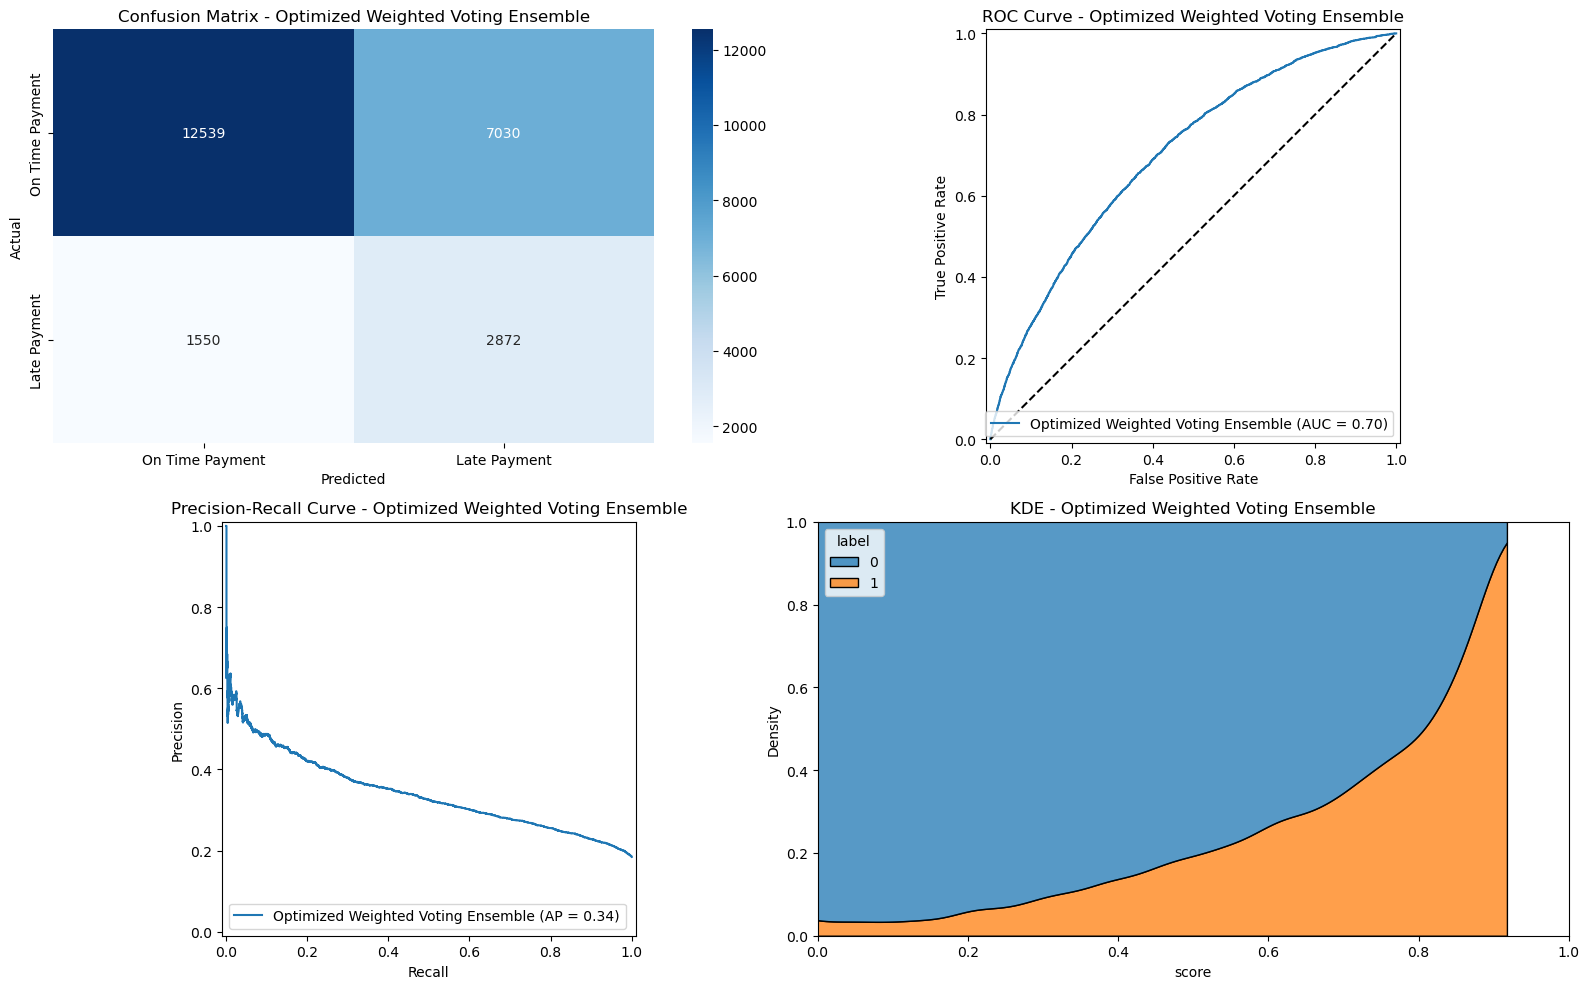

In [105]:
# Evaluate the optimized model
optimized_model_results = evaluate_model(optimized_model, X_test, y_test, "Optimized Weighted Voting Ensemble")

In [106]:
# Compare results
print("PERFORMANCE COMPARISON")
print("Original Model:")
print(f"  Recall: {weighted_voting_model_results.get('recall', 'N/A'):.6f}")
print(f"  F1 Score: {weighted_voting_model_results.get('f1', 'N/A'):.6f}")
print(f"  Balanced Accuracy: {weighted_voting_model_results.get('balanced_accuracy', 'N/A'):.6f}")
print(f"  PR-AUC: {weighted_voting_model_results.get('pr_auc', 'N/A'):.6f}")

print("\nOptimized Model:")
print(f"  Recall: {optimized_model_results.get('recall', 'N/A'):.6f}")
print(f"  F1 Score: {optimized_model_results.get('f1', 'N/A'):.6f}")
print(f"  Balanced Accuracy: {optimized_model_results.get('balanced_accuracy', 'N/A'):.6f}")
print(f"  PR-AUC: {optimized_model_results.get('pr_auc', 'N/A'):.6f}")

PERFORMANCE COMPARISON
Original Model:
  Recall: 0.710991
  F1 Score: 0.399061
  Balanced Accuracy: 0.646210
  PR-AUC: 0.340389

Optimized Model:
  Recall: 0.649480
  F1 Score: 0.401005
  Balanced Accuracy: 0.645119
  PR-AUC: 0.341160


In [107]:
# Calculate improvements
if 'f1' in weighted_voting_model_results and 'f1' in optimized_model_results:
    f1_improvement = ((optimized_model_results['f1'] - weighted_voting_model_results['f1']) 
                      / weighted_voting_model_results['f1']) * 100
    print(f"\nF1 Score Improvement: {f1_improvement:+.2f}%")


F1 Score Improvement: +0.49%


The F1 Score only increases by 0.49%, but it comes at the cost of an 8.65% decrease in recall. Therefore, the original model remains more appropriate.

## 8. Export Model

In [141]:
import joblib

In [142]:
joblib.dump(weighted_voting_model, 'weighted_voting_model.pkl')

['weighted_voting_model.pkl']